In [38]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
plt.style.use('fivethirtyeight')
np.random.seed(190)

In [39]:
#读取数据 
data=pd.read_csv('xgboost.csv') 
data=data.iloc[:,1:]
windows=3#时间窗长度
cut=100#最后预测的数量
lstm_size=16#lstm的神经元个数
epoch=60#训练次数
validation_split=0.1#验证集所占比例
batch_size=16
data.tail()

,post num,post per,cpi,isi,open,low,high,amount,money,close
1538,95152,47.332239,103.029298,66.971194,2834.9387,2802.4989,2834.9387,23518507600,2.440000e+11,2808.5293
1539,76622,34.619520,102.940217,65.976340,2812.2422,2802.9579,2832.6662,21013098100,2.250000e+11,2815.4947
1540,61146,27.584124,102.910716,65.623874,2819.9914,2758.2459,2821.7450,25387274500,2.710000e+11,2810.0243
1541,27162,12.826482,102.881311,65.260984,2801.3830,2800.7379,2831.7642,20206180700,2.230000e+11,2822.4424
1542,100028,54.142645,102.852003,64.887669,2832.3843,2832.3843,2865.5900,24245527800,2.770000e+11,2860.0822


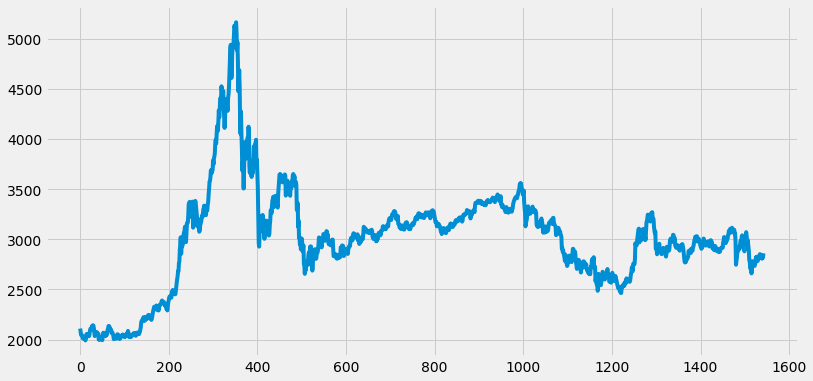

In [40]:
#展示一下看看
plt.figure(figsize=(12,6))
plt.plot(data['close'])

In [41]:
#区分特征和标签
y=data['close']
del data['close']
x=data
y=np.reshape(y.values, (-1,1))  

In [42]:
#归一化
from sklearn.preprocessing import MinMaxScaler
mm_x= MinMaxScaler()
mm_y= MinMaxScaler()
x= mm_x.fit_transform(x)
y= mm_y.fit_transform(y)

In [43]:
#构建lstm输入
df=pd.concat([pd.DataFrame(x),pd.DataFrame(y)],axis=1)
stock=df
seq_len=windows
amount_of_features = len(stock.columns)#有几列
data = stock.as_matrix() #pd.DataFrame(stock) 表格转化为矩阵
sequence_length = seq_len + 1#序列长度
result = []
for index in range(len(data) - sequence_length):#循环数据长度-sequence_length次
    result.append(data[index: index + sequence_length])#第i行到i+sequence_length
result = np.array(result)#得到样本，样本形式为6天*3特征
train = result[:-cut, :]
x_train = train[:, :-1]
y_train = train[:, -1][:,-1]
x_test = result[-cut:, :-1]
y_test = result[-cut:, -1][:,-1]
#reshape成 6天*3特征
X_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], amount_of_features))
X_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], amount_of_features))  
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1439, 3, 10) (1439,) (100, 3, 10) (100,)


E:\anoconda\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [44]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred - y_true) / y_true)) * 100
def up_down_accuracy(y_true, y_pred):
    y_var_test=y_true[1:]-y_true[:len(y_true)-1]#实际涨跌
    y_var_predict=y_pred[1:]-y_pred[:len(y_pred)-1]#原始涨跌
    txt=np.zeros(len(y_var_test))
    for i in range(len(y_var_test-1)):#计算数量
        txt[i]=np.sign(y_var_test[i])==np.sign(y_var_predict[i])
    result=sum(txt)/len(txt)
    return result

In [45]:
#三维网格搜索
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
def model_result(lstm_size,batch_size,epoch,y_test):
    #建立训练模型过程
    model = Sequential()#建立层次模型
    model.add(LSTM(lstm_size, input_shape=(windows, amount_of_features), return_sequences=False))#建立LSTM层
    model.add(Dense(lstm_size,init='uniform',activation='relu'))   #建立全连接层     
    model.add(Dense(1,init='uniform',activation='relu'))
    model.compile(loss='mse',optimizer='adam',metrics=['accuracy'])
    #神经网络训练及结果
    history= model.fit(X_train, y_train, nb_epoch =epoch,
                       batch_size =batch_size,validation_split=validation_split) #训练模型nb_epoch次
    #在测试集上的预测
    y_test_predict=model.predict(X_test)
    # 反归一化
    y_test_predict=np.reshape(y_test_predict, (-1,1))  
    y_test_predict= mm_y.inverse_transform(y_test_predict)
    y_test=np.reshape(y_test, (-1,1))  
    y_test=mm_y.inverse_transform(y_test)
    y_test_predict=y_test_predict[:,0]
    #输出结果
    y_test=y_test.reshape(-1)
    y_testpredict=y_test_predict.reshape(-1)
    a,b,c,d=mean_absolute_error(y_test_predict, y_test), np.sqrt(mean_squared_error(y_test_predict, y_test) ),mape(y_test_predict,  y_test), up_down_accuracy(y_test_predict,y_test)
    return  a,b,c,d
lstm_size=[8,16,32,64,128]
batch_size = [8,16,32,64,128]
epochs = [10,50,100,200,500]
record=[]
for i in lstm_size:
    for j in batch_size:
        for k in epochs:
            a,b,c,d=model_result(i,j,k,y_test)
            record.append([i,j,k,a,b,c,d])

E:\anoconda\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(8, activation="relu", kernel_initializer="uniform")`
  if __name__ == '__main__':
E:\anoconda\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="relu", kernel_initializer="uniform")`
  # Remove the CWD from sys.path while we load stuff.
E:\anoconda\lib\site-packages\ipykernel_launcher.py:14: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 1295 samples, validate on 144 samples
Epoch 1/10
1295/1295 [==============================] - 7s 6ms/step - loss: 0.0470 - accuracy: 7.7220e-04 - val_loss: 0.0016 - val_accuracy: 0.0000e+00
Epoch 2/10
1295/1295 [==============================] - 1s 655us/step - loss: 0.0029 - accuracy: 0.0015 - val_loss: 0.0013 - val_accuracy: 0.0000e+00
Epoch 3/10
1295/1295 [==============================] - 1s 655us/step - loss: 8.0898e-04 - accuracy: 0.0015 - val_loss: 6.7795e-04 - val_accuracy: 0.0000e+00
Epoch 4/10
1295/1295 [==============================] - 1s 679us/step - loss: 6.3320e-04 - accuracy: 0.0015 - val_loss: 5.7738e-04 - val_accuracy: 0.0000e+00
Epoch 5/10
1295/1295 [==============================] - 1s 672us/step - loss: 5.9096e-04 - accuracy: 0.0015 - val_loss: 2.5139e-04 - val_accuracy: 0.0000e+00
Epoch 6/10
1295/1295 [==============================] - 1s 666us/step - loss: 5.6701e-04 - accuracy: 0.0015 - val_loss: 2.7138e-04 - val_accuracy: 0.0000e+00
Epoch 7/10
1295/129

E:\anoconda\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(8, activation="relu", kernel_initializer="uniform")`
  if __name__ == '__main__':
E:\anoconda\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="relu", kernel_initializer="uniform")`
  # Remove the CWD from sys.path while we load stuff.
E:\anoconda\lib\site-packages\ipykernel_launcher.py:14: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 1295 samples, validate on 144 samples
Epoch 1/50
1295/1295 [==============================] - 7s 5ms/step - loss: 0.0500 - accuracy: 0.0015 - val_loss: 0.0019 - val_accuracy: 0.0000e+00
Epoch 2/50
1295/1295 [==============================] - 1s 769us/step - loss: 0.0046 - accuracy: 0.0015 - val_loss: 3.7552e-04 - val_accuracy: 0.0000e+00
Epoch 3/50
1295/1295 [==============================] - 1s 741us/step - loss: 0.0014 - accuracy: 0.0015 - val_loss: 5.1968e-04 - val_accuracy: 0.0000e+00
Epoch 4/50
1295/1295 [==============================] - 1s 779us/step - loss: 8.8634e-04 - accuracy: 0.0015 - val_loss: 2.2667e-04 - val_accuracy: 0.0000e+00
Epoch 5/50
1295/1295 [==============================] - 1s 750us/step - loss: 7.3006e-04 - accuracy: 0.0015 - val_loss: 1.6013e-04 - val_accuracy: 0.0000e+00
Epoch 6/50
1295/1295 [==============================] - 1s 773us/step - loss: 6.3702e-04 - accuracy: 0.0015 - val_loss: 1.5863e-04 - val_accuracy: 0.0000e+00
Epoch 7/50
1295/1295 [=

E:\anoconda\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(8, activation="relu", kernel_initializer="uniform")`
  if __name__ == '__main__':
E:\anoconda\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="relu", kernel_initializer="uniform")`
  # Remove the CWD from sys.path while we load stuff.
E:\anoconda\lib\site-packages\ipykernel_launcher.py:14: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 1295 samples, validate on 144 samples
Epoch 1/100
1295/1295 [==============================] - 6s 5ms/step - loss: 0.0455 - accuracy: 0.0015 - val_loss: 0.0084 - val_accuracy: 0.0000e+00
Epoch 2/100
1295/1295 [==============================] - 1s 701us/step - loss: 0.0037 - accuracy: 0.0015 - val_loss: 9.1313e-04 - val_accuracy: 0.0000e+00
Epoch 3/100
1295/1295 [==============================] - 1s 749us/step - loss: 0.0010 - accuracy: 0.0015 - val_loss: 2.2863e-04 - val_accuracy: 0.0000e+00
Epoch 4/100
1295/1295 [==============================] - 1s 744us/step - loss: 7.4145e-04 - accuracy: 0.0015 - val_loss: 2.1253e-04 - val_accuracy: 0.0000e+00
Epoch 5/100
1295/1295 [==============================] - 1s 766us/step - loss: 5.9908e-04 - accuracy: 0.0015 - val_loss: 1.8053e-04 - val_accuracy: 0.0000e+00
Epoch 6/100
1295/1295 [==============================] - 1s 746us/step - loss: 5.6356e-04 - accuracy: 0.0015 - val_loss: 1.6246e-04 - val_accuracy: 0.0000e+00
Epoch 7/100
1295/

Epoch 52/100
1295/1295 [==============================] - 1s 806us/step - loss: 3.2926e-04 - accuracy: 0.0015 - val_loss: 1.1376e-04 - val_accuracy: 0.0000e+00
Epoch 53/100
1295/1295 [==============================] - 1s 784us/step - loss: 3.2133e-04 - accuracy: 0.0015 - val_loss: 1.3189e-04 - val_accuracy: 0.0000e+00
Epoch 54/100
1295/1295 [==============================] - 1s 766us/step - loss: 3.3222e-04 - accuracy: 0.0015 - val_loss: 1.0695e-04 - val_accuracy: 0.0000e+00
Epoch 55/100
1295/1295 [==============================] - 1s 772us/step - loss: 3.2817e-04 - accuracy: 0.0015 - val_loss: 2.1626e-04 - val_accuracy: 0.0000e+00
Epoch 56/100
1295/1295 [==============================] - 1s 763us/step - loss: 3.1893e-04 - accuracy: 0.0015 - val_loss: 1.5514e-04 - val_accuracy: 0.0000e+00
Epoch 57/100
1295/1295 [==============================] - 1s 774us/step - loss: 3.0930e-04 - accuracy: 0.0015 - val_loss: 1.1713e-04 - val_accuracy: 0.0000e+00
Epoch 58/100
1295/1295 [================

E:\anoconda\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(8, activation="relu", kernel_initializer="uniform")`
  if __name__ == '__main__':
E:\anoconda\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="relu", kernel_initializer="uniform")`
  # Remove the CWD from sys.path while we load stuff.
E:\anoconda\lib\site-packages\ipykernel_launcher.py:14: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 1295 samples, validate on 144 samples
Epoch 1/200
1295/1295 [==============================] - 6s 4ms/step - loss: 0.0610 - accuracy: 7.7220e-04 - val_loss: 0.0013 - val_accuracy: 0.0000e+00
Epoch 2/200
1295/1295 [==============================] - 1s 666us/step - loss: 0.0047 - accuracy: 0.0015 - val_loss: 0.0014 - val_accuracy: 0.0000e+00
Epoch 3/200
1295/1295 [==============================] - 1s 642us/step - loss: 0.0011 - accuracy: 0.0015 - val_loss: 0.0012 - val_accuracy: 0.0000e+00
Epoch 4/200
1295/1295 [==============================] - 1s 651us/step - loss: 8.4341e-04 - accuracy: 0.0015 - val_loss: 5.4303e-04 - val_accuracy: 0.0000e+00
Epoch 5/200
1295/1295 [==============================] - 1s 715us/step - loss: 7.5669e-04 - accuracy: 0.0015 - val_loss: 6.0631e-04 - val_accuracy: 0.0000e+00
Epoch 6/200
1295/1295 [==============================] - 1s 692us/step - loss: 7.0388e-04 - accuracy: 0.0015 - val_loss: 3.7790e-04 - val_accuracy: 0.0000e+00
Epoch 7/200
1295/1295

1295/1295 [==============================] - 1s 770us/step - loss: 3.4950e-04 - accuracy: 0.0015 - val_loss: 1.7643e-04 - val_accuracy: 0.0000e+00
Epoch 53/200
1295/1295 [==============================] - 1s 779us/step - loss: 3.4325e-04 - accuracy: 0.0015 - val_loss: 1.1631e-04 - val_accuracy: 0.0000e+00
Epoch 54/200
1295/1295 [==============================] - 1s 744us/step - loss: 3.3230e-04 - accuracy: 0.0015 - val_loss: 1.2058e-04 - val_accuracy: 0.0000e+00
Epoch 55/200
1295/1295 [==============================] - 1s 766us/step - loss: 3.3467e-04 - accuracy: 0.0015 - val_loss: 1.3329e-04 - val_accuracy: 0.0000e+00
Epoch 56/200
1295/1295 [==============================] - 1s 764us/step - loss: 3.6427e-04 - accuracy: 0.0015 - val_loss: 1.4069e-04 - val_accuracy: 0.0000e+00
Epoch 57/200
1295/1295 [==============================] - 1s 787us/step - loss: 3.3505e-04 - accuracy: 0.0015 - val_loss: 1.3297e-04 - val_accuracy: 0.0000e+00
Epoch 58/200
1295/1295 [=============================

1295/1295 [==============================] - 1s 781us/step - loss: 2.6714e-04 - accuracy: 0.0015 - val_loss: 1.9083e-04 - val_accuracy: 0.0000e+00
Epoch 104/200
1295/1295 [==============================] - 1s 769us/step - loss: 2.6879e-04 - accuracy: 0.0015 - val_loss: 1.8479e-04 - val_accuracy: 0.0000e+00
Epoch 105/200
1295/1295 [==============================] - 1s 775us/step - loss: 2.7073e-04 - accuracy: 0.0015 - val_loss: 1.0210e-04 - val_accuracy: 0.0000e+00
Epoch 106/200
1295/1295 [==============================] - 1s 765us/step - loss: 2.7830e-04 - accuracy: 0.0015 - val_loss: 1.2952e-04 - val_accuracy: 0.0000e+00
Epoch 107/200
1295/1295 [==============================] - 1s 756us/step - loss: 2.7407e-04 - accuracy: 0.0015 - val_loss: 1.7602e-04 - val_accuracy: 0.0000e+00
Epoch 108/200
1295/1295 [==============================] - 1s 766us/step - loss: 2.7069e-04 - accuracy: 0.0015 - val_loss: 1.1992e-04 - val_accuracy: 0.0000e+00
Epoch 109/200
1295/1295 [=======================

Epoch 154/200
1295/1295 [==============================] - 1s 747us/step - loss: 2.6704e-04 - accuracy: 0.0015 - val_loss: 1.9064e-04 - val_accuracy: 0.0000e+00
Epoch 155/200
1295/1295 [==============================] - 1s 773us/step - loss: 2.6555e-04 - accuracy: 0.0015 - val_loss: 9.8297e-05 - val_accuracy: 0.0000e+00
Epoch 156/200
1295/1295 [==============================] - 1s 781us/step - loss: 2.5528e-04 - accuracy: 0.0015 - val_loss: 1.4043e-04 - val_accuracy: 0.0000e+00
Epoch 157/200
1295/1295 [==============================] - 1s 796us/step - loss: 2.5785e-04 - accuracy: 0.0015 - val_loss: 1.0682e-04 - val_accuracy: 0.0000e+00
Epoch 158/200
1295/1295 [==============================] - 1s 759us/step - loss: 2.4750e-04 - accuracy: 0.0015 - val_loss: 1.4105e-04 - val_accuracy: 0.0000e+00
Epoch 159/200
1295/1295 [==============================] - 1s 781us/step - loss: 2.5376e-04 - accuracy: 0.0015 - val_loss: 1.0385e-04 - val_accuracy: 0.0000e+00
Epoch 160/200
1295/1295 [=========

E:\anoconda\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(8, activation="relu", kernel_initializer="uniform")`
  if __name__ == '__main__':
E:\anoconda\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="relu", kernel_initializer="uniform")`
  # Remove the CWD from sys.path while we load stuff.
E:\anoconda\lib\site-packages\ipykernel_launcher.py:14: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 1295 samples, validate on 144 samples
Epoch 1/500
1295/1295 [==============================] - 6s 4ms/step - loss: 0.0667 - accuracy: 7.7220e-04 - val_loss: 0.0018 - val_accuracy: 0.0000e+00
Epoch 2/500
1295/1295 [==============================] - 1s 667us/step - loss: 0.0049 - accuracy: 0.0015 - val_loss: 0.0016 - val_accuracy: 0.0000e+00
Epoch 3/500
1295/1295 [==============================] - 1s 652us/step - loss: 0.0013 - accuracy: 0.0015 - val_loss: 0.0013 - val_accuracy: 0.0000e+00
Epoch 4/500
1295/1295 [==============================] - 1s 677us/step - loss: 8.1070e-04 - accuracy: 0.0015 - val_loss: 7.0052e-04 - val_accuracy: 0.0000e+00
Epoch 5/500
1295/1295 [==============================] - 1s 652us/step - loss: 6.8817e-04 - accuracy: 0.0015 - val_loss: 3.2785e-04 - val_accuracy: 0.0000e+00
Epoch 6/500
1295/1295 [==============================] - 1s 641us/step - loss: 6.3195e-04 - accuracy: 0.0015 - val_loss: 2.4605e-04 - val_accuracy: 0.0000e+00
Epoch 7/500
1295/1295

Epoch 52/500
1295/1295 [==============================] - 1s 797us/step - loss: 3.5980e-04 - accuracy: 0.0015 - val_loss: 1.8454e-04 - val_accuracy: 0.0000e+00
Epoch 53/500
1295/1295 [==============================] - 1s 781us/step - loss: 3.4445e-04 - accuracy: 0.0015 - val_loss: 1.5551e-04 - val_accuracy: 0.0000e+00
Epoch 54/500
1295/1295 [==============================] - 1s 777us/step - loss: 3.6878e-04 - accuracy: 0.0015 - val_loss: 1.4423e-04 - val_accuracy: 0.0000e+00
Epoch 55/500
1295/1295 [==============================] - 1s 796us/step - loss: 3.3218e-04 - accuracy: 0.0015 - val_loss: 1.4230e-04 - val_accuracy: 0.0000e+00
Epoch 56/500
1295/1295 [==============================] - 1s 806us/step - loss: 3.5935e-04 - accuracy: 0.0015 - val_loss: 1.2408e-04 - val_accuracy: 0.0000e+00
Epoch 57/500
1295/1295 [==============================] - 1s 776us/step - loss: 3.5762e-04 - accuracy: 0.0015 - val_loss: 1.3560e-04 - val_accuracy: 0.0000e+00
Epoch 58/500
1295/1295 [================

1295/1295 [==============================] - 1s 792us/step - loss: 2.6586e-04 - accuracy: 0.0015 - val_loss: 1.2375e-04 - val_accuracy: 0.0000e+00
Epoch 104/500
1295/1295 [==============================] - 1s 759us/step - loss: 2.6091e-04 - accuracy: 0.0015 - val_loss: 1.0495e-04 - val_accuracy: 0.0000e+00
Epoch 105/500
1295/1295 [==============================] - 1s 784us/step - loss: 2.7664e-04 - accuracy: 0.0015 - val_loss: 1.8418e-04 - val_accuracy: 0.0000e+00
Epoch 106/500
1295/1295 [==============================] - 1s 787us/step - loss: 2.6032e-04 - accuracy: 0.0015 - val_loss: 1.5888e-04 - val_accuracy: 0.0000e+00
Epoch 107/500
1295/1295 [==============================] - 1s 779us/step - loss: 2.7612e-04 - accuracy: 0.0015 - val_loss: 1.7216e-04 - val_accuracy: 0.0000e+00
Epoch 108/500
1295/1295 [==============================] - 1s 807us/step - loss: 2.7150e-04 - accuracy: 0.0015 - val_loss: 1.9813e-04 - val_accuracy: 0.0000e+00
Epoch 109/500
1295/1295 [=======================

Epoch 154/500
1295/1295 [==============================] - 1s 769us/step - loss: 2.5178e-04 - accuracy: 0.0015 - val_loss: 1.4075e-04 - val_accuracy: 0.0000e+00
Epoch 155/500
1295/1295 [==============================] - 1s 793us/step - loss: 2.6385e-04 - accuracy: 0.0015 - val_loss: 1.2514e-04 - val_accuracy: 0.0000e+00
Epoch 156/500
1295/1295 [==============================] - 1s 788us/step - loss: 2.6047e-04 - accuracy: 0.0015 - val_loss: 1.3842e-04 - val_accuracy: 0.0000e+00
Epoch 157/500
1295/1295 [==============================] - 1s 794us/step - loss: 2.7524e-04 - accuracy: 0.0015 - val_loss: 9.8061e-05 - val_accuracy: 0.0000e+00
Epoch 158/500
1295/1295 [==============================] - 1s 808us/step - loss: 2.6260e-04 - accuracy: 0.0015 - val_loss: 1.1026e-04 - val_accuracy: 0.0000e+00
Epoch 159/500
1295/1295 [==============================] - 1s 803us/step - loss: 2.6420e-04 - accuracy: 0.0015 - val_loss: 1.0727e-04 - val_accuracy: 0.0000e+00
Epoch 160/500
1295/1295 [=========

Epoch 205/500
1295/1295 [==============================] - 1s 789us/step - loss: 2.5607e-04 - accuracy: 0.0015 - val_loss: 3.3678e-04 - val_accuracy: 0.0000e+00
Epoch 206/500
1295/1295 [==============================] - 1s 792us/step - loss: 2.6905e-04 - accuracy: 0.0015 - val_loss: 1.7295e-04 - val_accuracy: 0.0000e+00
Epoch 207/500
1295/1295 [==============================] - 1s 793us/step - loss: 2.4961e-04 - accuracy: 0.0015 - val_loss: 1.1308e-04 - val_accuracy: 0.0000e+00
Epoch 208/500
1295/1295 [==============================] - 1s 768us/step - loss: 2.5819e-04 - accuracy: 0.0015 - val_loss: 1.0798e-04 - val_accuracy: 0.0000e+00
Epoch 209/500
1295/1295 [==============================] - 1s 785us/step - loss: 2.5190e-04 - accuracy: 0.0015 - val_loss: 1.1175e-04 - val_accuracy: 0.0000e+00
Epoch 210/500
1295/1295 [==============================] - 1s 784us/step - loss: 2.6123e-04 - accuracy: 0.0015 - val_loss: 1.3278e-04 - val_accuracy: 0.0000e+00
Epoch 211/500
1295/1295 [=========

Epoch 256/500
1295/1295 [==============================] - 1s 785us/step - loss: 2.5320e-04 - accuracy: 0.0015 - val_loss: 1.3210e-04 - val_accuracy: 0.0000e+00
Epoch 257/500
1295/1295 [==============================] - 1s 764us/step - loss: 2.4639e-04 - accuracy: 0.0015 - val_loss: 1.2078e-04 - val_accuracy: 0.0000e+00
Epoch 258/500
1295/1295 [==============================] - 1s 778us/step - loss: 2.4278e-04 - accuracy: 0.0015 - val_loss: 1.1126e-04 - val_accuracy: 0.0000e+00
Epoch 259/500
1295/1295 [==============================] - 1s 793us/step - loss: 2.5754e-04 - accuracy: 0.0015 - val_loss: 1.6788e-04 - val_accuracy: 0.0000e+00
Epoch 260/500
1295/1295 [==============================] - 1s 805us/step - loss: 2.6747e-04 - accuracy: 0.0015 - val_loss: 1.2849e-04 - val_accuracy: 0.0000e+00
Epoch 261/500
1295/1295 [==============================] - 1s 760us/step - loss: 2.3773e-04 - accuracy: 0.0015 - val_loss: 1.4136e-04 - val_accuracy: 0.0000e+00
Epoch 262/500
1295/1295 [=========

Epoch 307/500
1295/1295 [==============================] - 1s 784us/step - loss: 2.4968e-04 - accuracy: 0.0015 - val_loss: 1.0598e-04 - val_accuracy: 0.0000e+00
Epoch 308/500
1295/1295 [==============================] - 1s 773us/step - loss: 2.4143e-04 - accuracy: 0.0015 - val_loss: 1.1001e-04 - val_accuracy: 0.0000e+00
Epoch 309/500
1295/1295 [==============================] - 1s 791us/step - loss: 2.4651e-04 - accuracy: 0.0015 - val_loss: 1.0456e-04 - val_accuracy: 0.0000e+00
Epoch 310/500
1295/1295 [==============================] - 1s 777us/step - loss: 2.4063e-04 - accuracy: 0.0015 - val_loss: 1.9667e-04 - val_accuracy: 0.0000e+00
Epoch 311/500
1295/1295 [==============================] - 1s 792us/step - loss: 2.4501e-04 - accuracy: 0.0015 - val_loss: 1.5674e-04 - val_accuracy: 0.0000e+00
Epoch 312/500
1295/1295 [==============================] - 1s 774us/step - loss: 2.5553e-04 - accuracy: 0.0015 - val_loss: 1.4561e-04 - val_accuracy: 0.0000e+00
Epoch 313/500
1295/1295 [=========

Epoch 358/500
1295/1295 [==============================] - 1s 769us/step - loss: 2.3763e-04 - accuracy: 0.0015 - val_loss: 2.0588e-04 - val_accuracy: 0.0000e+00
Epoch 359/500
1295/1295 [==============================] - 1s 801us/step - loss: 2.3247e-04 - accuracy: 0.0015 - val_loss: 1.0139e-04 - val_accuracy: 0.0000e+00
Epoch 360/500
1295/1295 [==============================] - 1s 777us/step - loss: 2.4514e-04 - accuracy: 0.0015 - val_loss: 1.0392e-04 - val_accuracy: 0.0000e+00
Epoch 361/500
1295/1295 [==============================] - 1s 815us/step - loss: 2.3567e-04 - accuracy: 0.0015 - val_loss: 1.0516e-04 - val_accuracy: 0.0000e+00
Epoch 362/500
1295/1295 [==============================] - 1s 775us/step - loss: 2.3774e-04 - accuracy: 0.0015 - val_loss: 1.4560e-04 - val_accuracy: 0.0000e+00
Epoch 363/500
1295/1295 [==============================] - 1s 784us/step - loss: 2.5468e-04 - accuracy: 0.0015 - val_loss: 1.2070e-04 - val_accuracy: 0.0000e+00
Epoch 364/500
1295/1295 [=========

Epoch 409/500
1295/1295 [==============================] - 1s 785us/step - loss: 2.3137e-04 - accuracy: 0.0015 - val_loss: 1.1787e-04 - val_accuracy: 0.0000e+00
Epoch 410/500
1295/1295 [==============================] - 1s 778us/step - loss: 2.3200e-04 - accuracy: 0.0015 - val_loss: 1.5053e-04 - val_accuracy: 0.0000e+00
Epoch 411/500
1295/1295 [==============================] - 1s 772us/step - loss: 2.3699e-04 - accuracy: 0.0015 - val_loss: 1.5327e-04 - val_accuracy: 0.0000e+00
Epoch 412/500
1295/1295 [==============================] - 1s 789us/step - loss: 2.2070e-04 - accuracy: 0.0015 - val_loss: 1.6526e-04 - val_accuracy: 0.0000e+00
Epoch 413/500
1295/1295 [==============================] - 1s 766us/step - loss: 2.4099e-04 - accuracy: 0.0015 - val_loss: 1.4245e-04 - val_accuracy: 0.0000e+00
Epoch 414/500
1295/1295 [==============================] - 1s 787us/step - loss: 2.3544e-04 - accuracy: 0.0015 - val_loss: 1.3219e-04 - val_accuracy: 0.0000e+00
Epoch 415/500
1295/1295 [=========

1295/1295 [==============================] - 1s 781us/step - loss: 2.3354e-04 - accuracy: 0.0015 - val_loss: 1.4786e-04 - val_accuracy: 0.0000e+00
Epoch 460/500
1295/1295 [==============================] - 1s 773us/step - loss: 2.3270e-04 - accuracy: 0.0015 - val_loss: 1.1058e-04 - val_accuracy: 0.0000e+00
Epoch 461/500
1295/1295 [==============================] - 1s 785us/step - loss: 2.4833e-04 - accuracy: 0.0015 - val_loss: 1.1102e-04 - val_accuracy: 0.0000e+00
Epoch 462/500
1295/1295 [==============================] - 1s 798us/step - loss: 2.3120e-04 - accuracy: 0.0015 - val_loss: 1.4303e-04 - val_accuracy: 0.0000e+00
Epoch 463/500
1295/1295 [==============================] - 1s 784us/step - loss: 2.3536e-04 - accuracy: 0.0015 - val_loss: 1.1962e-04 - val_accuracy: 0.0000e+00
Epoch 464/500
1295/1295 [==============================] - 1s 775us/step - loss: 2.4625e-04 - accuracy: 0.0015 - val_loss: 1.2340e-04 - val_accuracy: 0.0000e+00
Epoch 465/500
1295/1295 [=======================

E:\anoconda\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(8, activation="relu", kernel_initializer="uniform")`
  if __name__ == '__main__':
E:\anoconda\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="relu", kernel_initializer="uniform")`
  # Remove the CWD from sys.path while we load stuff.
E:\anoconda\lib\site-packages\ipykernel_launcher.py:14: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 1295 samples, validate on 144 samples
Epoch 1/10
1295/1295 [==============================] - 7s 6ms/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 2/10
1295/1295 [==============================] - 1s 394us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 3/10
1295/1295 [==============================] - 1s 417us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 4/10
1295/1295 [==============================] - 1s 417us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 5/10
1295/1295 [==============================] - 0s 347us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 6/10
1295/1295 [==============================] - 0s 316us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 7/10
1295/1295 [=========

E:\anoconda\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(8, activation="relu", kernel_initializer="uniform")`
  if __name__ == '__main__':
E:\anoconda\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="relu", kernel_initializer="uniform")`
  # Remove the CWD from sys.path while we load stuff.
E:\anoconda\lib\site-packages\ipykernel_launcher.py:14: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 1295 samples, validate on 144 samples
Epoch 1/50
1295/1295 [==============================] - 7s 5ms/step - loss: 0.0978 - accuracy: 7.7220e-04 - val_loss: 0.0118 - val_accuracy: 0.0000e+00
Epoch 2/50
1295/1295 [==============================] - 1s 500us/step - loss: 0.0170 - accuracy: 7.7220e-04 - val_loss: 0.0018 - val_accuracy: 0.0000e+00
Epoch 3/50
1295/1295 [==============================] - 1s 453us/step - loss: 0.0058 - accuracy: 0.0015 - val_loss: 3.7001e-04 - val_accuracy: 0.0000e+00
Epoch 4/50
1295/1295 [==============================] - 1s 454us/step - loss: 0.0021 - accuracy: 0.0015 - val_loss: 0.0012 - val_accuracy: 0.0000e+00
Epoch 5/50
1295/1295 [==============================] - 1s 442us/step - loss: 0.0014 - accuracy: 0.0015 - val_loss: 0.0010 - val_accuracy: 0.0000e+00
Epoch 6/50
1295/1295 [==============================] - ETA: 0s - loss: 0.0012 - accuracy: 0.00 - 1s 412us/step - loss: 0.0012 - accuracy: 0.0015 - val_loss: 7.2616e-04 - val_accuracy: 0.0000e+

E:\anoconda\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(8, activation="relu", kernel_initializer="uniform")`
  if __name__ == '__main__':
E:\anoconda\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="relu", kernel_initializer="uniform")`
  # Remove the CWD from sys.path while we load stuff.
E:\anoconda\lib\site-packages\ipykernel_launcher.py:14: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 1295 samples, validate on 144 samples
Epoch 1/100
1295/1295 [==============================] - 8s 6ms/step - loss: 0.0894 - accuracy: 7.7220e-04 - val_loss: 8.6562e-04 - val_accuracy: 0.0000e+00
Epoch 2/100
1295/1295 [==============================] - 1s 411us/step - loss: 0.0122 - accuracy: 0.0015 - val_loss: 0.0015 - val_accuracy: 0.0000e+00
Epoch 3/100
1295/1295 [==============================] - 1s 415us/step - loss: 0.0041 - accuracy: 0.0015 - val_loss: 2.7566e-04 - val_accuracy: 0.0000e+00
Epoch 4/100
1295/1295 [==============================] - 1s 394us/step - loss: 0.0011 - accuracy: 0.0015 - val_loss: 7.4561e-04 - val_accuracy: 0.0000e+00
Epoch 5/100
1295/1295 [==============================] - 1s 409us/step - loss: 8.3994e-04 - accuracy: 0.0015 - val_loss: 5.9743e-04 - val_accuracy: 0.0000e+00
Epoch 6/100
1295/1295 [==============================] - 1s 424us/step - loss: 7.2401e-04 - accuracy: 0.0015 - val_loss: 5.7350e-04 - val_accuracy: 0.0000e+00
Epoch 7/100
1295/

1295/1295 [==============================] - 0s 353us/step - loss: 3.7515e-04 - accuracy: 0.0015 - val_loss: 1.3871e-04 - val_accuracy: 0.0000e+00
Epoch 53/100
1295/1295 [==============================] - 0s 343us/step - loss: 3.7299e-04 - accuracy: 0.0015 - val_loss: 1.6849e-04 - val_accuracy: 0.0000e+00
Epoch 54/100
1295/1295 [==============================] - 0s 339us/step - loss: 3.5568e-04 - accuracy: 0.0015 - val_loss: 1.4902e-04 - val_accuracy: 0.0000e+00
Epoch 55/100
1295/1295 [==============================] - 0s 337us/step - loss: 3.7022e-04 - accuracy: 0.0015 - val_loss: 1.5363e-04 - val_accuracy: 0.0000e+00
Epoch 56/100
1295/1295 [==============================] - 0s 338us/step - loss: 3.5274e-04 - accuracy: 0.0015 - val_loss: 1.5235e-04 - val_accuracy: 0.0000e+00
Epoch 57/100
1295/1295 [==============================] - 0s 333us/step - loss: 3.5423e-04 - accuracy: 0.0015 - val_loss: 1.4371e-04 - val_accuracy: 0.0000e+00
Epoch 58/100
1295/1295 [=============================

E:\anoconda\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(8, activation="relu", kernel_initializer="uniform")`
  if __name__ == '__main__':
E:\anoconda\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="relu", kernel_initializer="uniform")`
  # Remove the CWD from sys.path while we load stuff.
E:\anoconda\lib\site-packages\ipykernel_launcher.py:14: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 1295 samples, validate on 144 samples
Epoch 1/200
1295/1295 [==============================] - 8s 6ms/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 2/200
1295/1295 [==============================] - 1s 407us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 3/200
1295/1295 [==============================] - 1s 425us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 4/200
1295/1295 [==============================] - 1s 423us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 5/200
1295/1295 [==============================] - 0s 386us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 6/200
1295/1295 [==============================] - 1s 410us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 7/200
1295/1295 [==

Epoch 53/200
1295/1295 [==============================] - 0s 333us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 54/200
1295/1295 [==============================] - 0s 340us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 55/200
1295/1295 [==============================] - 0s 349us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 56/200
1295/1295 [==============================] - 0s 372us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 57/200
1295/1295 [==============================] - ETA: 0s - loss: 0.1363 - accuracy: 8.5616e- - 0s 349us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 58/200
1295/1295 [==============================] - 0s 340us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 59/200
1295/

1295/1295 [==============================] - 0s 351us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 106/200
1295/1295 [==============================] - 0s 335us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 107/200
1295/1295 [==============================] - 0s 338us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 108/200
1295/1295 [==============================] - 0s 341us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 109/200
1295/1295 [==============================] - 0s 353us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 110/200
1295/1295 [==============================] - 0s 344us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 111/200
1295/1295 [==============================] - 0s 349us/step

1295/1295 [==============================] - 1s 420us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 158/200
1295/1295 [==============================] - 1s 414us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 159/200
1295/1295 [==============================] - 1s 414us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 160/200
1295/1295 [==============================] - 1s 403us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 161/200
1295/1295 [==============================] - 1s 417us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 162/200
1295/1295 [==============================] - 1s 411us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 163/200
1295/1295 [==============================] - 1s 410us/step

E:\anoconda\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(8, activation="relu", kernel_initializer="uniform")`
  if __name__ == '__main__':
E:\anoconda\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="relu", kernel_initializer="uniform")`
  # Remove the CWD from sys.path while we load stuff.
E:\anoconda\lib\site-packages\ipykernel_launcher.py:14: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 1295 samples, validate on 144 samples
Epoch 1/500
1295/1295 [==============================] - 8s 6ms/step - loss: 0.0819 - accuracy: 7.7220e-04 - val_loss: 0.0012 - val_accuracy: 0.0000e+00
Epoch 2/500
1295/1295 [==============================] - 1s 405us/step - loss: 0.0097 - accuracy: 0.0015 - val_loss: 8.4705e-04 - val_accuracy: 0.0000e+00
Epoch 3/500
1295/1295 [==============================] - 1s 410us/step - loss: 0.0028 - accuracy: 0.0015 - val_loss: 0.0014 - val_accuracy: 0.0000e+00
Epoch 4/500
1295/1295 [==============================] - 1s 410us/step - loss: 0.0012 - accuracy: 0.0015 - val_loss: 0.0014 - val_accuracy: 0.0000e+00
Epoch 5/500
1295/1295 [==============================] - 1s 425us/step - loss: 9.5678e-04 - accuracy: 0.0015 - val_loss: 0.0014 - val_accuracy: 0.0000e+00
Epoch 6/500
1295/1295 [==============================] - 1s 407us/step - loss: 8.4984e-04 - accuracy: 0.0015 - val_loss: 6.8819e-04 - val_accuracy: 0.0000e+00
Epoch 7/500
1295/1295 [======

1295/1295 [==============================] - 0s 348us/step - loss: 3.7384e-04 - accuracy: 0.0015 - val_loss: 1.3251e-04 - val_accuracy: 0.0000e+00
Epoch 53/500
1295/1295 [==============================] - 0s 340us/step - loss: 3.7075e-04 - accuracy: 0.0015 - val_loss: 1.7889e-04 - val_accuracy: 0.0000e+00
Epoch 54/500
1295/1295 [==============================] - 0s 350us/step - loss: 3.7507e-04 - accuracy: 0.0015 - val_loss: 1.2305e-04 - val_accuracy: 0.0000e+00
Epoch 55/500
1295/1295 [==============================] - 0s 342us/step - loss: 3.9334e-04 - accuracy: 0.0015 - val_loss: 1.2646e-04 - val_accuracy: 0.0000e+00
Epoch 56/500
1295/1295 [==============================] - 0s 326us/step - loss: 3.5320e-04 - accuracy: 0.0015 - val_loss: 2.2817e-04 - val_accuracy: 0.0000e+00
Epoch 57/500
1295/1295 [==============================] - 0s 345us/step - loss: 3.9223e-04 - accuracy: 0.0015 - val_loss: 1.5445e-04 - val_accuracy: 0.0000e+00
Epoch 58/500
1295/1295 [=============================

1295/1295 [==============================] - 0s 364us/step - loss: 3.0633e-04 - accuracy: 0.0015 - val_loss: 9.9976e-05 - val_accuracy: 0.0000e+00
Epoch 104/500
1295/1295 [==============================] - 0s 360us/step - loss: 3.0596e-04 - accuracy: 0.0015 - val_loss: 1.0566e-04 - val_accuracy: 0.0000e+00
Epoch 105/500
1295/1295 [==============================] - 0s 342us/step - loss: 2.8821e-04 - accuracy: 0.0015 - val_loss: 1.4832e-04 - val_accuracy: 0.0000e+00
Epoch 106/500
1295/1295 [==============================] - 0s 347us/step - loss: 2.9685e-04 - accuracy: 0.0015 - val_loss: 1.3773e-04 - val_accuracy: 0.0000e+00
Epoch 107/500
1295/1295 [==============================] - 0s 337us/step - loss: 3.0231e-04 - accuracy: 0.0015 - val_loss: 1.0535e-04 - val_accuracy: 0.0000e+00
Epoch 108/500
1295/1295 [==============================] - 0s 339us/step - loss: 2.8228e-04 - accuracy: 0.0015 - val_loss: 1.0523e-04 - val_accuracy: 0.0000e+00
Epoch 109/500
1295/1295 [=======================

Epoch 154/500
1295/1295 [==============================] - 1s 411us/step - loss: 2.5714e-04 - accuracy: 0.0015 - val_loss: 1.5125e-04 - val_accuracy: 0.0000e+00
Epoch 155/500
1295/1295 [==============================] - 1s 409us/step - loss: 2.6719e-04 - accuracy: 0.0015 - val_loss: 1.2954e-04 - val_accuracy: 0.0000e+00
Epoch 156/500
1295/1295 [==============================] - 1s 429us/step - loss: 2.5594e-04 - accuracy: 0.0015 - val_loss: 1.2734e-04 - val_accuracy: 0.0000e+00
Epoch 157/500
1295/1295 [==============================] - 1s 442us/step - loss: 2.7457e-04 - accuracy: 0.0015 - val_loss: 1.7323e-04 - val_accuracy: 0.0000e+00
Epoch 158/500
1295/1295 [==============================] - 1s 424us/step - loss: 2.6811e-04 - accuracy: 0.0015 - val_loss: 1.1483e-04 - val_accuracy: 0.0000e+00
Epoch 159/500
1295/1295 [==============================] - 1s 417us/step - loss: 2.8692e-04 - accuracy: 0.0015 - val_loss: 1.7510e-04 - val_accuracy: 0.0000e+00
Epoch 160/500
1295/1295 [=========

Epoch 205/500
1295/1295 [==============================] - 1s 411us/step - loss: 2.5379e-04 - accuracy: 0.0015 - val_loss: 1.1152e-04 - val_accuracy: 0.0000e+00
Epoch 206/500
1295/1295 [==============================] - 1s 420us/step - loss: 2.5616e-04 - accuracy: 0.0015 - val_loss: 1.1296e-04 - val_accuracy: 0.0000e+00
Epoch 207/500
1295/1295 [==============================] - 1s 405us/step - loss: 2.5234e-04 - accuracy: 0.0015 - val_loss: 1.1745e-04 - val_accuracy: 0.0000e+00
Epoch 208/500
1295/1295 [==============================] - 1s 422us/step - loss: 2.6271e-04 - accuracy: 0.0015 - val_loss: 1.4485e-04 - val_accuracy: 0.0000e+00
Epoch 209/500
1295/1295 [==============================] - 1s 413us/step - loss: 2.5328e-04 - accuracy: 0.0015 - val_loss: 1.1985e-04 - val_accuracy: 0.0000e+00
Epoch 210/500
1295/1295 [==============================] - 1s 425us/step - loss: 2.5651e-04 - accuracy: 0.0015 - val_loss: 1.0667e-04 - val_accuracy: 0.0000e+00
Epoch 211/500
1295/1295 [=========

1295/1295 [==============================] - 1s 417us/step - loss: 2.4721e-04 - accuracy: 0.0015 - val_loss: 1.6993e-04 - val_accuracy: 0.0000e+00
Epoch 256/500
1295/1295 [==============================] - 1s 424us/step - loss: 2.6739e-04 - accuracy: 0.0015 - val_loss: 1.4235e-04 - val_accuracy: 0.0000e+00
Epoch 257/500
1295/1295 [==============================] - 1s 424us/step - loss: 2.6115e-04 - accuracy: 0.0015 - val_loss: 1.5971e-04 - val_accuracy: 0.0000e+00
Epoch 258/500
1295/1295 [==============================] - 1s 404us/step - loss: 2.6410e-04 - accuracy: 0.0015 - val_loss: 1.1910e-04 - val_accuracy: 0.0000e+00
Epoch 259/500
1295/1295 [==============================] - 1s 424us/step - loss: 2.7271e-04 - accuracy: 0.0015 - val_loss: 1.1475e-04 - val_accuracy: 0.0000e+00
Epoch 260/500
1295/1295 [==============================] - 1s 425us/step - loss: 2.4702e-04 - accuracy: 0.0015 - val_loss: 1.1073e-04 - val_accuracy: 0.0000e+00
Epoch 261/500
1295/1295 [=======================

Epoch 306/500
1295/1295 [==============================] - 1s 416us/step - loss: 2.6585e-04 - accuracy: 0.0015 - val_loss: 1.2493e-04 - val_accuracy: 0.0000e+00
Epoch 307/500
1295/1295 [==============================] - 1s 434us/step - loss: 2.4865e-04 - accuracy: 0.0015 - val_loss: 1.4275e-04 - val_accuracy: 0.0000e+00
Epoch 308/500
1295/1295 [==============================] - 1s 415us/step - loss: 2.6544e-04 - accuracy: 0.0015 - val_loss: 1.7332e-04 - val_accuracy: 0.0000e+00
Epoch 309/500
1295/1295 [==============================] - 1s 407us/step - loss: 2.5024e-04 - accuracy: 0.0015 - val_loss: 1.7740e-04 - val_accuracy: 0.0000e+00
Epoch 310/500
1295/1295 [==============================] - 1s 410us/step - loss: 2.4571e-04 - accuracy: 0.0015 - val_loss: 1.1444e-04 - val_accuracy: 0.0000e+00
Epoch 311/500
1295/1295 [==============================] - 1s 430us/step - loss: 2.4932e-04 - accuracy: 0.0015 - val_loss: 1.3749e-04 - val_accuracy: 0.0000e+00
Epoch 312/500
1295/1295 [=========

Epoch 357/500
1295/1295 [==============================] - 1s 464us/step - loss: 2.6577e-04 - accuracy: 0.0015 - val_loss: 1.3138e-04 - val_accuracy: 0.0000e+00
Epoch 358/500
1295/1295 [==============================] - 1s 410us/step - loss: 2.4849e-04 - accuracy: 0.0015 - val_loss: 1.3063e-04 - val_accuracy: 0.0000e+00
Epoch 359/500
1295/1295 [==============================] - 1s 398us/step - loss: 2.4642e-04 - accuracy: 0.0015 - val_loss: 1.1687e-04 - val_accuracy: 0.0000e+00
Epoch 360/500
1295/1295 [==============================] - 1s 414us/step - loss: 2.4261e-04 - accuracy: 0.0015 - val_loss: 1.4578e-04 - val_accuracy: 0.0000e+00
Epoch 361/500
1295/1295 [==============================] - 1s 420us/step - loss: 2.5081e-04 - accuracy: 0.0015 - val_loss: 1.8602e-04 - val_accuracy: 0.0000e+00
Epoch 362/500
1295/1295 [==============================] - 1s 412us/step - loss: 2.5843e-04 - accuracy: 0.0015 - val_loss: 1.0855e-04 - val_accuracy: 0.0000e+00
Epoch 363/500
1295/1295 [=========

Epoch 408/500
1295/1295 [==============================] - 1s 419us/step - loss: 2.5260e-04 - accuracy: 0.0015 - val_loss: 1.0761e-04 - val_accuracy: 0.0000e+00
Epoch 409/500
1295/1295 [==============================] - 1s 419us/step - loss: 2.4066e-04 - accuracy: 0.0015 - val_loss: 1.6435e-04 - val_accuracy: 0.0000e+00
Epoch 410/500
1295/1295 [==============================] - 1s 405us/step - loss: 2.4092e-04 - accuracy: 0.0015 - val_loss: 1.0564e-04 - val_accuracy: 0.0000e+00
Epoch 411/500
1295/1295 [==============================] - 1s 411us/step - loss: 2.6803e-04 - accuracy: 0.0015 - val_loss: 1.5464e-04 - val_accuracy: 0.0000e+00
Epoch 412/500
1295/1295 [==============================] - 1s 412us/step - loss: 2.4626e-04 - accuracy: 0.0015 - val_loss: 1.0334e-04 - val_accuracy: 0.0000e+00
Epoch 413/500
1295/1295 [==============================] - 1s 419us/step - loss: 2.4216e-04 - accuracy: 0.0015 - val_loss: 1.1690e-04 - val_accuracy: 0.0000e+00
Epoch 414/500
1295/1295 [=========

Epoch 459/500
1295/1295 [==============================] - 1s 424us/step - loss: 2.3598e-04 - accuracy: 0.0015 - val_loss: 1.4549e-04 - val_accuracy: 0.0000e+00
Epoch 460/500
1295/1295 [==============================] - 1s 427us/step - loss: 2.4391e-04 - accuracy: 0.0015 - val_loss: 1.1846e-04 - val_accuracy: 0.0000e+00
Epoch 461/500
1295/1295 [==============================] - 1s 402us/step - loss: 2.4267e-04 - accuracy: 0.0015 - val_loss: 1.4490e-04 - val_accuracy: 0.0000e+00
Epoch 462/500
1295/1295 [==============================] - 1s 445us/step - loss: 2.4198e-04 - accuracy: 0.0015 - val_loss: 1.3940e-04 - val_accuracy: 0.0000e+00
Epoch 463/500
1295/1295 [==============================] - 1s 428us/step - loss: 2.3325e-04 - accuracy: 0.0015 - val_loss: 1.0594e-04 - val_accuracy: 0.0000e+00
Epoch 464/500
1295/1295 [==============================] - 1s 420us/step - loss: 2.4837e-04 - accuracy: 0.0015 - val_loss: 1.6450e-04 - val_accuracy: 0.0000e+00
Epoch 465/500
1295/1295 [=========

E:\anoconda\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(8, activation="relu", kernel_initializer="uniform")`
  if __name__ == '__main__':
E:\anoconda\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="relu", kernel_initializer="uniform")`
  # Remove the CWD from sys.path while we load stuff.
E:\anoconda\lib\site-packages\ipykernel_launcher.py:14: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 1295 samples, validate on 144 samples
Epoch 1/10
1295/1295 [==============================] - 8s 6ms/step - loss: 0.1173 - accuracy: 7.7220e-04 - val_loss: 0.0473 - val_accuracy: 0.0000e+00
Epoch 2/10
1295/1295 [==============================] - 0s 257us/step - loss: 0.0485 - accuracy: 7.7220e-04 - val_loss: 0.0013 - val_accuracy: 0.0000e+00
Epoch 3/10
1295/1295 [==============================] - 0s 221us/step - loss: 0.0128 - accuracy: 0.0015 - val_loss: 0.0019 - val_accuracy: 0.0000e+00
Epoch 4/10
1295/1295 [==============================] - 0s 210us/step - loss: 0.0082 - accuracy: 0.0015 - val_loss: 0.0015 - val_accuracy: 0.0000e+00
Epoch 5/10
1295/1295 [==============================] - 0s 218us/step - loss: 0.0049 - accuracy: 0.0015 - val_loss: 4.9670e-04 - val_accuracy: 0.0000e+00
Epoch 6/10
1295/1295 [==============================] - 0s 213us/step - loss: 0.0028 - accuracy: 0.0015 - val_loss: 2.8531e-04 - val_accuracy: 0.0000e+00
Epoch 7/10
1295/1295 [=================

E:\anoconda\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(8, activation="relu", kernel_initializer="uniform")`
  if __name__ == '__main__':
E:\anoconda\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="relu", kernel_initializer="uniform")`
  # Remove the CWD from sys.path while we load stuff.
E:\anoconda\lib\site-packages\ipykernel_launcher.py:14: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 1295 samples, validate on 144 samples
Epoch 1/50
1295/1295 [==============================] - 6s 4ms/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 2/50
1295/1295 [==============================] - 0s 199us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 3/50
1295/1295 [==============================] - 0s 177us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 4/50
1295/1295 [==============================] - 0s 184us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 5/50
1295/1295 [==============================] - 0s 180us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 6/50
1295/1295 [==============================] - 0s 183us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 7/50
1295/1295 [=========

E:\anoconda\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(8, activation="relu", kernel_initializer="uniform")`
  if __name__ == '__main__':
E:\anoconda\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="relu", kernel_initializer="uniform")`
  # Remove the CWD from sys.path while we load stuff.
E:\anoconda\lib\site-packages\ipykernel_launcher.py:14: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 1295 samples, validate on 144 samples
Epoch 1/100
1295/1295 [==============================] - 6s 4ms/step - loss: 0.1213 - accuracy: 7.7220e-04 - val_loss: 0.0571 - val_accuracy: 0.0000e+00
Epoch 2/100
1295/1295 [==============================] - 0s 184us/step - loss: 0.0723 - accuracy: 7.7220e-04 - val_loss: 0.0091 - val_accuracy: 0.0000e+00
Epoch 3/100
1295/1295 [==============================] - 0s 180us/step - loss: 0.0183 - accuracy: 0.0015 - val_loss: 0.0040 - val_accuracy: 0.0000e+00
Epoch 4/100
1295/1295 [==============================] - 0s 170us/step - loss: 0.0097 - accuracy: 0.0015 - val_loss: 5.7131e-04 - val_accuracy: 0.0000e+00
Epoch 5/100
1295/1295 [==============================] - 0s 180us/step - loss: 0.0053 - accuracy: 0.0015 - val_loss: 0.0010 - val_accuracy: 0.0000e+00
Epoch 6/100
1295/1295 [==============================] - 0s 188us/step - loss: 0.0023 - accuracy: 0.0015 - val_loss: 0.0034 - val_accuracy: 0.0000e+00
Epoch 7/100
1295/1295 [==============

1295/1295 [==============================] - 0s 180us/step - loss: 4.4182e-04 - accuracy: 0.0015 - val_loss: 2.5397e-04 - val_accuracy: 0.0000e+00
Epoch 53/100
1295/1295 [==============================] - 0s 187us/step - loss: 4.2655e-04 - accuracy: 0.0015 - val_loss: 2.9449e-04 - val_accuracy: 0.0000e+00
Epoch 54/100
1295/1295 [==============================] - 0s 185us/step - loss: 4.4453e-04 - accuracy: 0.0015 - val_loss: 1.8063e-04 - val_accuracy: 0.0000e+00
Epoch 55/100
1295/1295 [==============================] - 0s 182us/step - loss: 4.2608e-04 - accuracy: 0.0015 - val_loss: 1.7871e-04 - val_accuracy: 0.0000e+00
Epoch 56/100
1295/1295 [==============================] - 0s 187us/step - loss: 4.3229e-04 - accuracy: 0.0015 - val_loss: 2.3005e-04 - val_accuracy: 0.0000e+00
Epoch 57/100
1295/1295 [==============================] - 0s 203us/step - loss: 4.0676e-04 - accuracy: 0.0015 - val_loss: 1.7985e-04 - val_accuracy: 0.0000e+00
Epoch 58/100
1295/1295 [=============================

E:\anoconda\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(8, activation="relu", kernel_initializer="uniform")`
  if __name__ == '__main__':
E:\anoconda\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="relu", kernel_initializer="uniform")`
  # Remove the CWD from sys.path while we load stuff.
E:\anoconda\lib\site-packages\ipykernel_launcher.py:14: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 1295 samples, validate on 144 samples
Epoch 1/200
1295/1295 [==============================] - 6s 4ms/step - loss: 0.1181 - accuracy: 7.7220e-04 - val_loss: 0.0485 - val_accuracy: 0.0000e+00
Epoch 2/200
1295/1295 [==============================] - 0s 182us/step - loss: 0.0527 - accuracy: 7.7220e-04 - val_loss: 5.3343e-04 - val_accuracy: 0.0000e+00
Epoch 3/200
1295/1295 [==============================] - 0s 182us/step - loss: 0.0123 - accuracy: 7.7220e-04 - val_loss: 0.0022 - val_accuracy: 0.0000e+00
Epoch 4/200
1295/1295 [==============================] - 0s 186us/step - loss: 0.0075 - accuracy: 0.0015 - val_loss: 8.1318e-04 - val_accuracy: 0.0000e+00
Epoch 5/200
1295/1295 [==============================] - 0s 184us/step - loss: 0.0039 - accuracy: 0.0015 - val_loss: 4.1681e-04 - val_accuracy: 0.0000e+00
Epoch 6/200
1295/1295 [==============================] - 0s 186us/step - loss: 0.0021 - accuracy: 0.0015 - val_loss: 7.3052e-04 - val_accuracy: 0.0000e+00
Epoch 7/200
1295/1295

Epoch 52/200
1295/1295 [==============================] - 0s 196us/step - loss: 3.9706e-04 - accuracy: 0.0015 - val_loss: 1.7113e-04 - val_accuracy: 0.0000e+00
Epoch 53/200
1295/1295 [==============================] - 0s 198us/step - loss: 3.9223e-04 - accuracy: 0.0015 - val_loss: 1.4736e-04 - val_accuracy: 0.0000e+00
Epoch 54/200
1295/1295 [==============================] - 0s 214us/step - loss: 3.9761e-04 - accuracy: 0.0015 - val_loss: 1.5887e-04 - val_accuracy: 0.0000e+00
Epoch 55/200
1295/1295 [==============================] - 0s 214us/step - loss: 4.0271e-04 - accuracy: 0.0015 - val_loss: 1.5766e-04 - val_accuracy: 0.0000e+00
Epoch 56/200
1295/1295 [==============================] - 0s 176us/step - loss: 4.1014e-04 - accuracy: 0.0015 - val_loss: 1.4601e-04 - val_accuracy: 0.0000e+00
Epoch 57/200
1295/1295 [==============================] - 0s 182us/step - loss: 4.0366e-04 - accuracy: 0.0015 - val_loss: 1.5612e-04 - val_accuracy: 0.0000e+00
Epoch 58/200
1295/1295 [================

1295/1295 [==============================] - 0s 234us/step - loss: 3.3782e-04 - accuracy: 0.0015 - val_loss: 1.2249e-04 - val_accuracy: 0.0000e+00
Epoch 104/200
1295/1295 [==============================] - 0s 215us/step - loss: 3.4011e-04 - accuracy: 0.0015 - val_loss: 1.3455e-04 - val_accuracy: 0.0000e+00
Epoch 105/200
1295/1295 [==============================] - 0s 233us/step - loss: 3.4415e-04 - accuracy: 0.0015 - val_loss: 1.3184e-04 - val_accuracy: 0.0000e+00
Epoch 106/200
1295/1295 [==============================] - 0s 220us/step - loss: 3.2981e-04 - accuracy: 0.0015 - val_loss: 1.1626e-04 - val_accuracy: 0.0000e+00
Epoch 107/200
1295/1295 [==============================] - 0s 223us/step - loss: 3.3809e-04 - accuracy: 0.0015 - val_loss: 1.3041e-04 - val_accuracy: 0.0000e+00
Epoch 108/200
1295/1295 [==============================] - 0s 229us/step - loss: 3.3123e-04 - accuracy: 0.0015 - val_loss: 1.1898e-04 - val_accuracy: 0.0000e+00
Epoch 109/200
1295/1295 [=======================

Epoch 154/200
1295/1295 [==============================] - 0s 223us/step - loss: 3.1906e-04 - accuracy: 0.0015 - val_loss: 1.7753e-04 - val_accuracy: 0.0000e+00
Epoch 155/200
1295/1295 [==============================] - 0s 229us/step - loss: 3.0218e-04 - accuracy: 0.0015 - val_loss: 1.4880e-04 - val_accuracy: 0.0000e+00
Epoch 156/200
1295/1295 [==============================] - 0s 245us/step - loss: 3.0237e-04 - accuracy: 0.0015 - val_loss: 1.1043e-04 - val_accuracy: 0.0000e+00
Epoch 157/200
1295/1295 [==============================] - 0s 220us/step - loss: 3.1428e-04 - accuracy: 0.0015 - val_loss: 1.0343e-04 - val_accuracy: 0.0000e+00
Epoch 158/200
1295/1295 [==============================] - 0s 217us/step - loss: 2.9264e-04 - accuracy: 0.0015 - val_loss: 1.1109e-04 - val_accuracy: 0.0000e+00
Epoch 159/200
1295/1295 [==============================] - 0s 230us/step - loss: 3.0158e-04 - accuracy: 0.0015 - val_loss: 1.4371e-04 - val_accuracy: 0.0000e+00
Epoch 160/200
1295/1295 [=========

E:\anoconda\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(8, activation="relu", kernel_initializer="uniform")`
  if __name__ == '__main__':
E:\anoconda\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="relu", kernel_initializer="uniform")`
  # Remove the CWD from sys.path while we load stuff.
E:\anoconda\lib\site-packages\ipykernel_launcher.py:14: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 1295 samples, validate on 144 samples
Epoch 1/500
1295/1295 [==============================] - 7s 6ms/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 2/500
1295/1295 [==============================] - 0s 222us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 3/500
1295/1295 [==============================] - 0s 220us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 4/500
1295/1295 [==============================] - 0s 236us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 5/500
1295/1295 [==============================] - 0s 229us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 6/500
1295/1295 [==============================] - 0s 225us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 7/500
1295/1295 [==

Epoch 53/500
1295/1295 [==============================] - 0s 226us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 54/500
1295/1295 [==============================] - 0s 223us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 55/500
1295/1295 [==============================] - 0s 231us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 56/500
1295/1295 [==============================] - 0s 227us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 57/500
1295/1295 [==============================] - 0s 238us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 58/500
1295/1295 [==============================] - 0s 219us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 59/500
1295/1295 [==============================] - 0s 222

1295/1295 [==============================] - 0s 230us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 106/500
1295/1295 [==============================] - 0s 222us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 107/500
1295/1295 [==============================] - 0s 213us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 108/500
1295/1295 [==============================] - 0s 230us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 109/500
1295/1295 [==============================] - 0s 223us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 110/500
1295/1295 [==============================] - 0s 224us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 111/500
1295/1295 [==============================] - 0s 228us/step

Epoch 157/500
1295/1295 [==============================] - 0s 230us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 158/500
1295/1295 [==============================] - 0s 235us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 159/500
1295/1295 [==============================] - 0s 228us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 160/500
1295/1295 [==============================] - 0s 224us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 161/500
1295/1295 [==============================] - 0s 221us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 162/500
1295/1295 [==============================] - 0s 226us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 163/500
1295/1295 [==============================] -

1295/1295 [==============================] - 0s 184us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 210/500
1295/1295 [==============================] - 0s 189us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 211/500
1295/1295 [==============================] - 0s 185us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 212/500
1295/1295 [==============================] - 0s 190us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 213/500
1295/1295 [==============================] - 0s 189us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 214/500
1295/1295 [==============================] - 0s 198us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 215/500
1295/1295 [==============================] - 0s 201us/step

Epoch 261/500
1295/1295 [==============================] - 0s 219us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 262/500
1295/1295 [==============================] - 0s 196us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 263/500
1295/1295 [==============================] - 0s 196us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 264/500
1295/1295 [==============================] - 0s 196us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 265/500
1295/1295 [==============================] - 0s 196us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 266/500
1295/1295 [==============================] - 0s 184us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 267/500
1295/1295 [==============================] -

1295/1295 [==============================] - 0s 196us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 314/500
1295/1295 [==============================] - 0s 199us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 315/500
1295/1295 [==============================] - 0s 204us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 316/500
1295/1295 [==============================] - 0s 191us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 317/500
1295/1295 [==============================] - 0s 176us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 318/500
1295/1295 [==============================] - 0s 189us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 319/500
1295/1295 [==============================] - 0s 200us/step

1295/1295 [==============================] - 0s 203us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 366/500
1295/1295 [==============================] - 0s 196us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 367/500
1295/1295 [==============================] - 0s 183us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 368/500
1295/1295 [==============================] - 0s 186us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 369/500
1295/1295 [==============================] - 0s 189us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 370/500
1295/1295 [==============================] - 0s 188us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 371/500
1295/1295 [==============================] - 0s 202us/step

Epoch 417/500
1295/1295 [==============================] - 0s 228us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 418/500
1295/1295 [==============================] - 0s 227us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 419/500
1295/1295 [==============================] - 0s 232us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 420/500
1295/1295 [==============================] - 0s 226us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 421/500
1295/1295 [==============================] - 0s 234us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 422/500
1295/1295 [==============================] - 0s 219us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 423/500
1295/1295 [==============================] -

1295/1295 [==============================] - 0s 229us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 469/500
1295/1295 [==============================] - 0s 214us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 470/500
1295/1295 [==============================] - 0s 226us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 471/500
1295/1295 [==============================] - 0s 219us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 472/500
1295/1295 [==============================] - 0s 222us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 473/500
1295/1295 [==============================] - 0s 227us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 474/500
1295/1295 [==============================] - 0s 233us/step

E:\anoconda\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(8, activation="relu", kernel_initializer="uniform")`
  if __name__ == '__main__':
E:\anoconda\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="relu", kernel_initializer="uniform")`
  # Remove the CWD from sys.path while we load stuff.
E:\anoconda\lib\site-packages\ipykernel_launcher.py:14: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 1295 samples, validate on 144 samples
Epoch 1/10
1295/1295 [==============================] - 8s 6ms/step - loss: 0.1299 - accuracy: 7.7220e-04 - val_loss: 0.0726 - val_accuracy: 0.0000e+00
Epoch 2/10
1295/1295 [==============================] - 0s 129us/step - loss: 0.1122 - accuracy: 7.7220e-04 - val_loss: 0.0554 - val_accuracy: 0.0000e+00
Epoch 3/10
1295/1295 [==============================] - 0s 122us/step - loss: 0.0883 - accuracy: 7.7220e-04 - val_loss: 0.0326 - val_accuracy: 0.0000e+00
Epoch 4/10
1295/1295 [==============================] - 0s 122us/step - loss: 0.0539 - accuracy: 7.7220e-04 - val_loss: 0.0064 - val_accuracy: 0.0000e+00
Epoch 5/10
1295/1295 [==============================] - 0s 125us/step - loss: 0.0224 - accuracy: 7.7220e-04 - val_loss: 0.0023 - val_accuracy: 0.0000e+00
Epoch 6/10
1295/1295 [==============================] - 0s 124us/step - loss: 0.0150 - accuracy: 0.0015 - val_loss: 0.0038 - val_accuracy: 0.0000e+00
Epoch 7/10
1295/1295 [=============

E:\anoconda\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(8, activation="relu", kernel_initializer="uniform")`
  if __name__ == '__main__':
E:\anoconda\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="relu", kernel_initializer="uniform")`
  # Remove the CWD from sys.path while we load stuff.
E:\anoconda\lib\site-packages\ipykernel_launcher.py:14: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 1295 samples, validate on 144 samples
Epoch 1/50
1295/1295 [==============================] - 8s 6ms/step - loss: 0.1285 - accuracy: 7.7220e-04 - val_loss: 0.0696 - val_accuracy: 0.0000e+00
Epoch 2/50
1295/1295 [==============================] - 0s 127us/step - loss: 0.1040 - accuracy: 7.7220e-04 - val_loss: 0.0438 - val_accuracy: 0.0000e+00
Epoch 3/50
1295/1295 [==============================] - 0s 128us/step - loss: 0.0651 - accuracy: 7.7220e-04 - val_loss: 0.0102 - val_accuracy: 0.0000e+00
Epoch 4/50
1295/1295 [==============================] - 0s 129us/step - loss: 0.0241 - accuracy: 7.7220e-04 - val_loss: 0.0027 - val_accuracy: 0.0000e+00
Epoch 5/50
1295/1295 [==============================] - 0s 126us/step - loss: 0.0130 - accuracy: 0.0015 - val_loss: 0.0044 - val_accuracy: 0.0000e+00
Epoch 6/50
1295/1295 [==============================] - 0s 126us/step - loss: 0.0101 - accuracy: 0.0015 - val_loss: 0.0017 - val_accuracy: 0.0000e+00
Epoch 7/50
1295/1295 [=================

E:\anoconda\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(8, activation="relu", kernel_initializer="uniform")`
  if __name__ == '__main__':
E:\anoconda\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="relu", kernel_initializer="uniform")`
  # Remove the CWD from sys.path while we load stuff.
E:\anoconda\lib\site-packages\ipykernel_launcher.py:14: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 1295 samples, validate on 144 samples
Epoch 1/100
1295/1295 [==============================] - 6s 5ms/step - loss: 0.1287 - accuracy: 7.7220e-04 - val_loss: 0.0714 - val_accuracy: 0.0000e+00
Epoch 2/100
1295/1295 [==============================] - 0s 108us/step - loss: 0.1092 - accuracy: 7.7220e-04 - val_loss: 0.0534 - val_accuracy: 0.0000e+00
Epoch 3/100
1295/1295 [==============================] - 0s 106us/step - loss: 0.0835 - accuracy: 7.7220e-04 - val_loss: 0.0301 - val_accuracy: 0.0000e+00
Epoch 4/100
1295/1295 [==============================] - 0s 106us/step - loss: 0.0510 - accuracy: 7.7220e-04 - val_loss: 0.0067 - val_accuracy: 0.0000e+00
Epoch 5/100
1295/1295 [==============================] - 0s 106us/step - loss: 0.0239 - accuracy: 7.7220e-04 - val_loss: 7.6833e-04 - val_accuracy: 0.0000e+00
Epoch 6/100
1295/1295 [==============================] - 0s 112us/step - loss: 0.0150 - accuracy: 7.7220e-04 - val_loss: 0.0032 - val_accuracy: 0.0000e+00
Epoch 7/100
1295/1295

Epoch 53/100
1295/1295 [==============================] - 0s 103us/step - loss: 4.5298e-04 - accuracy: 0.0015 - val_loss: 2.4911e-04 - val_accuracy: 0.0000e+00
Epoch 54/100
1295/1295 [==============================] - 0s 106us/step - loss: 4.5377e-04 - accuracy: 0.0015 - val_loss: 1.9359e-04 - val_accuracy: 0.0000e+00
Epoch 55/100
1295/1295 [==============================] - 0s 109us/step - loss: 4.5312e-04 - accuracy: 0.0015 - val_loss: 2.1954e-04 - val_accuracy: 0.0000e+00
Epoch 56/100
1295/1295 [==============================] - 0s 109us/step - loss: 4.4490e-04 - accuracy: 0.0015 - val_loss: 1.8938e-04 - val_accuracy: 0.0000e+00
Epoch 57/100
1295/1295 [==============================] - 0s 108us/step - loss: 4.4009e-04 - accuracy: 0.0015 - val_loss: 1.9019e-04 - val_accuracy: 0.0000e+00
Epoch 58/100
1295/1295 [==============================] - 0s 107us/step - loss: 4.3759e-04 - accuracy: 0.0015 - val_loss: 1.7607e-04 - val_accuracy: 0.0000e+00
Epoch 59/100
1295/1295 [================

E:\anoconda\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(8, activation="relu", kernel_initializer="uniform")`
  if __name__ == '__main__':
E:\anoconda\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="relu", kernel_initializer="uniform")`
  # Remove the CWD from sys.path while we load stuff.
E:\anoconda\lib\site-packages\ipykernel_launcher.py:14: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 1295 samples, validate on 144 samples
Epoch 1/200
1295/1295 [==============================] - 6s 5ms/step - loss: 0.1293 - accuracy: 7.7220e-04 - val_loss: 0.0705 - val_accuracy: 0.0000e+00
Epoch 2/200
1295/1295 [==============================] - 0s 105us/step - loss: 0.1059 - accuracy: 7.7220e-04 - val_loss: 0.0454 - val_accuracy: 0.0000e+00
Epoch 3/200
1295/1295 [==============================] - 0s 110us/step - loss: 0.0663 - accuracy: 7.7220e-04 - val_loss: 0.0110 - val_accuracy: 0.0000e+00
Epoch 4/200
1295/1295 [==============================] - 0s 112us/step - loss: 0.0221 - accuracy: 7.7220e-04 - val_loss: 0.0030 - val_accuracy: 0.0000e+00
Epoch 5/200
1295/1295 [==============================] - 0s 113us/step - loss: 0.0122 - accuracy: 0.0015 - val_loss: 0.0025 - val_accuracy: 0.0000e+00
Epoch 6/200
1295/1295 [==============================] - 0s 116us/step - loss: 0.0091 - accuracy: 0.0015 - val_loss: 0.0012 - val_accuracy: 0.0000e+00
Epoch 7/200
1295/1295 [==========

1295/1295 [==============================] - 0s 130us/step - loss: 4.2902e-04 - accuracy: 0.0015 - val_loss: 2.5494e-04 - val_accuracy: 0.0000e+00
Epoch 53/200
1295/1295 [==============================] - 0s 133us/step - loss: 4.3401e-04 - accuracy: 0.0015 - val_loss: 3.3042e-04 - val_accuracy: 0.0000e+00
Epoch 54/200
1295/1295 [==============================] - 0s 129us/step - loss: 4.3107e-04 - accuracy: 0.0015 - val_loss: 2.1366e-04 - val_accuracy: 0.0000e+00
Epoch 55/200
1295/1295 [==============================] - 0s 129us/step - loss: 4.4665e-04 - accuracy: 0.0015 - val_loss: 2.3651e-04 - val_accuracy: 0.0000e+00
Epoch 56/200
1295/1295 [==============================] - 0s 127us/step - loss: 4.1318e-04 - accuracy: 0.0015 - val_loss: 2.0589e-04 - val_accuracy: 0.0000e+00
Epoch 57/200
1295/1295 [==============================] - 0s 122us/step - loss: 4.1823e-04 - accuracy: 0.0015 - val_loss: 2.2185e-04 - val_accuracy: 0.0000e+00
Epoch 58/200
1295/1295 [=============================

1295/1295 [==============================] - 0s 112us/step - loss: 3.7104e-04 - accuracy: 0.0015 - val_loss: 2.1542e-04 - val_accuracy: 0.0000e+00
Epoch 104/200
1295/1295 [==============================] - 0s 109us/step - loss: 3.8110e-04 - accuracy: 0.0015 - val_loss: 1.5444e-04 - val_accuracy: 0.0000e+00
Epoch 105/200
1295/1295 [==============================] - 0s 112us/step - loss: 3.6619e-04 - accuracy: 0.0015 - val_loss: 1.7053e-04 - val_accuracy: 0.0000e+00
Epoch 106/200
1295/1295 [==============================] - 0s 110us/step - loss: 3.7023e-04 - accuracy: 0.0015 - val_loss: 1.4767e-04 - val_accuracy: 0.0000e+00
Epoch 107/200
1295/1295 [==============================] - ETA: 0s - loss: 3.5479e-04 - accuracy: 0.0016 - 0s 110us/step - loss: 3.6172e-04 - accuracy: 0.0015 - val_loss: 1.4295e-04 - val_accuracy: 0.0000e+00
Epoch 108/200
1295/1295 [==============================] - 0s 112us/step - loss: 3.6763e-04 - accuracy: 0.0015 - val_loss: 1.4301e-04 - val_accuracy: 0.0000e+00


1295/1295 [==============================] - 0s 114us/step - loss: 3.4196e-04 - accuracy: 0.0015 - val_loss: 1.4300e-04 - val_accuracy: 0.0000e+00
Epoch 154/200
1295/1295 [==============================] - 0s 111us/step - loss: 3.3608e-04 - accuracy: 0.0015 - val_loss: 1.4029e-04 - val_accuracy: 0.0000e+00
Epoch 155/200
1295/1295 [==============================] - 0s 115us/step - loss: 3.4665e-04 - accuracy: 0.0015 - val_loss: 1.3861e-04 - val_accuracy: 0.0000e+00
Epoch 156/200
1295/1295 [==============================] - 0s 110us/step - loss: 3.9297e-04 - accuracy: 0.0015 - val_loss: 1.4319e-04 - val_accuracy: 0.0000e+00
Epoch 157/200
1295/1295 [==============================] - 0s 112us/step - loss: 3.4641e-04 - accuracy: 0.0015 - val_loss: 2.0768e-04 - val_accuracy: 0.0000e+00
Epoch 158/200
1295/1295 [==============================] - 0s 112us/step - loss: 3.5746e-04 - accuracy: 0.0015 - val_loss: 1.2275e-04 - val_accuracy: 0.0000e+00
Epoch 159/200
1295/1295 [=======================

E:\anoconda\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(8, activation="relu", kernel_initializer="uniform")`
  if __name__ == '__main__':
E:\anoconda\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="relu", kernel_initializer="uniform")`
  # Remove the CWD from sys.path while we load stuff.
E:\anoconda\lib\site-packages\ipykernel_launcher.py:14: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 1295 samples, validate on 144 samples
Epoch 1/500
1295/1295 [==============================] - 8s 6ms/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 2/500
1295/1295 [==============================] - 0s 111us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 3/500
1295/1295 [==============================] - 0s 115us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 4/500
1295/1295 [==============================] - 0s 116us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 5/500
1295/1295 [==============================] - 0s 119us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 6/500
1295/1295 [==============================] - 0s 119us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 7/500
1295/1295 [==

Epoch 53/500
1295/1295 [==============================] - 0s 110us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 54/500
1295/1295 [==============================] - 0s 112us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 55/500
1295/1295 [==============================] - 0s 109us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 56/500
1295/1295 [==============================] - 0s 111us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 57/500
1295/1295 [==============================] - ETA: 0s - loss: 0.1366 - accuracy: 0.0000e+ - 0s 114us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 58/500
1295/1295 [==============================] - 0s 114us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 59/500
1295/

Epoch 105/500
1295/1295 [==============================] - 0s 114us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 106/500
1295/1295 [==============================] - 0s 114us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 107/500
1295/1295 [==============================] - 0s 110us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 108/500
1295/1295 [==============================] - 0s 109us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 109/500
1295/1295 [==============================] - 0s 112us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 110/500
1295/1295 [==============================] - 0s 118us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 111/500
1295/1295 [==============================] -

1295/1295 [==============================] - 0s 108us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 158/500
1295/1295 [==============================] - 0s 114us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 159/500
1295/1295 [==============================] - 0s 112us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 160/500
1295/1295 [==============================] - 0s 114us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 161/500
1295/1295 [==============================] - 0s 119us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 162/500
1295/1295 [==============================] - 0s 114us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 163/500
1295/1295 [==============================] - 0s 117us/step

Epoch 209/500
1295/1295 [==============================] - 0s 109us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 210/500
1295/1295 [==============================] - 0s 112us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 211/500
1295/1295 [==============================] - 0s 109us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 212/500
1295/1295 [==============================] - 0s 113us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 213/500
1295/1295 [==============================] - 0s 114us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 214/500
1295/1295 [==============================] - 0s 114us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 215/500
1295/1295 [==============================] -

Epoch 261/500
1295/1295 [==============================] - 0s 119us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 262/500
1295/1295 [==============================] - 0s 118us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 263/500
1295/1295 [==============================] - 0s 115us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 264/500
1295/1295 [==============================] - 0s 110us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 265/500
1295/1295 [==============================] - 0s 115us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 266/500
1295/1295 [==============================] - 0s 112us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 267/500
1295/1295 [==============================] -

Epoch 313/500
1295/1295 [==============================] - 0s 138us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 314/500
1295/1295 [==============================] - 0s 129us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 315/500
1295/1295 [==============================] - 0s 135us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 316/500
1295/1295 [==============================] - 0s 129us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 317/500
1295/1295 [==============================] - 0s 146us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 318/500
1295/1295 [==============================] - 0s 130us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 319/500
1295/1295 [==============================] -

Epoch 365/500
1295/1295 [==============================] - 0s 124us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 366/500
1295/1295 [==============================] - 0s 128us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 367/500
1295/1295 [==============================] - 0s 134us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 368/500
1295/1295 [==============================] - 0s 134us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 369/500
1295/1295 [==============================] - 0s 133us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 370/500
1295/1295 [==============================] - 0s 126us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 371/500
1295/1295 [==============================] -

1295/1295 [==============================] - 0s 133us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 418/500
1295/1295 [==============================] - 0s 135us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 419/500
1295/1295 [==============================] - 0s 142us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 420/500
1295/1295 [==============================] - 0s 126us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 421/500
1295/1295 [==============================] - 0s 139us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 422/500
1295/1295 [==============================] - 0s 130us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 423/500
1295/1295 [==============================] - 0s 139us/step

Epoch 469/500
1295/1295 [==============================] - 0s 134us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 470/500
1295/1295 [==============================] - 0s 130us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 471/500
1295/1295 [==============================] - 0s 150us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 472/500
1295/1295 [==============================] - 0s 130us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 473/500
1295/1295 [==============================] - 0s 155us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 474/500
1295/1295 [==============================] - 0s 144us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 475/500
1295/1295 [==============================] -

E:\anoconda\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(8, activation="relu", kernel_initializer="uniform")`
  if __name__ == '__main__':
E:\anoconda\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="relu", kernel_initializer="uniform")`
  # Remove the CWD from sys.path while we load stuff.
E:\anoconda\lib\site-packages\ipykernel_launcher.py:14: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 1295 samples, validate on 144 samples
Epoch 1/10
1295/1295 [==============================] - 6s 5ms/step - loss: 0.1335 - accuracy: 7.7220e-04 - val_loss: 0.0793 - val_accuracy: 0.0000e+00
Epoch 2/10
1295/1295 [==============================] - 0s 72us/step - loss: 0.1245 - accuracy: 7.7220e-04 - val_loss: 0.0709 - val_accuracy: 0.0000e+00
Epoch 3/10
1295/1295 [==============================] - 0s 69us/step - loss: 0.1144 - accuracy: 7.7220e-04 - val_loss: 0.0617 - val_accuracy: 0.0000e+00
Epoch 4/10
1295/1295 [==============================] - 0s 73us/step - loss: 0.1024 - accuracy: 7.7220e-04 - val_loss: 0.0506 - val_accuracy: 0.0000e+00
Epoch 5/10
1295/1295 [==============================] - 0s 74us/step - loss: 0.0871 - accuracy: 7.7220e-04 - val_loss: 0.0371 - val_accuracy: 0.0000e+00
Epoch 6/10
1295/1295 [==============================] - 0s 75us/step - loss: 0.0681 - accuracy: 7.7220e-04 - val_loss: 0.0216 - val_accuracy: 0.0000e+00
Epoch 7/10
1295/1295 [==============

E:\anoconda\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(8, activation="relu", kernel_initializer="uniform")`
  if __name__ == '__main__':
E:\anoconda\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="relu", kernel_initializer="uniform")`
  # Remove the CWD from sys.path while we load stuff.
E:\anoconda\lib\site-packages\ipykernel_launcher.py:14: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 1295 samples, validate on 144 samples
Epoch 1/50
1295/1295 [==============================] - 9s 7ms/step - loss: 0.1328 - accuracy: 7.7220e-04 - val_loss: 0.0789 - val_accuracy: 0.0000e+00
Epoch 2/50
1295/1295 [==============================] - 0s 82us/step - loss: 0.1234 - accuracy: 7.7220e-04 - val_loss: 0.0699 - val_accuracy: 0.0000e+00
Epoch 3/50
1295/1295 [==============================] - 0s 81us/step - loss: 0.1116 - accuracy: 7.7220e-04 - val_loss: 0.0589 - val_accuracy: 0.0000e+00
Epoch 4/50
1295/1295 [==============================] - 0s 81us/step - loss: 0.0962 - accuracy: 7.7220e-04 - val_loss: 0.0451 - val_accuracy: 0.0000e+00
Epoch 5/50
1295/1295 [==============================] - 0s 80us/step - loss: 0.0762 - accuracy: 7.7220e-04 - val_loss: 0.0284 - val_accuracy: 0.0000e+00
Epoch 6/50
1295/1295 [==============================] - 0s 82us/step - loss: 0.0524 - accuracy: 7.7220e-04 - val_loss: 0.0116 - val_accuracy: 0.0000e+00
Epoch 7/50
1295/1295 [==============

E:\anoconda\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(8, activation="relu", kernel_initializer="uniform")`
  if __name__ == '__main__':
E:\anoconda\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="relu", kernel_initializer="uniform")`
  # Remove the CWD from sys.path while we load stuff.
E:\anoconda\lib\site-packages\ipykernel_launcher.py:14: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 1295 samples, validate on 144 samples
Epoch 1/100
1295/1295 [==============================] - 7s 5ms/step - loss: 0.1341 - accuracy: 7.7220e-04 - val_loss: 0.0803 - val_accuracy: 0.0000e+00
Epoch 2/100
1295/1295 [==============================] - 0s 71us/step - loss: 0.1263 - accuracy: 7.7220e-04 - val_loss: 0.0730 - val_accuracy: 0.0000e+00
Epoch 3/100
1295/1295 [==============================] - 0s 68us/step - loss: 0.1172 - accuracy: 7.7220e-04 - val_loss: 0.0646 - val_accuracy: 0.0000e+00
Epoch 4/100
1295/1295 [==============================] - 0s 72us/step - loss: 0.1064 - accuracy: 7.7220e-04 - val_loss: 0.0546 - val_accuracy: 0.0000e+00
Epoch 5/100
1295/1295 [==============================] - 0s 73us/step - loss: 0.0929 - accuracy: 7.7220e-04 - val_loss: 0.0422 - val_accuracy: 0.0000e+00
Epoch 6/100
1295/1295 [==============================] - 0s 71us/step - loss: 0.0758 - accuracy: 7.7220e-04 - val_loss: 0.0272 - val_accuracy: 0.0000e+00
Epoch 7/100
1295/1295 [=======

Epoch 54/100
1295/1295 [==============================] - 0s 72us/step - loss: 6.5329e-04 - accuracy: 0.0015 - val_loss: 7.4226e-04 - val_accuracy: 0.0000e+00
Epoch 55/100
1295/1295 [==============================] - 0s 67us/step - loss: 6.3793e-04 - accuracy: 0.0015 - val_loss: 7.1481e-04 - val_accuracy: 0.0000e+00
Epoch 56/100
1295/1295 [==============================] - 0s 70us/step - loss: 6.3928e-04 - accuracy: 0.0015 - val_loss: 6.5905e-04 - val_accuracy: 0.0000e+00
Epoch 57/100
1295/1295 [==============================] - 0s 71us/step - loss: 6.3008e-04 - accuracy: 0.0015 - val_loss: 9.0060e-04 - val_accuracy: 0.0000e+00
Epoch 58/100
1295/1295 [==============================] - 0s 71us/step - loss: 6.3017e-04 - accuracy: 0.0015 - val_loss: 6.3359e-04 - val_accuracy: 0.0000e+00
Epoch 59/100
1295/1295 [==============================] - 0s 69us/step - loss: 6.1441e-04 - accuracy: 0.0015 - val_loss: 6.2656e-04 - val_accuracy: 0.0000e+00
Epoch 60/100
1295/1295 [======================

E:\anoconda\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(8, activation="relu", kernel_initializer="uniform")`
  if __name__ == '__main__':
E:\anoconda\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="relu", kernel_initializer="uniform")`
  # Remove the CWD from sys.path while we load stuff.
E:\anoconda\lib\site-packages\ipykernel_launcher.py:14: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 1295 samples, validate on 144 samples
Epoch 1/200
1295/1295 [==============================] - 7s 5ms/step - loss: 0.1341 - accuracy: 7.7220e-04 - val_loss: 0.0801 - val_accuracy: 0.0000e+00
Epoch 2/200
1295/1295 [==============================] - 0s 72us/step - loss: 0.1262 - accuracy: 7.7220e-04 - val_loss: 0.0724 - val_accuracy: 0.0000e+00
Epoch 3/200
1295/1295 [==============================] - 0s 73us/step - loss: 0.1171 - accuracy: 7.7220e-04 - val_loss: 0.0637 - val_accuracy: 0.0000e+00
Epoch 4/200
1295/1295 [==============================] - 0s 74us/step - loss: 0.1063 - accuracy: 7.7220e-04 - val_loss: 0.0532 - val_accuracy: 0.0000e+00
Epoch 5/200
1295/1295 [==============================] - 0s 71us/step - loss: 0.0931 - accuracy: 7.7220e-04 - val_loss: 0.0404 - val_accuracy: 0.0000e+00
Epoch 6/200
1295/1295 [==============================] - 0s 71us/step - loss: 0.0762 - accuracy: 7.7220e-04 - val_loss: 0.0256 - val_accuracy: 0.0000e+00
Epoch 7/200
1295/1295 [=======

1295/1295 [==============================] - 0s 72us/step - loss: 6.1311e-04 - accuracy: 0.0015 - val_loss: 2.8407e-04 - val_accuracy: 0.0000e+00
Epoch 54/200
1295/1295 [==============================] - 0s 72us/step - loss: 6.0731e-04 - accuracy: 0.0015 - val_loss: 2.6129e-04 - val_accuracy: 0.0000e+00
Epoch 55/200
1295/1295 [==============================] - 0s 69us/step - loss: 6.0372e-04 - accuracy: 0.0015 - val_loss: 2.9718e-04 - val_accuracy: 0.0000e+00
Epoch 56/200
1295/1295 [==============================] - 0s 68us/step - loss: 6.0426e-04 - accuracy: 0.0015 - val_loss: 3.4622e-04 - val_accuracy: 0.0000e+00
Epoch 57/200
1295/1295 [==============================] - 0s 71us/step - loss: 6.0600e-04 - accuracy: 0.0015 - val_loss: 2.2502e-04 - val_accuracy: 0.0000e+00
Epoch 58/200
1295/1295 [==============================] - 0s 72us/step - loss: 5.9438e-04 - accuracy: 0.0015 - val_loss: 3.6426e-04 - val_accuracy: 0.0000e+00
Epoch 59/200
1295/1295 [==============================] - 0

1295/1295 [==============================] - 0s 73us/step - loss: 4.7884e-04 - accuracy: 0.0015 - val_loss: 2.0191e-04 - val_accuracy: 0.0000e+00
Epoch 105/200
1295/1295 [==============================] - 0s 68us/step - loss: 4.7619e-04 - accuracy: 0.0015 - val_loss: 1.8624e-04 - val_accuracy: 0.0000e+00
Epoch 106/200
1295/1295 [==============================] - 0s 70us/step - loss: 4.7498e-04 - accuracy: 0.0015 - val_loss: 1.8501e-04 - val_accuracy: 0.0000e+00
Epoch 107/200
1295/1295 [==============================] - 0s 69us/step - loss: 4.7323e-04 - accuracy: 0.0015 - val_loss: 2.0274e-04 - val_accuracy: 0.0000e+00
Epoch 108/200
1295/1295 [==============================] - 0s 72us/step - loss: 4.7464e-04 - accuracy: 0.0015 - val_loss: 2.1020e-04 - val_accuracy: 0.0000e+00
Epoch 109/200
1295/1295 [==============================] - 0s 72us/step - loss: 4.7151e-04 - accuracy: 0.0015 - val_loss: 1.8683e-04 - val_accuracy: 0.0000e+00
Epoch 110/200
1295/1295 [=============================

1295/1295 [==============================] - 0s 74us/step - loss: 4.4020e-04 - accuracy: 0.0015 - val_loss: 1.6465e-04 - val_accuracy: 0.0000e+00
Epoch 156/200
1295/1295 [==============================] - 0s 71us/step - loss: 4.3423e-04 - accuracy: 0.0015 - val_loss: 1.5403e-04 - val_accuracy: 0.0000e+00
Epoch 157/200
1295/1295 [==============================] - 0s 74us/step - loss: 4.2493e-04 - accuracy: 0.0015 - val_loss: 1.5682e-04 - val_accuracy: 0.0000e+00
Epoch 158/200
1295/1295 [==============================] - 0s 75us/step - loss: 4.2886e-04 - accuracy: 0.0015 - val_loss: 1.8533e-04 - val_accuracy: 0.0000e+00
Epoch 159/200
1295/1295 [==============================] - 0s 75us/step - loss: 4.2545e-04 - accuracy: 0.0015 - val_loss: 1.5786e-04 - val_accuracy: 0.0000e+00
Epoch 160/200
1295/1295 [==============================] - 0s 77us/step - loss: 4.2445e-04 - accuracy: 0.0015 - val_loss: 1.5758e-04 - val_accuracy: 0.0000e+00
Epoch 161/200
1295/1295 [=============================

E:\anoconda\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(8, activation="relu", kernel_initializer="uniform")`
  if __name__ == '__main__':
E:\anoconda\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="relu", kernel_initializer="uniform")`
  # Remove the CWD from sys.path while we load stuff.
E:\anoconda\lib\site-packages\ipykernel_launcher.py:14: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 1295 samples, validate on 144 samples
Epoch 1/500
1295/1295 [==============================] - 7s 5ms/step - loss: 0.1334 - accuracy: 7.7220e-04 - val_loss: 0.0789 - val_accuracy: 0.0000e+00
Epoch 2/500
1295/1295 [==============================] - 0s 68us/step - loss: 0.1241 - accuracy: 7.7220e-04 - val_loss: 0.0701 - val_accuracy: 0.0000e+00
Epoch 3/500
1295/1295 [==============================] - 0s 75us/step - loss: 0.1131 - accuracy: 7.7220e-04 - val_loss: 0.0596 - val_accuracy: 0.0000e+00
Epoch 4/500
1295/1295 [==============================] - 0s 73us/step - loss: 0.0991 - accuracy: 7.7220e-04 - val_loss: 0.0466 - val_accuracy: 0.0000e+00
Epoch 5/500
1295/1295 [==============================] - 0s 77us/step - loss: 0.0815 - accuracy: 7.7220e-04 - val_loss: 0.0307 - val_accuracy: 0.0000e+00
Epoch 6/500
1295/1295 [==============================] - 0s 72us/step - loss: 0.0596 - accuracy: 7.7220e-04 - val_loss: 0.0141 - val_accuracy: 0.0000e+00
Epoch 7/500
1295/1295 [=======

1295/1295 [==============================] - 0s 70us/step - loss: 5.2980e-04 - accuracy: 0.0015 - val_loss: 2.2777e-04 - val_accuracy: 0.0000e+00
Epoch 54/500
1295/1295 [==============================] - 0s 78us/step - loss: 5.2645e-04 - accuracy: 0.0015 - val_loss: 2.5166e-04 - val_accuracy: 0.0000e+00
Epoch 55/500
1295/1295 [==============================] - 0s 75us/step - loss: 5.1964e-04 - accuracy: 0.0015 - val_loss: 2.6401e-04 - val_accuracy: 0.0000e+00
Epoch 56/500
1295/1295 [==============================] - 0s 74us/step - loss: 5.1383e-04 - accuracy: 0.0015 - val_loss: 2.4210e-04 - val_accuracy: 0.0000e+00
Epoch 57/500
1295/1295 [==============================] - 0s 74us/step - loss: 5.2137e-04 - accuracy: 0.0015 - val_loss: 2.0139e-04 - val_accuracy: 0.0000e+00
Epoch 58/500
1295/1295 [==============================] - 0s 74us/step - loss: 5.2736e-04 - accuracy: 0.0015 - val_loss: 3.2957e-04 - val_accuracy: 0.0000e+00
Epoch 59/500
1295/1295 [==============================] - 0

1295/1295 [==============================] - 0s 68us/step - loss: 4.4999e-04 - accuracy: 0.0015 - val_loss: 1.6991e-04 - val_accuracy: 0.0000e+00
Epoch 105/500
1295/1295 [==============================] - 0s 70us/step - loss: 4.5084e-04 - accuracy: 0.0015 - val_loss: 1.7420e-04 - val_accuracy: 0.0000e+00
Epoch 106/500
1295/1295 [==============================] - 0s 75us/step - loss: 4.5284e-04 - accuracy: 0.0015 - val_loss: 1.9029e-04 - val_accuracy: 0.0000e+00
Epoch 107/500
1295/1295 [==============================] - 0s 76us/step - loss: 4.4832e-04 - accuracy: 0.0015 - val_loss: 1.8228e-04 - val_accuracy: 0.0000e+00
Epoch 108/500
1295/1295 [==============================] - 0s 77us/step - loss: 4.5015e-04 - accuracy: 0.0015 - val_loss: 1.5289e-04 - val_accuracy: 0.0000e+00
Epoch 109/500
1295/1295 [==============================] - 0s 74us/step - loss: 4.6522e-04 - accuracy: 0.0015 - val_loss: 2.1404e-04 - val_accuracy: 0.0000e+00
Epoch 110/500
1295/1295 [=============================

1295/1295 [==============================] - 0s 85us/step - loss: 4.1503e-04 - accuracy: 0.0015 - val_loss: 2.1277e-04 - val_accuracy: 0.0000e+00
Epoch 156/500
1295/1295 [==============================] - 0s 87us/step - loss: 4.2149e-04 - accuracy: 0.0015 - val_loss: 1.7678e-04 - val_accuracy: 0.0000e+00
Epoch 157/500
1295/1295 [==============================] - 0s 85us/step - loss: 4.1451e-04 - accuracy: 0.0015 - val_loss: 2.3631e-04 - val_accuracy: 0.0000e+00
Epoch 158/500
1295/1295 [==============================] - 0s 94us/step - loss: 4.1702e-04 - accuracy: 0.0015 - val_loss: 1.9806e-04 - val_accuracy: 0.0000e+00
Epoch 159/500
1295/1295 [==============================] - 0s 87us/step - loss: 4.3335e-04 - accuracy: 0.0015 - val_loss: 1.6146e-04 - val_accuracy: 0.0000e+00
Epoch 160/500
1295/1295 [==============================] - 0s 83us/step - loss: 4.2221e-04 - accuracy: 0.0015 - val_loss: 2.3996e-04 - val_accuracy: 0.0000e+00
Epoch 161/500
1295/1295 [=============================

1295/1295 [==============================] - 0s 92us/step - loss: 3.9728e-04 - accuracy: 0.0015 - val_loss: 1.6681e-04 - val_accuracy: 0.0000e+00
Epoch 206/500
1295/1295 [==============================] - 0s 85us/step - loss: 3.9016e-04 - accuracy: 0.0015 - val_loss: 1.7497e-04 - val_accuracy: 0.0000e+00
Epoch 207/500
1295/1295 [==============================] - 0s 85us/step - loss: 3.9569e-04 - accuracy: 0.0015 - val_loss: 2.2694e-04 - val_accuracy: 0.0000e+00
Epoch 208/500
1295/1295 [==============================] - 0s 81us/step - loss: 3.9135e-04 - accuracy: 0.0015 - val_loss: 1.4566e-04 - val_accuracy: 0.0000e+00
Epoch 209/500
1295/1295 [==============================] - 0s 86us/step - loss: 3.9067e-04 - accuracy: 0.0015 - val_loss: 1.5438e-04 - val_accuracy: 0.0000e+00
Epoch 210/500
1295/1295 [==============================] - 0s 85us/step - loss: 3.9138e-04 - accuracy: 0.0015 - val_loss: 2.1522e-04 - val_accuracy: 0.0000e+00
Epoch 211/500
1295/1295 [=============================

1295/1295 [==============================] - 0s 79us/step - loss: 3.6761e-04 - accuracy: 0.0015 - val_loss: 1.7392e-04 - val_accuracy: 0.0000e+00
Epoch 257/500
1295/1295 [==============================] - 0s 72us/step - loss: 3.7283e-04 - accuracy: 0.0015 - val_loss: 1.5152e-04 - val_accuracy: 0.0000e+00
Epoch 258/500
1295/1295 [==============================] - 0s 77us/step - loss: 3.7028e-04 - accuracy: 0.0015 - val_loss: 1.4495e-04 - val_accuracy: 0.0000e+00
Epoch 259/500
1295/1295 [==============================] - 0s 81us/step - loss: 3.6120e-04 - accuracy: 0.0015 - val_loss: 1.4468e-04 - val_accuracy: 0.0000e+00
Epoch 260/500
1295/1295 [==============================] - 0s 75us/step - loss: 3.6295e-04 - accuracy: 0.0015 - val_loss: 1.7159e-04 - val_accuracy: 0.0000e+00
Epoch 261/500
1295/1295 [==============================] - 0s 73us/step - loss: 3.6314e-04 - accuracy: 0.0015 - val_loss: 1.4680e-04 - val_accuracy: 0.0000e+00
Epoch 262/500
1295/1295 [=============================

1295/1295 [==============================] - 0s 74us/step - loss: 3.7005e-04 - accuracy: 0.0015 - val_loss: 1.2673e-04 - val_accuracy: 0.0000e+00
Epoch 308/500
1295/1295 [==============================] - 0s 70us/step - loss: 3.5385e-04 - accuracy: 0.0015 - val_loss: 1.2398e-04 - val_accuracy: 0.0000e+00
Epoch 309/500
1295/1295 [==============================] - 0s 73us/step - loss: 3.5258e-04 - accuracy: 0.0015 - val_loss: 1.2327e-04 - val_accuracy: 0.0000e+00
Epoch 310/500
1295/1295 [==============================] - 0s 78us/step - loss: 3.6102e-04 - accuracy: 0.0015 - val_loss: 1.6786e-04 - val_accuracy: 0.0000e+00
Epoch 311/500
1295/1295 [==============================] - 0s 71us/step - loss: 3.4614e-04 - accuracy: 0.0015 - val_loss: 1.5198e-04 - val_accuracy: 0.0000e+00
Epoch 312/500
1295/1295 [==============================] - 0s 74us/step - loss: 3.3753e-04 - accuracy: 0.0015 - val_loss: 1.2636e-04 - val_accuracy: 0.0000e+00
Epoch 313/500
1295/1295 [=============================

1295/1295 [==============================] - 0s 72us/step - loss: 3.2429e-04 - accuracy: 0.0015 - val_loss: 1.3641e-04 - val_accuracy: 0.0000e+00
Epoch 359/500
1295/1295 [==============================] - 0s 72us/step - loss: 3.2286e-04 - accuracy: 0.0015 - val_loss: 1.3817e-04 - val_accuracy: 0.0000e+00
Epoch 360/500
1295/1295 [==============================] - 0s 72us/step - loss: 3.2300e-04 - accuracy: 0.0015 - val_loss: 1.1532e-04 - val_accuracy: 0.0000e+00
Epoch 361/500
1295/1295 [==============================] - 0s 69us/step - loss: 3.2558e-04 - accuracy: 0.0015 - val_loss: 1.1774e-04 - val_accuracy: 0.0000e+00
Epoch 362/500
1295/1295 [==============================] - 0s 76us/step - loss: 3.2984e-04 - accuracy: 0.0015 - val_loss: 1.1787e-04 - val_accuracy: 0.0000e+00
Epoch 363/500
1295/1295 [==============================] - 0s 72us/step - loss: 3.6087e-04 - accuracy: 0.0015 - val_loss: 1.5633e-04 - val_accuracy: 0.0000e+00
Epoch 364/500
1295/1295 [=============================

1295/1295 [==============================] - 0s 74us/step - loss: 3.1943e-04 - accuracy: 0.0015 - val_loss: 1.0932e-04 - val_accuracy: 0.0000e+00
Epoch 410/500
1295/1295 [==============================] - 0s 66us/step - loss: 3.0791e-04 - accuracy: 0.0015 - val_loss: 1.3228e-04 - val_accuracy: 0.0000e+00
Epoch 411/500
1295/1295 [==============================] - 0s 72us/step - loss: 2.9949e-04 - accuracy: 0.0015 - val_loss: 1.0795e-04 - val_accuracy: 0.0000e+00
Epoch 412/500
1295/1295 [==============================] - 0s 72us/step - loss: 2.9952e-04 - accuracy: 0.0015 - val_loss: 1.2378e-04 - val_accuracy: 0.0000e+00
Epoch 413/500
1295/1295 [==============================] - 0s 71us/step - loss: 3.0498e-04 - accuracy: 0.0015 - val_loss: 1.1702e-04 - val_accuracy: 0.0000e+00
Epoch 414/500
1295/1295 [==============================] - 0s 72us/step - loss: 3.0829e-04 - accuracy: 0.0015 - val_loss: 1.1182e-04 - val_accuracy: 0.0000e+00
Epoch 415/500
1295/1295 [=============================

1295/1295 [==============================] - 0s 71us/step - loss: 2.8481e-04 - accuracy: 0.0015 - val_loss: 1.0610e-04 - val_accuracy: 0.0000e+00
Epoch 461/500
1295/1295 [==============================] - 0s 68us/step - loss: 2.8500e-04 - accuracy: 0.0015 - val_loss: 1.0245e-04 - val_accuracy: 0.0000e+00
Epoch 462/500
1295/1295 [==============================] - 0s 72us/step - loss: 2.8479e-04 - accuracy: 0.0015 - val_loss: 1.0834e-04 - val_accuracy: 0.0000e+00
Epoch 463/500
1295/1295 [==============================] - 0s 74us/step - loss: 2.9303e-04 - accuracy: 0.0015 - val_loss: 1.0705e-04 - val_accuracy: 0.0000e+00
Epoch 464/500
1295/1295 [==============================] - 0s 74us/step - loss: 3.0490e-04 - accuracy: 0.0015 - val_loss: 1.0270e-04 - val_accuracy: 0.0000e+00
Epoch 465/500
1295/1295 [==============================] - 0s 70us/step - loss: 2.8841e-04 - accuracy: 0.0015 - val_loss: 1.0161e-04 - val_accuracy: 0.0000e+00
Epoch 466/500
1295/1295 [=============================

E:\anoconda\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(16, activation="relu", kernel_initializer="uniform")`
  if __name__ == '__main__':
E:\anoconda\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="relu", kernel_initializer="uniform")`
  # Remove the CWD from sys.path while we load stuff.
E:\anoconda\lib\site-packages\ipykernel_launcher.py:14: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 1295 samples, validate on 144 samples
Epoch 1/10
1295/1295 [==============================] - 10s 7ms/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 2/10
1295/1295 [==============================] - 1s 813us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 3/10
1295/1295 [==============================] - 1s 829us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 4/10
1295/1295 [==============================] - 1s 792us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 5/10
1295/1295 [==============================] - 1s 794us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 6/10
1295/1295 [==============================] - 1s 811us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 7/10
1295/1295 [========

E:\anoconda\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(16, activation="relu", kernel_initializer="uniform")`
  if __name__ == '__main__':
E:\anoconda\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="relu", kernel_initializer="uniform")`
  # Remove the CWD from sys.path while we load stuff.
E:\anoconda\lib\site-packages\ipykernel_launcher.py:14: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 1295 samples, validate on 144 samples
Epoch 1/50
1295/1295 [==============================] - 11s 8ms/step - loss: 0.0393 - accuracy: 0.0015 - val_loss: 7.0502e-04 - val_accuracy: 0.0000e+00
Epoch 2/50
1295/1295 [==============================] - 1s 974us/step - loss: 0.0018 - accuracy: 0.0015 - val_loss: 3.5757e-04 - val_accuracy: 0.0000e+00
Epoch 3/50
1295/1295 [==============================] - 1s 938us/step - loss: 7.6984e-04 - accuracy: 0.0015 - val_loss: 2.0603e-04 - val_accuracy: 0.0000e+00
Epoch 4/50
1295/1295 [==============================] - 1s 967us/step - loss: 6.4898e-04 - accuracy: 0.0015 - val_loss: 1.8655e-04 - val_accuracy: 0.0000e+00
Epoch 5/50
1295/1295 [==============================] - 1s 967us/step - loss: 6.0156e-04 - accuracy: 0.0015 - val_loss: 1.8800e-04 - val_accuracy: 0.0000e+00
Epoch 6/50
1295/1295 [==============================] - 1s 980us/step - loss: 5.4858e-04 - accuracy: 0.0015 - val_loss: 3.1635e-04 - val_accuracy: 0.0000e+00
Epoch 7/50
129

E:\anoconda\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(16, activation="relu", kernel_initializer="uniform")`
  if __name__ == '__main__':
E:\anoconda\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="relu", kernel_initializer="uniform")`
  # Remove the CWD from sys.path while we load stuff.
E:\anoconda\lib\site-packages\ipykernel_launcher.py:14: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 1295 samples, validate on 144 samples
Epoch 1/100
1295/1295 [==============================] - 10s 7ms/step - loss: 0.0303 - accuracy: 0.0015 - val_loss: 5.3127e-04 - val_accuracy: 0.0000e+00
Epoch 2/100
1295/1295 [==============================] - 1s 947us/step - loss: 8.9273e-04 - accuracy: 0.0015 - val_loss: 4.7456e-04 - val_accuracy: 0.0000e+00
Epoch 3/100
1295/1295 [==============================] - 1s 949us/step - loss: 6.5469e-04 - accuracy: 0.0015 - val_loss: 2.7781e-04 - val_accuracy: 0.0000e+00
Epoch 4/100
1295/1295 [==============================] - 1s 942us/step - loss: 6.4810e-04 - accuracy: 0.0015 - val_loss: 2.4880e-04 - val_accuracy: 0.0000e+00
Epoch 5/100
1295/1295 [==============================] - 1s 973us/step - loss: 5.6324e-04 - accuracy: 0.0015 - val_loss: 3.5814e-04 - val_accuracy: 0.0000e+00
Epoch 6/100
1295/1295 [==============================] - 1s 844us/step - loss: 5.6883e-04 - accuracy: 0.0015 - val_loss: 2.0850e-04 - val_accuracy: 0.0000e+00
Epoc

Epoch 52/100
1295/1295 [==============================] - 1s 967us/step - loss: 3.0177e-04 - accuracy: 0.0015 - val_loss: 1.0666e-04 - val_accuracy: 0.0000e+00
Epoch 53/100
1295/1295 [==============================] - 1s 807us/step - loss: 3.1170e-04 - accuracy: 0.0015 - val_loss: 1.6195e-04 - val_accuracy: 0.0000e+00
Epoch 54/100
1295/1295 [==============================] - 1s 863us/step - loss: 3.1051e-04 - accuracy: 0.0015 - val_loss: 1.1064e-04 - val_accuracy: 0.0000e+00
Epoch 55/100
1295/1295 [==============================] - 1s 836us/step - loss: 3.0822e-04 - accuracy: 0.0015 - val_loss: 1.2676e-04 - val_accuracy: 0.0000e+00
Epoch 56/100
1295/1295 [==============================] - 1s 833us/step - loss: 2.9634e-04 - accuracy: 0.0015 - val_loss: 1.1278e-04 - val_accuracy: 0.0000e+00
Epoch 57/100
1295/1295 [==============================] - 1s 876us/step - loss: 3.0146e-04 - accuracy: 0.0015 - val_loss: 1.0881e-04 - val_accuracy: 0.0000e+00
Epoch 58/100
1295/1295 [================

E:\anoconda\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(16, activation="relu", kernel_initializer="uniform")`
  if __name__ == '__main__':
E:\anoconda\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="relu", kernel_initializer="uniform")`
  # Remove the CWD from sys.path while we load stuff.
E:\anoconda\lib\site-packages\ipykernel_launcher.py:14: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 1295 samples, validate on 144 samples
Epoch 1/200
1295/1295 [==============================] - 8s 6ms/step - loss: 0.0357 - accuracy: 7.7220e-04 - val_loss: 2.6280e-04 - val_accuracy: 0.0000e+00
Epoch 2/200
1295/1295 [==============================] - 1s 831us/step - loss: 0.0011 - accuracy: 0.0015 - val_loss: 7.7272e-04 - val_accuracy: 0.0000e+00
Epoch 3/200
1295/1295 [==============================] - 1s 805us/step - loss: 7.1145e-04 - accuracy: 0.0015 - val_loss: 2.8713e-04 - val_accuracy: 0.0000e+00
Epoch 4/200
1295/1295 [==============================] - 1s 860us/step - loss: 6.0251e-04 - accuracy: 0.0015 - val_loss: 2.2678e-04 - val_accuracy: 0.0000e+00
Epoch 5/200
1295/1295 [==============================] - 1s 929us/step - loss: 5.5924e-04 - accuracy: 0.0015 - val_loss: 1.9941e-04 - val_accuracy: 0.0000e+00
Epoch 6/200
1295/1295 [==============================] - 1s 819us/step - loss: 5.6783e-04 - accuracy: 0.0015 - val_loss: 1.8407e-04 - val_accuracy: 0.0000e+00
Epoch

1295/1295 [==============================] - 1s 945us/step - loss: 3.1279e-04 - accuracy: 0.0015 - val_loss: 1.0858e-04 - val_accuracy: 0.0000e+00
Epoch 53/200
1295/1295 [==============================] - 1s 943us/step - loss: 3.5987e-04 - accuracy: 0.0015 - val_loss: 1.8760e-04 - val_accuracy: 0.0000e+00
Epoch 54/200
1295/1295 [==============================] - 1s 943us/step - loss: 3.3869e-04 - accuracy: 0.0015 - val_loss: 1.1691e-04 - val_accuracy: 0.0000e+00
Epoch 55/200
1295/1295 [==============================] - 1s 956us/step - loss: 2.9704e-04 - accuracy: 0.0015 - val_loss: 1.0718e-04 - val_accuracy: 0.0000e+00
Epoch 56/200
1295/1295 [==============================] - 1s 966us/step - loss: 3.0915e-04 - accuracy: 0.0015 - val_loss: 1.0987e-04 - val_accuracy: 0.0000e+00
Epoch 57/200
1295/1295 [==============================] - 1s 942us/step - loss: 3.0476e-04 - accuracy: 0.0015 - val_loss: 1.6284e-04 - val_accuracy: 0.0000e+00
Epoch 58/200
1295/1295 [=============================

1295/1295 [==============================] - 1s 948us/step - loss: 2.6401e-04 - accuracy: 0.0015 - val_loss: 1.0866e-04 - val_accuracy: 0.0000e+00
Epoch 104/200
1295/1295 [==============================] - 1s 947us/step - loss: 2.6499e-04 - accuracy: 0.0015 - val_loss: 1.9104e-04 - val_accuracy: 0.0000e+00
Epoch 105/200
1295/1295 [==============================] - 1s 947us/step - loss: 2.6792e-04 - accuracy: 0.0015 - val_loss: 3.8162e-04 - val_accuracy: 0.0000e+00
Epoch 106/200
1295/1295 [==============================] - 1s 943us/step - loss: 2.9895e-04 - accuracy: 0.0015 - val_loss: 1.1475e-04 - val_accuracy: 0.0000e+00
Epoch 107/200
1295/1295 [==============================] - 1s 942us/step - loss: 2.6359e-04 - accuracy: 0.0015 - val_loss: 1.2428e-04 - val_accuracy: 0.0000e+00
Epoch 108/200
1295/1295 [==============================] - 1s 938us/step - loss: 2.8762e-04 - accuracy: 0.0015 - val_loss: 1.1250e-04 - val_accuracy: 0.0000e+00
Epoch 109/200
1295/1295 [=======================

Epoch 154/200
1295/1295 [==============================] - 1s 802us/step - loss: 2.7892e-04 - accuracy: 0.0015 - val_loss: 1.2381e-04 - val_accuracy: 0.0000e+00
Epoch 155/200
1295/1295 [==============================] - 1s 868us/step - loss: 2.6702e-04 - accuracy: 0.0015 - val_loss: 1.2188e-04 - val_accuracy: 0.0000e+00
Epoch 156/200
1295/1295 [==============================] - 1s 843us/step - loss: 2.7788e-04 - accuracy: 0.0015 - val_loss: 1.3444e-04 - val_accuracy: 0.0000e+00
Epoch 157/200
1295/1295 [==============================] - 1s 833us/step - loss: 3.0557e-04 - accuracy: 0.0015 - val_loss: 1.2297e-04 - val_accuracy: 0.0000e+00
Epoch 158/200
1295/1295 [==============================] - 1s 820us/step - loss: 2.4718e-04 - accuracy: 0.0015 - val_loss: 1.1367e-04 - val_accuracy: 0.0000e+00
Epoch 159/200
1295/1295 [==============================] - 1s 833us/step - loss: 2.5478e-04 - accuracy: 0.0015 - val_loss: 1.0898e-04 - val_accuracy: 0.0000e+00
Epoch 160/200
1295/1295 [=========

E:\anoconda\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(16, activation="relu", kernel_initializer="uniform")`
  if __name__ == '__main__':
E:\anoconda\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="relu", kernel_initializer="uniform")`
  # Remove the CWD from sys.path while we load stuff.
E:\anoconda\lib\site-packages\ipykernel_launcher.py:14: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 1295 samples, validate on 144 samples
Epoch 1/500
1295/1295 [==============================] - 11s 8ms/step - loss: 0.0430 - accuracy: 7.7220e-04 - val_loss: 4.0314e-04 - val_accuracy: 0.0000e+00
Epoch 2/500
1295/1295 [==============================] - 1s 956us/step - loss: 0.0015 - accuracy: 0.0015 - val_loss: 0.0018 - val_accuracy: 0.0000e+00
Epoch 3/500
1295/1295 [==============================] - 1s 926us/step - loss: 7.6477e-04 - accuracy: 0.0015 - val_loss: 6.6920e-04 - val_accuracy: 0.0000e+00
Epoch 4/500
1295/1295 [==============================] - 1s 939us/step - loss: 6.4475e-04 - accuracy: 0.0015 - val_loss: 8.2491e-04 - val_accuracy: 0.0000e+00
Epoch 5/500
1295/1295 [==============================] - 1s 950us/step - loss: 5.9982e-04 - accuracy: 0.0015 - val_loss: 3.4842e-04 - val_accuracy: 0.0000e+00
Epoch 6/500
1295/1295 [==============================] - 1s 943us/step - loss: 5.5819e-04 - accuracy: 0.0015 - val_loss: 2.2658e-04 - val_accuracy: 0.0000e+00
Epoch 7/

1295/1295 [==============================] - 1s 945us/step - loss: 3.4496e-04 - accuracy: 0.0015 - val_loss: 1.5955e-04 - val_accuracy: 0.0000e+00
Epoch 53/500
1295/1295 [==============================] - 1s 939us/step - loss: 3.4049e-04 - accuracy: 0.0015 - val_loss: 1.5547e-04 - val_accuracy: 0.0000e+00
Epoch 54/500
1295/1295 [==============================] - 1s 928us/step - loss: 3.5230e-04 - accuracy: 0.0015 - val_loss: 1.3598e-04 - val_accuracy: 0.0000e+00
Epoch 55/500
1295/1295 [==============================] - 1s 961us/step - loss: 3.2137e-04 - accuracy: 0.0015 - val_loss: 2.4134e-04 - val_accuracy: 0.0000e+00
Epoch 56/500
1295/1295 [==============================] - 1s 943us/step - loss: 3.1684e-04 - accuracy: 0.0015 - val_loss: 1.1421e-04 - val_accuracy: 0.0000e+00
Epoch 57/500
1295/1295 [==============================] - 1s 945us/step - loss: 3.1211e-04 - accuracy: 0.0015 - val_loss: 1.8592e-04 - val_accuracy: 0.0000e+00
Epoch 58/500
1295/1295 [=============================

Epoch 103/500
1295/1295 [==============================] - 1s 963us/step - loss: 2.7452e-04 - accuracy: 0.0015 - val_loss: 3.5119e-04 - val_accuracy: 0.0000e+00
Epoch 104/500
1295/1295 [==============================] - 1s 930us/step - loss: 2.6902e-04 - accuracy: 0.0015 - val_loss: 1.0891e-04 - val_accuracy: 0.0000e+00
Epoch 105/500
1295/1295 [==============================] - 1s 969us/step - loss: 2.6300e-04 - accuracy: 0.0015 - val_loss: 3.3479e-04 - val_accuracy: 0.0000e+00
Epoch 106/500
1295/1295 [==============================] - 1s 937us/step - loss: 2.6264e-04 - accuracy: 0.0015 - val_loss: 1.5427e-04 - val_accuracy: 0.0000e+00
Epoch 107/500
1295/1295 [==============================] - 1s 949us/step - loss: 3.1561e-04 - accuracy: 0.0015 - val_loss: 1.2526e-04 - val_accuracy: 0.0000e+00
Epoch 108/500
1295/1295 [==============================] - 1s 964us/step - loss: 2.8464e-04 - accuracy: 0.0015 - val_loss: 1.4619e-04 - val_accuracy: 0.0000e+00
Epoch 109/500
1295/1295 [=========

Epoch 154/500
1295/1295 [==============================] - 1s 834us/step - loss: 2.7014e-04 - accuracy: 0.0015 - val_loss: 3.9866e-04 - val_accuracy: 0.0000e+00
Epoch 155/500
1295/1295 [==============================] - 1s 834us/step - loss: 3.0092e-04 - accuracy: 0.0015 - val_loss: 1.0897e-04 - val_accuracy: 0.0000e+00
Epoch 156/500
1295/1295 [==============================] - 1s 841us/step - loss: 2.6044e-04 - accuracy: 0.0015 - val_loss: 1.0961e-04 - val_accuracy: 0.0000e+00
Epoch 157/500
1295/1295 [==============================] - 1s 822us/step - loss: 2.7682e-04 - accuracy: 0.0015 - val_loss: 1.0942e-04 - val_accuracy: 0.0000e+00
Epoch 158/500
1295/1295 [==============================] - 1s 793us/step - loss: 2.6143e-04 - accuracy: 0.0015 - val_loss: 1.1598e-04 - val_accuracy: 0.0000e+00
Epoch 159/500
1295/1295 [==============================] - 1s 813us/step - loss: 2.5278e-04 - accuracy: 0.0015 - val_loss: 1.1098e-04 - val_accuracy: 0.0000e+00
Epoch 160/500
1295/1295 [=========

1295/1295 [==============================] - 1s 941us/step - loss: 2.5169e-04 - accuracy: 0.0015 - val_loss: 1.1283e-04 - val_accuracy: 0.0000e+00
Epoch 205/500
1295/1295 [==============================] - 1s 934us/step - loss: 2.5847e-04 - accuracy: 0.0015 - val_loss: 1.1911e-04 - val_accuracy: 0.0000e+00
Epoch 206/500
1295/1295 [==============================] - 1s 950us/step - loss: 2.4656e-04 - accuracy: 0.0015 - val_loss: 2.3898e-04 - val_accuracy: 0.0000e+00
Epoch 207/500
1295/1295 [==============================] - 1s 941us/step - loss: 2.5691e-04 - accuracy: 0.0015 - val_loss: 1.0603e-04 - val_accuracy: 0.0000e+00
Epoch 208/500
1295/1295 [==============================] - 1s 939us/step - loss: 2.4793e-04 - accuracy: 0.0015 - val_loss: 1.1583e-04 - val_accuracy: 0.0000e+00
Epoch 209/500
1295/1295 [==============================] - 1s 961us/step - loss: 2.4701e-04 - accuracy: 0.0015 - val_loss: 1.3915e-04 - val_accuracy: 0.0000e+00
Epoch 210/500
1295/1295 [=======================

Epoch 255/500
1295/1295 [==============================] - 1s 916us/step - loss: 2.5459e-04 - accuracy: 0.0015 - val_loss: 1.7290e-04 - val_accuracy: 0.0000e+00
Epoch 256/500
1295/1295 [==============================] - 1s 931us/step - loss: 2.7044e-04 - accuracy: 0.0015 - val_loss: 1.9711e-04 - val_accuracy: 0.0000e+00
Epoch 257/500
1295/1295 [==============================] - 1s 941us/step - loss: 2.4702e-04 - accuracy: 0.0015 - val_loss: 1.6589e-04 - val_accuracy: 0.0000e+00
Epoch 258/500
1295/1295 [==============================] - 1s 929us/step - loss: 2.7122e-04 - accuracy: 0.0015 - val_loss: 2.2477e-04 - val_accuracy: 0.0000e+00
Epoch 259/500
1295/1295 [==============================] - 1s 961us/step - loss: 2.6869e-04 - accuracy: 0.0015 - val_loss: 1.1959e-04 - val_accuracy: 0.0000e+00
Epoch 260/500
1295/1295 [==============================] - 1s 926us/step - loss: 2.5123e-04 - accuracy: 0.0015 - val_loss: 1.1164e-04 - val_accuracy: 0.0000e+00
Epoch 261/500
1295/1295 [=========

Epoch 306/500
1295/1295 [==============================] - 1s 928us/step - loss: 2.4392e-04 - accuracy: 0.0015 - val_loss: 2.0501e-04 - val_accuracy: 0.0000e+00
Epoch 307/500
1295/1295 [==============================] - 1s 963us/step - loss: 2.6202e-04 - accuracy: 0.0015 - val_loss: 2.7561e-04 - val_accuracy: 0.0000e+00
Epoch 308/500
1295/1295 [==============================] - 1s 938us/step - loss: 2.5320e-04 - accuracy: 0.0015 - val_loss: 1.3235e-04 - val_accuracy: 0.0000e+00
Epoch 309/500
1295/1295 [==============================] - 1s 960us/step - loss: 2.4735e-04 - accuracy: 0.0015 - val_loss: 1.6014e-04 - val_accuracy: 0.0000e+00
Epoch 310/500
1295/1295 [==============================] - 1s 938us/step - loss: 2.5363e-04 - accuracy: 0.0015 - val_loss: 1.1964e-04 - val_accuracy: 0.0000e+00
Epoch 311/500
1295/1295 [==============================] - 1s 930us/step - loss: 2.5805e-04 - accuracy: 0.0015 - val_loss: 1.5898e-04 - val_accuracy: 0.0000e+00
Epoch 312/500
1295/1295 [=========

Epoch 357/500
1295/1295 [==============================] - 1s 936us/step - loss: 2.3590e-04 - accuracy: 0.0015 - val_loss: 1.0165e-04 - val_accuracy: 0.0000e+00
Epoch 358/500
1295/1295 [==============================] - 1s 928us/step - loss: 2.3379e-04 - accuracy: 0.0015 - val_loss: 1.0902e-04 - val_accuracy: 0.0000e+00
Epoch 359/500
1295/1295 [==============================] - 1s 932us/step - loss: 2.3508e-04 - accuracy: 0.0015 - val_loss: 1.0477e-04 - val_accuracy: 0.0000e+00
Epoch 360/500
1295/1295 [==============================] - 1s 957us/step - loss: 2.4998e-04 - accuracy: 0.0015 - val_loss: 1.0336e-04 - val_accuracy: 0.0000e+00
Epoch 361/500
1295/1295 [==============================] - 1s 913us/step - loss: 2.6132e-04 - accuracy: 0.0015 - val_loss: 1.0502e-04 - val_accuracy: 0.0000e+00
Epoch 362/500
1295/1295 [==============================] - 1s 953us/step - loss: 2.4898e-04 - accuracy: 0.0015 - val_loss: 1.0417e-04 - val_accuracy: 0.0000e+00
Epoch 363/500
1295/1295 [=========

Epoch 408/500
1295/1295 [==============================] - 1s 951us/step - loss: 2.3481e-04 - accuracy: 0.0015 - val_loss: 1.1608e-04 - val_accuracy: 0.0000e+00
Epoch 409/500
1295/1295 [==============================] - 1s 932us/step - loss: 2.2841e-04 - accuracy: 0.0015 - val_loss: 1.1956e-04 - val_accuracy: 0.0000e+00
Epoch 410/500
1295/1295 [==============================] - 1s 945us/step - loss: 2.2755e-04 - accuracy: 0.0015 - val_loss: 1.0802e-04 - val_accuracy: 0.0000e+00
Epoch 411/500
1295/1295 [==============================] - 1s 930us/step - loss: 2.2732e-04 - accuracy: 0.0015 - val_loss: 1.1926e-04 - val_accuracy: 0.0000e+00
Epoch 412/500
1295/1295 [==============================] - 1s 944us/step - loss: 2.2513e-04 - accuracy: 0.0015 - val_loss: 1.0725e-04 - val_accuracy: 0.0000e+00
Epoch 413/500
1295/1295 [==============================] - 1s 941us/step - loss: 2.4886e-04 - accuracy: 0.0015 - val_loss: 1.6280e-04 - val_accuracy: 0.0000e+00
Epoch 414/500
1295/1295 [=========

Epoch 459/500
1295/1295 [==============================] - 1s 957us/step - loss: 2.2634e-04 - accuracy: 0.0015 - val_loss: 1.1041e-04 - val_accuracy: 0.0000e+00
Epoch 460/500
1295/1295 [==============================] - 1s 948us/step - loss: 2.2347e-04 - accuracy: 0.0015 - val_loss: 1.2256e-04 - val_accuracy: 0.0000e+00
Epoch 461/500
1295/1295 [==============================] - 1s 933us/step - loss: 2.3385e-04 - accuracy: 0.0015 - val_loss: 1.8817e-04 - val_accuracy: 0.0000e+00
Epoch 462/500
1295/1295 [==============================] - 1s 970us/step - loss: 2.1862e-04 - accuracy: 0.0015 - val_loss: 1.1621e-04 - val_accuracy: 0.0000e+00
Epoch 463/500
1295/1295 [==============================] - 1s 930us/step - loss: 2.2996e-04 - accuracy: 0.0015 - val_loss: 1.6571e-04 - val_accuracy: 0.0000e+00
Epoch 464/500
1295/1295 [==============================] - 1s 936us/step - loss: 2.3549e-04 - accuracy: 0.0015 - val_loss: 1.4422e-04 - val_accuracy: 0.0000e+00
Epoch 465/500
1295/1295 [=========

E:\anoconda\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(16, activation="relu", kernel_initializer="uniform")`
  if __name__ == '__main__':
E:\anoconda\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="relu", kernel_initializer="uniform")`
  # Remove the CWD from sys.path while we load stuff.
E:\anoconda\lib\site-packages\ipykernel_launcher.py:14: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 1295 samples, validate on 144 samples
Epoch 1/10
1295/1295 [==============================] - 10s 8ms/step - loss: 0.0654 - accuracy: 0.0015 - val_loss: 0.0064 - val_accuracy: 0.0000e+00
Epoch 2/10
1295/1295 [==============================] - 1s 485us/step - loss: 0.0059 - accuracy: 0.0015 - val_loss: 7.1961e-04 - val_accuracy: 0.0000e+00
Epoch 3/10
1295/1295 [==============================] - 1s 461us/step - loss: 0.0017 - accuracy: 0.0015 - val_loss: 1.8957e-04 - val_accuracy: 0.0000e+00
Epoch 4/10
1295/1295 [==============================] - 1s 479us/step - loss: 8.6745e-04 - accuracy: 0.0015 - val_loss: 2.0519e-04 - val_accuracy: 0.0000e+00
Epoch 5/10
1295/1295 [==============================] - 1s 488us/step - loss: 6.2396e-04 - accuracy: 0.0015 - val_loss: 1.5993e-04 - val_accuracy: 0.0000e+00
Epoch 6/10
1295/1295 [==============================] - 1s 452us/step - loss: 5.9418e-04 - accuracy: 0.0015 - val_loss: 1.5684e-04 - val_accuracy: 0.0000e+00
Epoch 7/10
1295/1295 [

E:\anoconda\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(16, activation="relu", kernel_initializer="uniform")`
  if __name__ == '__main__':
E:\anoconda\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="relu", kernel_initializer="uniform")`
  # Remove the CWD from sys.path while we load stuff.
E:\anoconda\lib\site-packages\ipykernel_launcher.py:14: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 1295 samples, validate on 144 samples
Epoch 1/50
1295/1295 [==============================] - 10s 8ms/step - loss: 0.0572 - accuracy: 7.7220e-04 - val_loss: 4.5018e-04 - val_accuracy: 0.0000e+00
Epoch 2/50
1295/1295 [==============================] - 1s 492us/step - loss: 0.0038 - accuracy: 0.0015 - val_loss: 0.0017 - val_accuracy: 0.0000e+00
Epoch 3/50
1295/1295 [==============================] - 1s 472us/step - loss: 0.0016 - accuracy: 0.0015 - val_loss: 0.0016 - val_accuracy: 0.0000e+00
Epoch 4/50
1295/1295 [==============================] - 1s 498us/step - loss: 9.2938e-04 - accuracy: 0.0015 - val_loss: 0.0016 - val_accuracy: 0.0000e+00
Epoch 5/50
1295/1295 [==============================] - 1s 494us/step - loss: 7.0997e-04 - accuracy: 0.0015 - val_loss: 0.0011 - val_accuracy: 0.0000e+00
Epoch 6/50
1295/1295 [==============================] - 1s 472us/step - loss: 6.5724e-04 - accuracy: 0.0015 - val_loss: 5.5372e-04 - val_accuracy: 0.0000e+00
Epoch 7/50
1295/1295 [========

E:\anoconda\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(16, activation="relu", kernel_initializer="uniform")`
  if __name__ == '__main__':
E:\anoconda\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="relu", kernel_initializer="uniform")`
  # Remove the CWD from sys.path while we load stuff.
E:\anoconda\lib\site-packages\ipykernel_launcher.py:14: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 1295 samples, validate on 144 samples
Epoch 1/100
1295/1295 [==============================] - 10s 8ms/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 2/100
1295/1295 [==============================] - 1s 465us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 3/100
1295/1295 [==============================] - 1s 500us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 4/100
1295/1295 [==============================] - 1s 490us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 5/100
1295/1295 [==============================] - 1s 473us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 6/100
1295/1295 [==============================] - 1s 495us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 7/100
1295/1295 [=

Epoch 53/100
1295/1295 [==============================] - 1s 494us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 54/100
1295/1295 [==============================] - 1s 467us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 55/100
1295/1295 [==============================] - 1s 498us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 56/100
1295/1295 [==============================] - 1s 498us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 57/100
1295/1295 [==============================] - 1s 474us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 58/100
1295/1295 [==============================] - 1s 489us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 59/100
1295/1295 [==============================] - 1s 505

E:\anoconda\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(16, activation="relu", kernel_initializer="uniform")`
  if __name__ == '__main__':
E:\anoconda\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="relu", kernel_initializer="uniform")`
  # Remove the CWD from sys.path while we load stuff.
E:\anoconda\lib\site-packages\ipykernel_launcher.py:14: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 1295 samples, validate on 144 samples
Epoch 1/200
1295/1295 [==============================] - 8s 6ms/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 2/200
1295/1295 [==============================] - 1s 455us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 3/200
1295/1295 [==============================] - 1s 423us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 4/200
1295/1295 [==============================] - 1s 432us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 5/200
1295/1295 [==============================] - 1s 464us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 6/200
1295/1295 [==============================] - 1s 468us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 7/200
1295/1295 [==

Epoch 53/200
1295/1295 [==============================] - 1s 441us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 54/200
1295/1295 [==============================] - 1s 471us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 55/200
1295/1295 [==============================] - 1s 466us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 56/200
1295/1295 [==============================] - 1s 447us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 57/200
1295/1295 [==============================] - 1s 451us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 58/200
1295/1295 [==============================] - 1s 444us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 59/200
1295/1295 [==============================] - 1s 427

1295/1295 [==============================] - 1s 474us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 106/200
1295/1295 [==============================] - 1s 429us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 107/200
1295/1295 [==============================] - 1s 451us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 108/200
1295/1295 [==============================] - 1s 470us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 109/200
1295/1295 [==============================] - 1s 438us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 110/200
1295/1295 [==============================] - 1s 426us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 111/200
1295/1295 [==============================] - 1s 454us/step

1295/1295 [==============================] - ETA: 0s - loss: 0.1366 - accuracy: 7.8125e- - 1s 512us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 158/200
1295/1295 [==============================] - 1s 521us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 159/200
1295/1295 [==============================] - 1s 489us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 160/200
1295/1295 [==============================] - 1s 511us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 161/200
1295/1295 [==============================] - 1s 500us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 162/200
1295/1295 [==============================] - 1s 510us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 163/200
1295/1295 [=

E:\anoconda\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(16, activation="relu", kernel_initializer="uniform")`
  if __name__ == '__main__':
E:\anoconda\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="relu", kernel_initializer="uniform")`
  # Remove the CWD from sys.path while we load stuff.
E:\anoconda\lib\site-packages\ipykernel_launcher.py:14: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 1295 samples, validate on 144 samples
Epoch 1/500
1295/1295 [==============================] - 10s 8ms/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 2/500
1295/1295 [==============================] - 1s 504us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 3/500
1295/1295 [==============================] - 1s 518us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 4/500
1295/1295 [==============================] - 1s 514us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 5/500
1295/1295 [==============================] - 1s 530us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 6/500
1295/1295 [==============================] - 1s 511us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 7/500
1295/1295 [=

Epoch 53/500
1295/1295 [==============================] - 1s 510us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 54/500
1295/1295 [==============================] - 1s 508us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 55/500
1295/1295 [==============================] - 1s 519us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 56/500
1295/1295 [==============================] - 1s 503us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 57/500
1295/1295 [==============================] - 1s 547us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 58/500
1295/1295 [==============================] - 1s 523us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 59/500
1295/1295 [==============================] - 1s 548

1295/1295 [==============================] - 1s 459us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 106/500
1295/1295 [==============================] - 1s 454us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 107/500
1295/1295 [==============================] - 1s 437us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 108/500
1295/1295 [==============================] - 1s 456us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 109/500
1295/1295 [==============================] - 1s 444us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 110/500
1295/1295 [==============================] - 1s 443us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 111/500
1295/1295 [==============================] - 1s 442us/step

1295/1295 [==============================] - 1s 444us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 158/500
1295/1295 [==============================] - 1s 462us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 159/500
1295/1295 [==============================] - 1s 461us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 160/500
1295/1295 [==============================] - 1s 478us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 161/500
1295/1295 [==============================] - 1s 461us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 162/500
1295/1295 [==============================] - 1s 440us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 163/500
1295/1295 [==============================] - 1s 437us/step

1295/1295 [==============================] - 1s 516us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 210/500
1295/1295 [==============================] - 1s 494us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 211/500
1295/1295 [==============================] - 1s 513us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 212/500
1295/1295 [==============================] - ETA: 0s - loss: 0.1362 - accuracy: 8.0128e- - 1s 511us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 213/500
1295/1295 [==============================] - 1s 514us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 214/500
1295/1295 [==============================] - 1s 531us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 215/500
1295/1295 [=

Epoch 261/500
1295/1295 [==============================] - 1s 518us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 262/500
1295/1295 [==============================] - 1s 524us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 263/500
1295/1295 [==============================] - 1s 495us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 264/500
1295/1295 [==============================] - 1s 519us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 265/500
1295/1295 [==============================] - 1s 540us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 266/500
1295/1295 [==============================] - 1s 512us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 267/500
1295/1295 [==============================] -

1295/1295 [==============================] - 1s 579us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 313/500
1295/1295 [==============================] - 1s 529us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 314/500
1295/1295 [==============================] - 1s 518us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 315/500
1295/1295 [==============================] - 1s 507us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 316/500
1295/1295 [==============================] - 1s 497us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 317/500
1295/1295 [==============================] - 1s 514us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 318/500
1295/1295 [==============================] - 1s 538us/step

1295/1295 [==============================] - 1s 521us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 365/500
1295/1295 [==============================] - 1s 514us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 366/500
1295/1295 [==============================] - 1s 518us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 367/500
1295/1295 [==============================] - 1s 515us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 368/500
1295/1295 [==============================] - 1s 504us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 369/500
1295/1295 [==============================] - 1s 518us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 370/500
1295/1295 [==============================] - 1s 521us/step

1295/1295 [==============================] - 1s 437us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 417/500
1295/1295 [==============================] - 1s 436us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 418/500
1295/1295 [==============================] - 1s 475us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 419/500
1295/1295 [==============================] - 1s 456us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 420/500
1295/1295 [==============================] - 1s 444us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 421/500
1295/1295 [==============================] - 1s 454us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 422/500
1295/1295 [==============================] - 1s 434us/step

1295/1295 [==============================] - 1s 441us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 469/500
1295/1295 [==============================] - 1s 434us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 470/500
1295/1295 [==============================] - 1s 427us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 471/500
1295/1295 [==============================] - 1s 444us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 472/500
1295/1295 [==============================] - 1s 439us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 473/500
1295/1295 [==============================] - 1s 447us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 474/500
1295/1295 [==============================] - 1s 452us/step

E:\anoconda\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(16, activation="relu", kernel_initializer="uniform")`
  if __name__ == '__main__':
E:\anoconda\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="relu", kernel_initializer="uniform")`
  # Remove the CWD from sys.path while we load stuff.
E:\anoconda\lib\site-packages\ipykernel_launcher.py:14: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 1295 samples, validate on 144 samples
Epoch 1/10
1295/1295 [==============================] - 11s 8ms/step - loss: 0.1055 - accuracy: 7.7220e-04 - val_loss: 0.0207 - val_accuracy: 0.0000e+00
Epoch 2/10
1295/1295 [==============================] - 0s 279us/step - loss: 0.0180 - accuracy: 7.7220e-04 - val_loss: 8.0343e-04 - val_accuracy: 0.0000e+00
Epoch 3/10
1295/1295 [==============================] - 0s 276us/step - loss: 0.0064 - accuracy: 0.0015 - val_loss: 3.5804e-04 - val_accuracy: 0.0000e+00
Epoch 4/10
1295/1295 [==============================] - 0s 276us/step - loss: 0.0034 - accuracy: 0.0015 - val_loss: 3.3712e-04 - val_accuracy: 0.0000e+00
Epoch 5/10
1295/1295 [==============================] - 0s 267us/step - loss: 0.0021 - accuracy: 0.0015 - val_loss: 7.8887e-04 - val_accuracy: 0.0000e+00
Epoch 6/10
1295/1295 [==============================] - 0s 271us/step - loss: 0.0015 - accuracy: 0.0015 - val_loss: 7.4349e-04 - val_accuracy: 0.0000e+00
Epoch 7/10
1295/1295 [====

E:\anoconda\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(16, activation="relu", kernel_initializer="uniform")`
  if __name__ == '__main__':
E:\anoconda\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="relu", kernel_initializer="uniform")`
  # Remove the CWD from sys.path while we load stuff.
E:\anoconda\lib\site-packages\ipykernel_launcher.py:14: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 1295 samples, validate on 144 samples
Epoch 1/50
1295/1295 [==============================] - 11s 8ms/step - loss: 0.1152 - accuracy: 7.7220e-04 - val_loss: 0.0367 - val_accuracy: 0.0000e+00
Epoch 2/50
1295/1295 [==============================] - 0s 270us/step - loss: 0.0289 - accuracy: 7.7220e-04 - val_loss: 0.0057 - val_accuracy: 0.0000e+00
Epoch 3/50
1295/1295 [==============================] - 0s 273us/step - loss: 0.0073 - accuracy: 0.0015 - val_loss: 0.0011 - val_accuracy: 0.0000e+00
Epoch 4/50
1295/1295 [==============================] - 0s 272us/step - loss: 0.0034 - accuracy: 0.0015 - val_loss: 5.1179e-04 - val_accuracy: 0.0000e+00
Epoch 5/50
1295/1295 [==============================] - 0s 283us/step - loss: 0.0018 - accuracy: 0.0015 - val_loss: 4.6041e-04 - val_accuracy: 0.0000e+00
Epoch 6/50
1295/1295 [==============================] - 0s 261us/step - loss: 0.0010 - accuracy: 0.0015 - val_loss: 4.8112e-04 - val_accuracy: 0.0000e+00
Epoch 7/50
1295/1295 [============

E:\anoconda\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(16, activation="relu", kernel_initializer="uniform")`
  if __name__ == '__main__':
E:\anoconda\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="relu", kernel_initializer="uniform")`
  # Remove the CWD from sys.path while we load stuff.
E:\anoconda\lib\site-packages\ipykernel_launcher.py:14: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 1295 samples, validate on 144 samples
Epoch 1/100
1295/1295 [==============================] - 11s 8ms/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 2/100
1295/1295 [==============================] - 0s 279us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 3/100
1295/1295 [==============================] - 0s 266us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 4/100
1295/1295 [==============================] - 0s 278us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 5/100
1295/1295 [==============================] - 0s 281us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 6/100
1295/1295 [==============================] - 0s 273us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 7/100
1295/1295 [=

1295/1295 [==============================] - 0s 280us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 54/100
1295/1295 [==============================] - 0s 281us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 55/100
1295/1295 [==============================] - 0s 281us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 56/100
1295/1295 [==============================] - 0s 262us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 57/100
1295/1295 [==============================] - 0s 299us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 58/100
1295/1295 [==============================] - 0s 276us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 59/100
1295/1295 [==============================] - 0s 283us/step - los

E:\anoconda\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(16, activation="relu", kernel_initializer="uniform")`
  if __name__ == '__main__':
E:\anoconda\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="relu", kernel_initializer="uniform")`
  # Remove the CWD from sys.path while we load stuff.
E:\anoconda\lib\site-packages\ipykernel_launcher.py:14: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 1295 samples, validate on 144 samples
Epoch 1/200
1295/1295 [==============================] - 11s 9ms/step - loss: 0.1104 - accuracy: 7.7220e-04 - val_loss: 0.0300 - val_accuracy: 0.0000e+00
Epoch 2/200
1295/1295 [==============================] - 0s 335us/step - loss: 0.0257 - accuracy: 7.7220e-04 - val_loss: 0.0051 - val_accuracy: 0.0000e+00
Epoch 3/200
1295/1295 [==============================] - 0s 348us/step - loss: 0.0070 - accuracy: 0.0015 - val_loss: 0.0013 - val_accuracy: 0.0000e+00
Epoch 4/200
1295/1295 [==============================] - 0s 342us/step - loss: 0.0032 - accuracy: 0.0015 - val_loss: 3.0449e-04 - val_accuracy: 0.0000e+00
Epoch 5/200
1295/1295 [==============================] - 0s 320us/step - loss: 0.0017 - accuracy: 0.0015 - val_loss: 6.6007e-04 - val_accuracy: 0.0000e+00
Epoch 6/200
1295/1295 [==============================] - 0s 325us/step - loss: 0.0011 - accuracy: 0.0015 - val_loss: 6.4451e-04 - val_accuracy: 0.0000e+00
Epoch 7/200
1295/1295 [=====

Epoch 52/200
1295/1295 [==============================] - 0s 324us/step - loss: 4.2356e-04 - accuracy: 0.0015 - val_loss: 1.8341e-04 - val_accuracy: 0.0000e+00
Epoch 53/200
1295/1295 [==============================] - 0s 336us/step - loss: 4.3474e-04 - accuracy: 0.0015 - val_loss: 1.7684e-04 - val_accuracy: 0.0000e+00
Epoch 54/200
1295/1295 [==============================] - 0s 320us/step - loss: 4.1908e-04 - accuracy: 0.0015 - val_loss: 1.8918e-04 - val_accuracy: 0.0000e+00
Epoch 55/200
1295/1295 [==============================] - 0s 301us/step - loss: 4.1151e-04 - accuracy: 0.0015 - val_loss: 1.5449e-04 - val_accuracy: 0.0000e+00
Epoch 56/200
1295/1295 [==============================] - 0s 324us/step - loss: 4.2439e-04 - accuracy: 0.0015 - val_loss: 1.5615e-04 - val_accuracy: 0.0000e+00
Epoch 57/200
1295/1295 [==============================] - 0s 312us/step - loss: 4.2540e-04 - accuracy: 0.0015 - val_loss: 2.4487e-04 - val_accuracy: 0.0000e+00
Epoch 58/200
1295/1295 [================

Epoch 103/200
1295/1295 [==============================] - 0s 285us/step - loss: 3.1910e-04 - accuracy: 0.0015 - val_loss: 1.2446e-04 - val_accuracy: 0.0000e+00
Epoch 104/200
1295/1295 [==============================] - 0s 293us/step - loss: 3.2577e-04 - accuracy: 0.0015 - val_loss: 1.5709e-04 - val_accuracy: 0.0000e+00
Epoch 105/200
1295/1295 [==============================] - 0s 295us/step - loss: 3.2052e-04 - accuracy: 0.0015 - val_loss: 1.5734e-04 - val_accuracy: 0.0000e+00
Epoch 106/200
1295/1295 [==============================] - 0s 283us/step - loss: 3.3031e-04 - accuracy: 0.0015 - val_loss: 1.1389e-04 - val_accuracy: 0.0000e+00
Epoch 107/200
1295/1295 [==============================] - 0s 273us/step - loss: 3.0800e-04 - accuracy: 0.0015 - val_loss: 1.1138e-04 - val_accuracy: 0.0000e+00
Epoch 108/200
1295/1295 [==============================] - 0s 280us/step - loss: 3.1234e-04 - accuracy: 0.0015 - val_loss: 1.4209e-04 - val_accuracy: 0.0000e+00
Epoch 109/200
1295/1295 [=========

1295/1295 [==============================] - 0s 237us/step - loss: 2.4851e-04 - accuracy: 0.0015 - val_loss: 1.0478e-04 - val_accuracy: 0.0000e+00
Epoch 154/200
1295/1295 [==============================] - 0s 245us/step - loss: 2.5780e-04 - accuracy: 0.0015 - val_loss: 1.5315e-04 - val_accuracy: 0.0000e+00
Epoch 155/200
1295/1295 [==============================] - 0s 246us/step - loss: 2.8778e-04 - accuracy: 0.0015 - val_loss: 1.2728e-04 - val_accuracy: 0.0000e+00
Epoch 156/200
1295/1295 [==============================] - 0s 244us/step - loss: 2.7551e-04 - accuracy: 0.0015 - val_loss: 1.0444e-04 - val_accuracy: 0.0000e+00
Epoch 157/200
1295/1295 [==============================] - 0s 245us/step - loss: 2.6188e-04 - accuracy: 0.0015 - val_loss: 1.4707e-04 - val_accuracy: 0.0000e+00
Epoch 158/200
1295/1295 [==============================] - 0s 246us/step - loss: 2.7255e-04 - accuracy: 0.0015 - val_loss: 1.1068e-04 - val_accuracy: 0.0000e+00
Epoch 159/200
1295/1295 [=======================

E:\anoconda\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(16, activation="relu", kernel_initializer="uniform")`
  if __name__ == '__main__':
E:\anoconda\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="relu", kernel_initializer="uniform")`
  # Remove the CWD from sys.path while we load stuff.
E:\anoconda\lib\site-packages\ipykernel_launcher.py:14: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 1295 samples, validate on 144 samples
Epoch 1/500
1295/1295 [==============================] - 9s 7ms/step - loss: 0.1049 - accuracy: 7.7220e-04 - val_loss: 0.0225 - val_accuracy: 0.0000e+00
Epoch 2/500
1295/1295 [==============================] - 0s 245us/step - loss: 0.0152 - accuracy: 0.0015 - val_loss: 5.7529e-04 - val_accuracy: 0.0000e+00
Epoch 3/500
1295/1295 [==============================] - 0s 235us/step - loss: 0.0045 - accuracy: 0.0015 - val_loss: 3.7874e-04 - val_accuracy: 0.0000e+00
Epoch 4/500
1295/1295 [==============================] - 0s 258us/step - loss: 0.0022 - accuracy: 0.0015 - val_loss: 0.0011 - val_accuracy: 0.0000e+00
Epoch 5/500
1295/1295 [==============================] - 0s 266us/step - loss: 0.0013 - accuracy: 0.0015 - val_loss: 0.0017 - val_accuracy: 0.0000e+00
Epoch 6/500
1295/1295 [==============================] - 0s 266us/step - loss: 9.4946e-04 - accuracy: 0.0015 - val_loss: 0.0013 - val_accuracy: 0.0000e+00
Epoch 7/500
1295/1295 [==========

Epoch 52/500
1295/1295 [==============================] - 0s 267us/step - loss: 4.2468e-04 - accuracy: 0.0015 - val_loss: 1.9096e-04 - val_accuracy: 0.0000e+00
Epoch 53/500
1295/1295 [==============================] - 0s 250us/step - loss: 4.1028e-04 - accuracy: 0.0015 - val_loss: 1.8591e-04 - val_accuracy: 0.0000e+00
Epoch 54/500
1295/1295 [==============================] - 0s 249us/step - loss: 4.1064e-04 - accuracy: 0.0015 - val_loss: 1.7617e-04 - val_accuracy: 0.0000e+00
Epoch 55/500
1295/1295 [==============================] - 0s 257us/step - loss: 4.1486e-04 - accuracy: 0.0015 - val_loss: 1.6190e-04 - val_accuracy: 0.0000e+00
Epoch 56/500
1295/1295 [==============================] - 0s 255us/step - loss: 4.1191e-04 - accuracy: 0.0015 - val_loss: 1.5607e-04 - val_accuracy: 0.0000e+00
Epoch 57/500
1295/1295 [==============================] - 0s 254us/step - loss: 3.9912e-04 - accuracy: 0.0015 - val_loss: 1.8598e-04 - val_accuracy: 0.0000e+00
Epoch 58/500
1295/1295 [================

1295/1295 [==============================] - 0s 305us/step - loss: 3.2814e-04 - accuracy: 0.0015 - val_loss: 1.3533e-04 - val_accuracy: 0.0000e+00
Epoch 103/500
1295/1295 [==============================] - 0s 242us/step - loss: 3.5665e-04 - accuracy: 0.0015 - val_loss: 1.6390e-04 - val_accuracy: 0.0000e+00
Epoch 104/500
1295/1295 [==============================] - 0s 260us/step - loss: 3.3713e-04 - accuracy: 0.0015 - val_loss: 1.2412e-04 - val_accuracy: 0.0000e+00
Epoch 105/500
1295/1295 [==============================] - 0s 256us/step - loss: 3.2614e-04 - accuracy: 0.0015 - val_loss: 1.1183e-04 - val_accuracy: 0.0000e+00
Epoch 106/500
1295/1295 [==============================] - 0s 256us/step - loss: 3.1809e-04 - accuracy: 0.0015 - val_loss: 1.1578e-04 - val_accuracy: 0.0000e+00
Epoch 107/500
1295/1295 [==============================] - 0s 258us/step - loss: 3.4158e-04 - accuracy: 0.0015 - val_loss: 1.1443e-04 - val_accuracy: 0.0000e+00
Epoch 108/500
1295/1295 [=======================

Epoch 153/500
1295/1295 [==============================] - 0s 297us/step - loss: 2.8595e-04 - accuracy: 0.0015 - val_loss: 1.1259e-04 - val_accuracy: 0.0000e+00
Epoch 154/500
1295/1295 [==============================] - 0s 300us/step - loss: 2.8116e-04 - accuracy: 0.0015 - val_loss: 1.0776e-04 - val_accuracy: 0.0000e+00
Epoch 155/500
1295/1295 [==============================] - 0s 292us/step - loss: 2.8098e-04 - accuracy: 0.0015 - val_loss: 1.0711e-04 - val_accuracy: 0.0000e+00
Epoch 156/500
1295/1295 [==============================] - 0s 280us/step - loss: 2.9633e-04 - accuracy: 0.0015 - val_loss: 9.6741e-05 - val_accuracy: 0.0000e+00
Epoch 157/500
1295/1295 [==============================] - 0s 298us/step - loss: 2.9172e-04 - accuracy: 0.0015 - val_loss: 2.1209e-04 - val_accuracy: 0.0000e+00
Epoch 158/500
1295/1295 [==============================] - 0s 300us/step - loss: 3.1940e-04 - accuracy: 0.0015 - val_loss: 1.0371e-04 - val_accuracy: 0.0000e+00
Epoch 159/500
1295/1295 [=========

1295/1295 [==============================] - 0s 263us/step - loss: 2.6593e-04 - accuracy: 0.0015 - val_loss: 1.3841e-04 - val_accuracy: 0.0000e+00
Epoch 204/500
1295/1295 [==============================] - 0s 265us/step - loss: 2.6106e-04 - accuracy: 0.0015 - val_loss: 1.0068e-04 - val_accuracy: 0.0000e+00
Epoch 205/500
1295/1295 [==============================] - 0s 260us/step - loss: 2.5466e-04 - accuracy: 0.0015 - val_loss: 1.0580e-04 - val_accuracy: 0.0000e+00
Epoch 206/500
1295/1295 [==============================] - 0s 240us/step - loss: 2.5254e-04 - accuracy: 0.0015 - val_loss: 9.7200e-05 - val_accuracy: 0.0000e+00
Epoch 207/500
1295/1295 [==============================] - 0s 253us/step - loss: 2.4674e-04 - accuracy: 0.0015 - val_loss: 1.0438e-04 - val_accuracy: 0.0000e+00
Epoch 208/500
1295/1295 [==============================] - 0s 245us/step - loss: 2.6133e-04 - accuracy: 0.0015 - val_loss: 9.6855e-05 - val_accuracy: 0.0000e+00
Epoch 209/500
1295/1295 [=======================

Epoch 254/500
1295/1295 [==============================] - 0s 241us/step - loss: 2.4824e-04 - accuracy: 0.0015 - val_loss: 9.5730e-05 - val_accuracy: 0.0000e+00
Epoch 255/500
1295/1295 [==============================] - 0s 247us/step - loss: 2.4177e-04 - accuracy: 0.0015 - val_loss: 9.5688e-05 - val_accuracy: 0.0000e+00
Epoch 256/500
1295/1295 [==============================] - 0s 252us/step - loss: 2.4169e-04 - accuracy: 0.0015 - val_loss: 9.4599e-05 - val_accuracy: 0.0000e+00
Epoch 257/500
1295/1295 [==============================] - 0s 258us/step - loss: 2.5178e-04 - accuracy: 0.0015 - val_loss: 9.7112e-05 - val_accuracy: 0.0000e+00
Epoch 258/500
1295/1295 [==============================] - 0s 253us/step - loss: 2.5383e-04 - accuracy: 0.0015 - val_loss: 1.5255e-04 - val_accuracy: 0.0000e+00
Epoch 259/500
1295/1295 [==============================] - 0s 255us/step - loss: 2.4913e-04 - accuracy: 0.0015 - val_loss: 1.0491e-04 - val_accuracy: 0.0000e+00
Epoch 260/500
1295/1295 [=========

Epoch 305/500
1295/1295 [==============================] - 0s 253us/step - loss: 2.4556e-04 - accuracy: 0.0015 - val_loss: 9.7589e-05 - val_accuracy: 0.0000e+00
Epoch 306/500
1295/1295 [==============================] - 0s 236us/step - loss: 2.5555e-04 - accuracy: 0.0015 - val_loss: 1.0183e-04 - val_accuracy: 0.0000e+00
Epoch 307/500
1295/1295 [==============================] - 0s 247us/step - loss: 2.5157e-04 - accuracy: 0.0015 - val_loss: 1.0481e-04 - val_accuracy: 0.0000e+00
Epoch 308/500
1295/1295 [==============================] - 0s 249us/step - loss: 2.6800e-04 - accuracy: 0.0015 - val_loss: 2.0934e-04 - val_accuracy: 0.0000e+00
Epoch 309/500
1295/1295 [==============================] - 0s 258us/step - loss: 2.8263e-04 - accuracy: 0.0015 - val_loss: 1.0930e-04 - val_accuracy: 0.0000e+00
Epoch 310/500
1295/1295 [==============================] - 0s 256us/step - loss: 2.4265e-04 - accuracy: 0.0015 - val_loss: 1.5179e-04 - val_accuracy: 0.0000e+00
Epoch 311/500
1295/1295 [=========

1295/1295 [==============================] - 0s 262us/step - loss: 2.5664e-04 - accuracy: 0.0015 - val_loss: 9.9651e-05 - val_accuracy: 0.0000e+00
Epoch 356/500
1295/1295 [==============================] - 0s 265us/step - loss: 2.4222e-04 - accuracy: 0.0015 - val_loss: 9.7026e-05 - val_accuracy: 0.0000e+00
Epoch 357/500
1295/1295 [==============================] - 0s 263us/step - loss: 2.4459e-04 - accuracy: 0.0015 - val_loss: 9.6538e-05 - val_accuracy: 0.0000e+00
Epoch 358/500
1295/1295 [==============================] - 0s 240us/step - loss: 2.4636e-04 - accuracy: 0.0015 - val_loss: 1.2823e-04 - val_accuracy: 0.0000e+00
Epoch 359/500
1295/1295 [==============================] - 0s 283us/step - loss: 2.4811e-04 - accuracy: 0.0015 - val_loss: 9.6614e-05 - val_accuracy: 0.0000e+00
Epoch 360/500
1295/1295 [==============================] - 0s 299us/step - loss: 2.3485e-04 - accuracy: 0.0015 - val_loss: 1.2052e-04 - val_accuracy: 0.0000e+00
Epoch 361/500
1295/1295 [=======================

Epoch 406/500
1295/1295 [==============================] - 0s 295us/step - loss: 2.5992e-04 - accuracy: 0.0015 - val_loss: 1.0275e-04 - val_accuracy: 0.0000e+00
Epoch 407/500
1295/1295 [==============================] - 0s 293us/step - loss: 2.4863e-04 - accuracy: 0.0015 - val_loss: 9.6863e-05 - val_accuracy: 0.0000e+00
Epoch 408/500
1295/1295 [==============================] - 0s 303us/step - loss: 2.6230e-04 - accuracy: 0.0015 - val_loss: 1.0734e-04 - val_accuracy: 0.0000e+00
Epoch 409/500
1295/1295 [==============================] - 0s 361us/step - loss: 2.4537e-04 - accuracy: 0.0015 - val_loss: 1.1603e-04 - val_accuracy: 0.0000e+00
Epoch 410/500
1295/1295 [==============================] - 0s 312us/step - loss: 2.4081e-04 - accuracy: 0.0015 - val_loss: 1.0993e-04 - val_accuracy: 0.0000e+00
Epoch 411/500
1295/1295 [==============================] - 0s 296us/step - loss: 2.3920e-04 - accuracy: 0.0015 - val_loss: 1.1595e-04 - val_accuracy: 0.0000e+00
Epoch 412/500
1295/1295 [=========

1295/1295 [==============================] - 0s 300us/step - loss: 2.3664e-04 - accuracy: 0.0015 - val_loss: 1.7744e-04 - val_accuracy: 0.0000e+00
Epoch 457/500
1295/1295 [==============================] - 0s 293us/step - loss: 2.3892e-04 - accuracy: 0.0015 - val_loss: 1.0122e-04 - val_accuracy: 0.0000e+00
Epoch 458/500
1295/1295 [==============================] - 0s 295us/step - loss: 2.3705e-04 - accuracy: 0.0015 - val_loss: 9.3260e-05 - val_accuracy: 0.0000e+00
Epoch 459/500
1295/1295 [==============================] - 0s 252us/step - loss: 2.3729e-04 - accuracy: 0.0015 - val_loss: 9.7116e-05 - val_accuracy: 0.0000e+00
Epoch 460/500
1295/1295 [==============================] - 0s 245us/step - loss: 2.5282e-04 - accuracy: 0.0015 - val_loss: 9.5916e-05 - val_accuracy: 0.0000e+00
Epoch 461/500
1295/1295 [==============================] - 0s 235us/step - loss: 2.4950e-04 - accuracy: 0.0015 - val_loss: 1.2046e-04 - val_accuracy: 0.0000e+00
Epoch 462/500
1295/1295 [=======================

E:\anoconda\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(16, activation="relu", kernel_initializer="uniform")`
  if __name__ == '__main__':
E:\anoconda\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="relu", kernel_initializer="uniform")`
  # Remove the CWD from sys.path while we load stuff.
E:\anoconda\lib\site-packages\ipykernel_launcher.py:14: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 1295 samples, validate on 144 samples
Epoch 1/10
1295/1295 [==============================] - 11s 8ms/step - loss: 0.1219 - accuracy: 7.7220e-04 - val_loss: 0.0571 - val_accuracy: 0.0000e+00
Epoch 2/10
1295/1295 [==============================] - 0s 201us/step - loss: 0.0708 - accuracy: 7.7220e-04 - val_loss: 0.0078 - val_accuracy: 0.0000e+00
Epoch 3/10
1295/1295 [==============================] - 0s 212us/step - loss: 0.0148 - accuracy: 0.0015 - val_loss: 0.0093 - val_accuracy: 0.0000e+00
Epoch 4/10
1295/1295 [==============================] - 0s 198us/step - loss: 0.0076 - accuracy: 0.0015 - val_loss: 6.0331e-04 - val_accuracy: 0.0000e+00
Epoch 5/10
1295/1295 [==============================] - 0s 208us/step - loss: 0.0049 - accuracy: 0.0015 - val_loss: 0.0010 - val_accuracy: 0.0000e+00
Epoch 6/10
1295/1295 [==============================] - 0s 218us/step - loss: 0.0032 - accuracy: 0.0015 - val_loss: 3.1026e-04 - val_accuracy: 0.0000e+00
Epoch 7/10
1295/1295 [================

E:\anoconda\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(16, activation="relu", kernel_initializer="uniform")`
  if __name__ == '__main__':
E:\anoconda\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="relu", kernel_initializer="uniform")`
  # Remove the CWD from sys.path while we load stuff.
E:\anoconda\lib\site-packages\ipykernel_launcher.py:14: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 1295 samples, validate on 144 samples
Epoch 1/50
1295/1295 [==============================] - 10s 8ms/step - loss: 0.1267 - accuracy: 7.7220e-04 - val_loss: 0.0651 - val_accuracy: 0.0000e+00
Epoch 2/50
1295/1295 [==============================] - 0s 176us/step - loss: 0.0858 - accuracy: 7.7220e-04 - val_loss: 0.0223 - val_accuracy: 0.0000e+00
Epoch 3/50
1295/1295 [==============================] - 0s 177us/step - loss: 0.0217 - accuracy: 7.7220e-04 - val_loss: 0.0059 - val_accuracy: 0.0000e+00
Epoch 4/50
1295/1295 [==============================] - 0s 168us/step - loss: 0.0086 - accuracy: 0.0015 - val_loss: 5.1036e-04 - val_accuracy: 0.0000e+00
Epoch 5/50
1295/1295 [==============================] - 0s 166us/step - loss: 0.0055 - accuracy: 0.0015 - val_loss: 5.9543e-04 - val_accuracy: 0.0000e+00
Epoch 6/50
1295/1295 [==============================] - 0s 176us/step - loss: 0.0036 - accuracy: 0.0015 - val_loss: 3.3898e-04 - val_accuracy: 0.0000e+00
Epoch 7/50
1295/1295 [========

E:\anoconda\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(16, activation="relu", kernel_initializer="uniform")`
  if __name__ == '__main__':
E:\anoconda\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="relu", kernel_initializer="uniform")`
  # Remove the CWD from sys.path while we load stuff.
E:\anoconda\lib\site-packages\ipykernel_launcher.py:14: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 1295 samples, validate on 144 samples
Epoch 1/100
1295/1295 [==============================] - 11s 9ms/step - loss: 0.1295 - accuracy: 7.7220e-04 - val_loss: 0.0707 - val_accuracy: 0.0000e+00
Epoch 2/100
1295/1295 [==============================] - 0s 210us/step - loss: 0.1014 - accuracy: 7.7220e-04 - val_loss: 0.0384 - val_accuracy: 0.0000e+00
Epoch 3/100
1295/1295 [==============================] - 0s 243us/step - loss: 0.0424 - accuracy: 7.7220e-04 - val_loss: 2.9397e-04 - val_accuracy: 0.0000e+00
Epoch 4/100
1295/1295 [==============================] - 0s 194us/step - loss: 0.0104 - accuracy: 0.0015 - val_loss: 0.0021 - val_accuracy: 0.0000e+00
Epoch 5/100
1295/1295 [==============================] - 0s 219us/step - loss: 0.0070 - accuracy: 0.0015 - val_loss: 7.1421e-04 - val_accuracy: 0.0000e+00
Epoch 6/100
1295/1295 [==============================] - ETA: 0s - loss: 0.0050 - accuracy: 9.7656e- - 0s 199us/step - loss: 0.0050 - accuracy: 0.0015 - val_loss: 4.7998e-04 - val

Epoch 52/100
1295/1295 [==============================] - 0s 214us/step - loss: 4.6790e-04 - accuracy: 0.0015 - val_loss: 2.5011e-04 - val_accuracy: 0.0000e+00
Epoch 53/100
1295/1295 [==============================] - 0s 216us/step - loss: 4.6670e-04 - accuracy: 0.0015 - val_loss: 2.0323e-04 - val_accuracy: 0.0000e+00
Epoch 54/100
1295/1295 [==============================] - 0s 204us/step - loss: 4.5954e-04 - accuracy: 0.0015 - val_loss: 2.0201e-04 - val_accuracy: 0.0000e+00
Epoch 55/100
1295/1295 [==============================] - 0s 205us/step - loss: 4.6569e-04 - accuracy: 0.0015 - val_loss: 1.8968e-04 - val_accuracy: 0.0000e+00
Epoch 56/100
1295/1295 [==============================] - 0s 193us/step - loss: 4.5685e-04 - accuracy: 0.0015 - val_loss: 2.0392e-04 - val_accuracy: 0.0000e+00
Epoch 57/100
1295/1295 [==============================] - 0s 214us/step - loss: 4.6176e-04 - accuracy: 0.0015 - val_loss: 2.4060e-04 - val_accuracy: 0.0000e+00
Epoch 58/100
1295/1295 [================

E:\anoconda\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(16, activation="relu", kernel_initializer="uniform")`
  if __name__ == '__main__':
E:\anoconda\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="relu", kernel_initializer="uniform")`
  # Remove the CWD from sys.path while we load stuff.
E:\anoconda\lib\site-packages\ipykernel_launcher.py:14: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 1295 samples, validate on 144 samples
Epoch 1/200
1295/1295 [==============================] - 12s 9ms/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 2/200
1295/1295 [==============================] - 0s 217us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 3/200
1295/1295 [==============================] - 0s 223us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 4/200
1295/1295 [==============================] - 0s 218us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 5/200
1295/1295 [==============================] - 0s 218us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 6/200
1295/1295 [==============================] - 0s 223us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 7/200
1295/1295 [=

1295/1295 [==============================] - 0s 219us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 54/200
1295/1295 [==============================] - 0s 217us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 55/200
1295/1295 [==============================] - 0s 219us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 56/200
1295/1295 [==============================] - 0s 216us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 57/200
1295/1295 [==============================] - 0s 212us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 58/200
1295/1295 [==============================] - 0s 226us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 59/200
1295/1295 [==============================] - 0s 228us/step - los

1295/1295 [==============================] - 0s 263us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 106/200
1295/1295 [==============================] - 0s 218us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 107/200
1295/1295 [==============================] - 0s 223us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 108/200
1295/1295 [==============================] - 0s 219us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 109/200
1295/1295 [==============================] - 0s 226us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 110/200
1295/1295 [==============================] - 0s 224us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 111/200
1295/1295 [==============================] - 0s 219us/step

1295/1295 [==============================] - 0s 219us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 158/200
1295/1295 [==============================] - 0s 218us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 159/200
1295/1295 [==============================] - 0s 224us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 160/200
1295/1295 [==============================] - 0s 215us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 161/200
1295/1295 [==============================] - 0s 209us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 162/200
1295/1295 [==============================] - 0s 221us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 163/200
1295/1295 [==============================] - 0s 219us/step

E:\anoconda\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(16, activation="relu", kernel_initializer="uniform")`
  if __name__ == '__main__':
E:\anoconda\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="relu", kernel_initializer="uniform")`
  # Remove the CWD from sys.path while we load stuff.
E:\anoconda\lib\site-packages\ipykernel_launcher.py:14: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 1295 samples, validate on 144 samples
Epoch 1/500
1295/1295 [==============================] - 9s 7ms/step - loss: 0.1276 - accuracy: 7.7220e-04 - val_loss: 0.0679 - val_accuracy: 0.0000e+00
Epoch 2/500
1295/1295 [==============================] - 0s 162us/step - loss: 0.0980 - accuracy: 7.7220e-04 - val_loss: 0.0337 - val_accuracy: 0.0000e+00
Epoch 3/500
1295/1295 [==============================] - 0s 171us/step - loss: 0.0408 - accuracy: 7.7220e-04 - val_loss: 6.9018e-04 - val_accuracy: 0.0000e+00
Epoch 4/500
1295/1295 [==============================] - 0s 173us/step - loss: 0.0114 - accuracy: 0.0015 - val_loss: 0.0043 - val_accuracy: 0.0000e+00
Epoch 5/500
1295/1295 [==============================] - 0s 178us/step - loss: 0.0080 - accuracy: 0.0015 - val_loss: 0.0015 - val_accuracy: 0.0000e+00
Epoch 6/500
1295/1295 [==============================] - 0s 176us/step - loss: 0.0056 - accuracy: 0.0015 - val_loss: 0.0011 - val_accuracy: 0.0000e+00
Epoch 7/500
1295/1295 [==========

1295/1295 [==============================] - 0s 167us/step - loss: 5.0292e-04 - accuracy: 0.0015 - val_loss: 3.5821e-04 - val_accuracy: 0.0000e+00
Epoch 53/500
1295/1295 [==============================] - 0s 159us/step - loss: 5.1086e-04 - accuracy: 0.0015 - val_loss: 2.2077e-04 - val_accuracy: 0.0000e+00
Epoch 54/500
1295/1295 [==============================] - 0s 167us/step - loss: 4.7700e-04 - accuracy: 0.0015 - val_loss: 2.1901e-04 - val_accuracy: 0.0000e+00
Epoch 55/500
1295/1295 [==============================] - 0s 170us/step - loss: 4.9496e-04 - accuracy: 0.0015 - val_loss: 1.7946e-04 - val_accuracy: 0.0000e+00
Epoch 56/500
1295/1295 [==============================] - 0s 169us/step - loss: 4.8372e-04 - accuracy: 0.0015 - val_loss: 2.3341e-04 - val_accuracy: 0.0000e+00
Epoch 57/500
1295/1295 [==============================] - 0s 181us/step - loss: 4.7968e-04 - accuracy: 0.0015 - val_loss: 2.3070e-04 - val_accuracy: 0.0000e+00
Epoch 58/500
1295/1295 [=============================

1295/1295 [==============================] - 0s 181us/step - loss: 4.0356e-04 - accuracy: 0.0015 - val_loss: 1.4659e-04 - val_accuracy: 0.0000e+00
Epoch 104/500
1295/1295 [==============================] - 0s 183us/step - loss: 4.0594e-04 - accuracy: 0.0015 - val_loss: 1.6584e-04 - val_accuracy: 0.0000e+00
Epoch 105/500
1295/1295 [==============================] - ETA: 0s - loss: 4.0027e-04 - accuracy: 9.1912e- - 0s 185us/step - loss: 4.1342e-04 - accuracy: 0.0015 - val_loss: 1.8200e-04 - val_accuracy: 0.0000e+00
Epoch 106/500
1295/1295 [==============================] - 0s 176us/step - loss: 4.0737e-04 - accuracy: 0.0015 - val_loss: 1.4572e-04 - val_accuracy: 0.0000e+00
Epoch 107/500
1295/1295 [==============================] - 0s 212us/step - loss: 4.2327e-04 - accuracy: 0.0015 - val_loss: 2.0088e-04 - val_accuracy: 0.0000e+00
Epoch 108/500
1295/1295 [==============================] - 0s 193us/step - loss: 4.1853e-04 - accuracy: 0.0015 - val_loss: 1.8248e-04 - val_accuracy: 0.0000e+0

1295/1295 [==============================] - 0s 163us/step - loss: 3.6552e-04 - accuracy: 0.0015 - val_loss: 1.2381e-04 - val_accuracy: 0.0000e+00
Epoch 154/500
1295/1295 [==============================] - 0s 164us/step - loss: 3.4078e-04 - accuracy: 0.0015 - val_loss: 1.2248e-04 - val_accuracy: 0.0000e+00
Epoch 155/500
1295/1295 [==============================] - 0s 163us/step - loss: 3.4090e-04 - accuracy: 0.0015 - val_loss: 1.1703e-04 - val_accuracy: 0.0000e+00
Epoch 156/500
1295/1295 [==============================] - 0s 171us/step - loss: 3.3958e-04 - accuracy: 0.0015 - val_loss: 1.1900e-04 - val_accuracy: 0.0000e+00
Epoch 157/500
1295/1295 [==============================] - 0s 170us/step - loss: 3.5356e-04 - accuracy: 0.0015 - val_loss: 1.1688e-04 - val_accuracy: 0.0000e+00
Epoch 158/500
1295/1295 [==============================] - 0s 177us/step - loss: 3.3324e-04 - accuracy: 0.0015 - val_loss: 1.1495e-04 - val_accuracy: 0.0000e+00
Epoch 159/500
1295/1295 [=======================

Epoch 204/500
1295/1295 [==============================] - 0s 175us/step - loss: 3.1136e-04 - accuracy: 0.0015 - val_loss: 1.4015e-04 - val_accuracy: 0.0000e+00
Epoch 205/500
1295/1295 [==============================] - 0s 175us/step - loss: 3.3974e-04 - accuracy: 0.0015 - val_loss: 1.9651e-04 - val_accuracy: 0.0000e+00
Epoch 206/500
1295/1295 [==============================] - 0s 171us/step - loss: 3.1583e-04 - accuracy: 0.0015 - val_loss: 1.1833e-04 - val_accuracy: 0.0000e+00
Epoch 207/500
1295/1295 [==============================] - 0s 189us/step - loss: 3.1641e-04 - accuracy: 0.0015 - val_loss: 1.0236e-04 - val_accuracy: 0.0000e+00
Epoch 208/500
1295/1295 [==============================] - 0s 189us/step - loss: 3.0083e-04 - accuracy: 0.0015 - val_loss: 1.1372e-04 - val_accuracy: 0.0000e+00
Epoch 209/500
1295/1295 [==============================] - ETA: 0s - loss: 3.0982e-04 - accuracy: 0.00 - 0s 187us/step - loss: 3.0457e-04 - accuracy: 0.0015 - val_loss: 1.1215e-04 - val_accuracy:

1295/1295 [==============================] - 0s 178us/step - loss: 2.9571e-04 - accuracy: 0.0015 - val_loss: 9.8083e-05 - val_accuracy: 0.0000e+00
Epoch 255/500
1295/1295 [==============================] - 0s 175us/step - loss: 2.7154e-04 - accuracy: 0.0015 - val_loss: 1.5041e-04 - val_accuracy: 0.0000e+00
Epoch 256/500
1295/1295 [==============================] - 0s 179us/step - loss: 2.9671e-04 - accuracy: 0.0015 - val_loss: 1.4902e-04 - val_accuracy: 0.0000e+00
Epoch 257/500
1295/1295 [==============================] - 0s 174us/step - loss: 2.8974e-04 - accuracy: 0.0015 - val_loss: 9.5853e-05 - val_accuracy: 0.0000e+00
Epoch 258/500
1295/1295 [==============================] - 0s 183us/step - loss: 2.7180e-04 - accuracy: 0.0015 - val_loss: 1.6324e-04 - val_accuracy: 0.0000e+00
Epoch 259/500
1295/1295 [==============================] - 0s 166us/step - loss: 2.7453e-04 - accuracy: 0.0015 - val_loss: 9.4967e-05 - val_accuracy: 0.0000e+00
Epoch 260/500
1295/1295 [=======================

Epoch 305/500
1295/1295 [==============================] - 0s 164us/step - loss: 2.5809e-04 - accuracy: 0.0015 - val_loss: 9.3870e-05 - val_accuracy: 0.0000e+00
Epoch 306/500
1295/1295 [==============================] - 0s 159us/step - loss: 2.5296e-04 - accuracy: 0.0015 - val_loss: 9.6864e-05 - val_accuracy: 0.0000e+00
Epoch 307/500
1295/1295 [==============================] - 0s 156us/step - loss: 2.5560e-04 - accuracy: 0.0015 - val_loss: 1.3342e-04 - val_accuracy: 0.0000e+00
Epoch 308/500
1295/1295 [==============================] - 0s 170us/step - loss: 2.7126e-04 - accuracy: 0.0015 - val_loss: 9.4679e-05 - val_accuracy: 0.0000e+00
Epoch 309/500
1295/1295 [==============================] - 0s 171us/step - loss: 2.6893e-04 - accuracy: 0.0015 - val_loss: 9.5613e-05 - val_accuracy: 0.0000e+00
Epoch 310/500
1295/1295 [==============================] - 0s 173us/step - loss: 2.5055e-04 - accuracy: 0.0015 - val_loss: 9.5416e-05 - val_accuracy: 0.0000e+00
Epoch 311/500
1295/1295 [=========

Epoch 356/500
1295/1295 [==============================] - 0s 166us/step - loss: 2.4768e-04 - accuracy: 0.0015 - val_loss: 1.1850e-04 - val_accuracy: 0.0000e+00
Epoch 357/500
1295/1295 [==============================] - 0s 156us/step - loss: 2.4811e-04 - accuracy: 0.0015 - val_loss: 9.4443e-05 - val_accuracy: 0.0000e+00
Epoch 358/500
1295/1295 [==============================] - 0s 168us/step - loss: 2.4503e-04 - accuracy: 0.0015 - val_loss: 9.9802e-05 - val_accuracy: 0.0000e+00
Epoch 359/500
1295/1295 [==============================] - 0s 167us/step - loss: 2.4380e-04 - accuracy: 0.0015 - val_loss: 9.3234e-05 - val_accuracy: 0.0000e+00
Epoch 360/500
1295/1295 [==============================] - 0s 171us/step - loss: 2.5742e-04 - accuracy: 0.0015 - val_loss: 9.7078e-05 - val_accuracy: 0.0000e+00
Epoch 361/500
1295/1295 [==============================] - 0s 163us/step - loss: 2.4374e-04 - accuracy: 0.0015 - val_loss: 9.4262e-05 - val_accuracy: 0.0000e+00
Epoch 362/500
1295/1295 [=========

1295/1295 [==============================] - 0s 179us/step - loss: 2.7072e-04 - accuracy: 0.0015 - val_loss: 9.6109e-05 - val_accuracy: 0.0000e+00
Epoch 407/500
1295/1295 [==============================] - 0s 176us/step - loss: 2.4581e-04 - accuracy: 0.0015 - val_loss: 9.9165e-05 - val_accuracy: 0.0000e+00
Epoch 408/500
1295/1295 [==============================] - 0s 173us/step - loss: 2.4539e-04 - accuracy: 0.0015 - val_loss: 9.5978e-05 - val_accuracy: 0.0000e+00
Epoch 409/500
1295/1295 [==============================] - 0s 170us/step - loss: 2.4173e-04 - accuracy: 0.0015 - val_loss: 1.2886e-04 - val_accuracy: 0.0000e+00
Epoch 410/500
1295/1295 [==============================] - 0s 166us/step - loss: 3.1258e-04 - accuracy: 0.0015 - val_loss: 9.5277e-05 - val_accuracy: 0.0000e+00
Epoch 411/500
1295/1295 [==============================] - 0s 170us/step - loss: 2.5641e-04 - accuracy: 0.0015 - val_loss: 9.7762e-05 - val_accuracy: 0.0000e+00
Epoch 412/500
1295/1295 [=======================

Epoch 457/500
1295/1295 [==============================] - 0s 217us/step - loss: 2.4217e-04 - accuracy: 0.0015 - val_loss: 9.4527e-05 - val_accuracy: 0.0000e+00
Epoch 458/500
1295/1295 [==============================] - 0s 201us/step - loss: 2.5749e-04 - accuracy: 0.0015 - val_loss: 1.2958e-04 - val_accuracy: 0.0000e+00
Epoch 459/500
1295/1295 [==============================] - 0s 206us/step - loss: 2.4429e-04 - accuracy: 0.0015 - val_loss: 9.7236e-05 - val_accuracy: 0.0000e+00
Epoch 460/500
1295/1295 [==============================] - 0s 206us/step - loss: 2.3925e-04 - accuracy: 0.0015 - val_loss: 1.1125e-04 - val_accuracy: 0.0000e+00
Epoch 461/500
1295/1295 [==============================] - 0s 209us/step - loss: 2.5348e-04 - accuracy: 0.0015 - val_loss: 1.4263e-04 - val_accuracy: 0.0000e+00
Epoch 462/500
1295/1295 [==============================] - 0s 215us/step - loss: 2.5283e-04 - accuracy: 0.0015 - val_loss: 9.4143e-05 - val_accuracy: 0.0000e+00
Epoch 463/500
1295/1295 [=========

E:\anoconda\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(16, activation="relu", kernel_initializer="uniform")`
  if __name__ == '__main__':
E:\anoconda\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="relu", kernel_initializer="uniform")`
  # Remove the CWD from sys.path while we load stuff.
E:\anoconda\lib\site-packages\ipykernel_launcher.py:14: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 1295 samples, validate on 144 samples
Epoch 1/10
1295/1295 [==============================] - 9s 7ms/step - loss: 0.1324 - accuracy: 7.7220e-04 - val_loss: 0.0770 - val_accuracy: 0.0000e+00
Epoch 2/10
1295/1295 [==============================] - 0s 130us/step - loss: 0.1201 - accuracy: 7.7220e-04 - val_loss: 0.0649 - val_accuracy: 0.0000e+00
Epoch 3/10
1295/1295 [==============================] - 0s 140us/step - loss: 0.1033 - accuracy: 7.7220e-04 - val_loss: 0.0480 - val_accuracy: 0.0000e+00
Epoch 4/10
1295/1295 [==============================] - 0s 142us/step - loss: 0.0779 - accuracy: 7.7220e-04 - val_loss: 0.0256 - val_accuracy: 0.0000e+00
Epoch 5/10
1295/1295 [==============================] - 0s 136us/step - loss: 0.0453 - accuracy: 7.7220e-04 - val_loss: 0.0041 - val_accuracy: 0.0000e+00
Epoch 6/10
1295/1295 [==============================] - 0s 149us/step - loss: 0.0176 - accuracy: 7.7220e-04 - val_loss: 0.0031 - val_accuracy: 0.0000e+00
Epoch 7/10
1295/1295 [=========

E:\anoconda\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(16, activation="relu", kernel_initializer="uniform")`
  if __name__ == '__main__':
E:\anoconda\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="relu", kernel_initializer="uniform")`
  # Remove the CWD from sys.path while we load stuff.
E:\anoconda\lib\site-packages\ipykernel_launcher.py:14: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 1295 samples, validate on 144 samples
Epoch 1/50
1295/1295 [==============================] - 10s 7ms/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 2/50
1295/1295 [==============================] - 0s 137us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 3/50
1295/1295 [==============================] - 0s 138us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 4/50
1295/1295 [==============================] - 0s 137us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 5/50
1295/1295 [==============================] - 0s 145us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 6/50
1295/1295 [==============================] - 0s 132us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 7/50
1295/1295 [========

E:\anoconda\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(16, activation="relu", kernel_initializer="uniform")`
  if __name__ == '__main__':
E:\anoconda\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="relu", kernel_initializer="uniform")`
  # Remove the CWD from sys.path while we load stuff.
E:\anoconda\lib\site-packages\ipykernel_launcher.py:14: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 1295 samples, validate on 144 samples
Epoch 1/100
1295/1295 [==============================] - 11s 8ms/step - loss: 0.1332 - accuracy: 7.7220e-04 - val_loss: 0.0788 - val_accuracy: 0.0000e+00
Epoch 2/100
1295/1295 [==============================] - 0s 126us/step - loss: 0.1220 - accuracy: 7.7220e-04 - val_loss: 0.0679 - val_accuracy: 0.0000e+00
Epoch 3/100
1295/1295 [==============================] - 0s 123us/step - loss: 0.1063 - accuracy: 7.7220e-04 - val_loss: 0.0526 - val_accuracy: 0.0000e+00
Epoch 4/100
1295/1295 [==============================] - 0s 129us/step - loss: 0.0819 - accuracy: 7.7220e-04 - val_loss: 0.0310 - val_accuracy: 0.0000e+00
Epoch 5/100
1295/1295 [==============================] - 0s 128us/step - loss: 0.0484 - accuracy: 7.7220e-04 - val_loss: 0.0070 - val_accuracy: 0.0000e+00
Epoch 6/100
1295/1295 [==============================] - 0s 132us/step - loss: 0.0166 - accuracy: 0.0015 - val_loss: 0.0023 - val_accuracy: 0.0000e+00
Epoch 7/100
1295/1295 [=====

1295/1295 [==============================] - 0s 131us/step - loss: 5.2021e-04 - accuracy: 0.0015 - val_loss: 2.9858e-04 - val_accuracy: 0.0000e+00
Epoch 53/100
1295/1295 [==============================] - 0s 139us/step - loss: 5.3643e-04 - accuracy: 0.0015 - val_loss: 3.5243e-04 - val_accuracy: 0.0000e+00
Epoch 54/100
1295/1295 [==============================] - 0s 128us/step - loss: 5.1479e-04 - accuracy: 0.0015 - val_loss: 3.6129e-04 - val_accuracy: 0.0000e+00
Epoch 55/100
1295/1295 [==============================] - 0s 133us/step - loss: 5.1326e-04 - accuracy: 0.0015 - val_loss: 2.9767e-04 - val_accuracy: 0.0000e+00
Epoch 56/100
1295/1295 [==============================] - 0s 129us/step - loss: 5.1100e-04 - accuracy: 0.0015 - val_loss: 3.6136e-04 - val_accuracy: 0.0000e+00
Epoch 57/100
1295/1295 [==============================] - 0s 129us/step - loss: 5.0725e-04 - accuracy: 0.0015 - val_loss: 2.9213e-04 - val_accuracy: 0.0000e+00
Epoch 58/100
1295/1295 [=============================

E:\anoconda\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(16, activation="relu", kernel_initializer="uniform")`
  if __name__ == '__main__':
E:\anoconda\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="relu", kernel_initializer="uniform")`
  # Remove the CWD from sys.path while we load stuff.
E:\anoconda\lib\site-packages\ipykernel_launcher.py:14: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 1295 samples, validate on 144 samples
Epoch 1/200
1295/1295 [==============================] - 13s 10ms/step - loss: 0.1328 - accuracy: 7.7220e-04 - val_loss: 0.0766 - val_accuracy: 0.0000e+00
Epoch 2/200
1295/1295 [==============================] - 0s 154us/step - loss: 0.1195 - accuracy: 7.7220e-04 - val_loss: 0.0623 - val_accuracy: 0.0000e+00
Epoch 3/200
1295/1295 [==============================] - 0s 169us/step - loss: 0.0994 - accuracy: 7.7220e-04 - val_loss: 0.0409 - val_accuracy: 0.0000e+00
Epoch 4/200
1295/1295 [==============================] - 0s 164us/step - loss: 0.0678 - accuracy: 7.7220e-04 - val_loss: 0.0135 - val_accuracy: 0.0000e+00
Epoch 5/200
1295/1295 [==============================] - 0s 175us/step - loss: 0.0286 - accuracy: 0.0015 - val_loss: 9.2232e-04 - val_accuracy: 0.0000e+00
Epoch 6/200
1295/1295 [==============================] - 0s 177us/step - loss: 0.0110 - accuracy: 0.0015 - val_loss: 0.0142 - val_accuracy: 0.0000e+00
Epoch 7/200
1295/1295 [====

1295/1295 [==============================] - 0s 163us/step - loss: 5.8689e-04 - accuracy: 0.0015 - val_loss: 2.8440e-04 - val_accuracy: 0.0000e+00
Epoch 53/200
1295/1295 [==============================] - 0s 150us/step - loss: 5.7937e-04 - accuracy: 0.0015 - val_loss: 3.1088e-04 - val_accuracy: 0.0000e+00
Epoch 54/200
1295/1295 [==============================] - 0s 159us/step - loss: 5.7588e-04 - accuracy: 0.0015 - val_loss: 3.4366e-04 - val_accuracy: 0.0000e+00
Epoch 55/200
1295/1295 [==============================] - 0s 163us/step - loss: 5.7528e-04 - accuracy: 0.0015 - val_loss: 2.6830e-04 - val_accuracy: 0.0000e+00
Epoch 56/200
1295/1295 [==============================] - 0s 163us/step - loss: 5.6635e-04 - accuracy: 0.0015 - val_loss: 3.2841e-04 - val_accuracy: 0.0000e+00
Epoch 57/200
1295/1295 [==============================] - 0s 162us/step - loss: 5.6746e-04 - accuracy: 0.0015 - val_loss: 2.9948e-04 - val_accuracy: 0.0000e+00
Epoch 58/200
1295/1295 [=============================

1295/1295 [==============================] - 0s 162us/step - loss: 4.5925e-04 - accuracy: 0.0015 - val_loss: 3.0747e-04 - val_accuracy: 0.0000e+00
Epoch 104/200
1295/1295 [==============================] - 0s 166us/step - loss: 4.7117e-04 - accuracy: 0.0015 - val_loss: 3.1300e-04 - val_accuracy: 0.0000e+00
Epoch 105/200
1295/1295 [==============================] - 0s 168us/step - loss: 4.7615e-04 - accuracy: 0.0015 - val_loss: 2.1559e-04 - val_accuracy: 0.0000e+00
Epoch 106/200
1295/1295 [==============================] - 0s 146us/step - loss: 4.6010e-04 - accuracy: 0.0015 - val_loss: 2.1884e-04 - val_accuracy: 0.0000e+00
Epoch 107/200
1295/1295 [==============================] - 0s 162us/step - loss: 4.5453e-04 - accuracy: 0.0015 - val_loss: 2.5516e-04 - val_accuracy: 0.0000e+00
Epoch 108/200
1295/1295 [==============================] - 0s 166us/step - loss: 4.5243e-04 - accuracy: 0.0015 - val_loss: 2.4572e-04 - val_accuracy: 0.0000e+00
Epoch 109/200
1295/1295 [=======================

Epoch 154/200
1295/1295 [==============================] - 0s 176us/step - loss: 4.0698e-04 - accuracy: 0.0015 - val_loss: 2.0020e-04 - val_accuracy: 0.0000e+00
Epoch 155/200
1295/1295 [==============================] - 0s 176us/step - loss: 4.1823e-04 - accuracy: 0.0015 - val_loss: 2.1264e-04 - val_accuracy: 0.0000e+00
Epoch 156/200
1295/1295 [==============================] - 0s 179us/step - loss: 4.0424e-04 - accuracy: 0.0015 - val_loss: 2.3262e-04 - val_accuracy: 0.0000e+00
Epoch 157/200
1295/1295 [==============================] - 0s 177us/step - loss: 3.9591e-04 - accuracy: 0.0015 - val_loss: 1.7153e-04 - val_accuracy: 0.0000e+00
Epoch 158/200
1295/1295 [==============================] - 0s 148us/step - loss: 4.4222e-04 - accuracy: 0.0015 - val_loss: 1.8901e-04 - val_accuracy: 0.0000e+00
Epoch 159/200
1295/1295 [==============================] - 0s 153us/step - loss: 4.0426e-04 - accuracy: 0.0015 - val_loss: 3.6258e-04 - val_accuracy: 0.0000e+00
Epoch 160/200
1295/1295 [=========

E:\anoconda\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(16, activation="relu", kernel_initializer="uniform")`
  if __name__ == '__main__':
E:\anoconda\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="relu", kernel_initializer="uniform")`
  # Remove the CWD from sys.path while we load stuff.
E:\anoconda\lib\site-packages\ipykernel_launcher.py:14: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 1295 samples, validate on 144 samples
Epoch 1/500
1295/1295 [==============================] - 10s 8ms/step - loss: 0.1333 - accuracy: 7.7220e-04 - val_loss: 0.0780 - val_accuracy: 0.0000e+00
Epoch 2/500
1295/1295 [==============================] - 0s 128us/step - loss: 0.1221 - accuracy: 7.7220e-04 - val_loss: 0.0666 - val_accuracy: 0.0000e+00
Epoch 3/500
1295/1295 [==============================] - 0s 126us/step - loss: 0.1065 - accuracy: 7.7220e-04 - val_loss: 0.0505 - val_accuracy: 0.0000e+00
Epoch 4/500
1295/1295 [==============================] - 0s 130us/step - loss: 0.0829 - accuracy: 7.7220e-04 - val_loss: 0.0281 - val_accuracy: 0.0000e+00
Epoch 5/500
1295/1295 [==============================] - 0s 130us/step - loss: 0.0502 - accuracy: 7.7220e-04 - val_loss: 0.0051 - val_accuracy: 0.0000e+00
Epoch 6/500
1295/1295 [==============================] - 0s 130us/step - loss: 0.0192 - accuracy: 7.7220e-04 - val_loss: 0.0041 - val_accuracy: 0.0000e+00
Epoch 7/500
1295/1295 [=

1295/1295 [==============================] - 0s 123us/step - loss: 5.0457e-04 - accuracy: 0.0015 - val_loss: 2.6847e-04 - val_accuracy: 0.0000e+00
Epoch 53/500
1295/1295 [==============================] - 0s 122us/step - loss: 5.0166e-04 - accuracy: 0.0015 - val_loss: 2.2423e-04 - val_accuracy: 0.0000e+00
Epoch 54/500
1295/1295 [==============================] - 0s 129us/step - loss: 5.0216e-04 - accuracy: 0.0015 - val_loss: 2.5955e-04 - val_accuracy: 0.0000e+00
Epoch 55/500
1295/1295 [==============================] - 0s 135us/step - loss: 4.9971e-04 - accuracy: 0.0015 - val_loss: 2.0743e-04 - val_accuracy: 0.0000e+00
Epoch 56/500
1295/1295 [==============================] - 0s 136us/step - loss: 5.0166e-04 - accuracy: 0.0015 - val_loss: 2.6862e-04 - val_accuracy: 0.0000e+00
Epoch 57/500
1295/1295 [==============================] - 0s 141us/step - loss: 5.1336e-04 - accuracy: 0.0015 - val_loss: 1.9134e-04 - val_accuracy: 0.0000e+00
Epoch 58/500
1295/1295 [=============================

1295/1295 [==============================] - 0s 139us/step - loss: 4.5075e-04 - accuracy: 0.0015 - val_loss: 2.7630e-04 - val_accuracy: 0.0000e+00
Epoch 104/500
1295/1295 [==============================] - 0s 143us/step - loss: 4.5224e-04 - accuracy: 0.0015 - val_loss: 2.2340e-04 - val_accuracy: 0.0000e+00
Epoch 105/500
1295/1295 [==============================] - 0s 135us/step - loss: 4.5477e-04 - accuracy: 0.0015 - val_loss: 2.0511e-04 - val_accuracy: 0.0000e+00
Epoch 106/500
1295/1295 [==============================] - 0s 136us/step - loss: 4.6222e-04 - accuracy: 0.0015 - val_loss: 3.2731e-04 - val_accuracy: 0.0000e+00
Epoch 107/500
1295/1295 [==============================] - 0s 144us/step - loss: 4.6254e-04 - accuracy: 0.0015 - val_loss: 2.8810e-04 - val_accuracy: 0.0000e+00
Epoch 108/500
1295/1295 [==============================] - 0s 140us/step - loss: 4.7189e-04 - accuracy: 0.0015 - val_loss: 2.0689e-04 - val_accuracy: 0.0000e+00
Epoch 109/500
1295/1295 [=======================

Epoch 154/500
1295/1295 [==============================] - 0s 141us/step - loss: 4.1507e-04 - accuracy: 0.0015 - val_loss: 2.3463e-04 - val_accuracy: 0.0000e+00
Epoch 155/500
1295/1295 [==============================] - 0s 140us/step - loss: 4.1222e-04 - accuracy: 0.0015 - val_loss: 2.2579e-04 - val_accuracy: 0.0000e+00
Epoch 156/500
1295/1295 [==============================] - 0s 143us/step - loss: 4.1902e-04 - accuracy: 0.0015 - val_loss: 2.7813e-04 - val_accuracy: 0.0000e+00
Epoch 157/500
1295/1295 [==============================] - 0s 139us/step - loss: 4.1047e-04 - accuracy: 0.0015 - val_loss: 2.5099e-04 - val_accuracy: 0.0000e+00
Epoch 158/500
1295/1295 [==============================] - 0s 139us/step - loss: 4.2296e-04 - accuracy: 0.0015 - val_loss: 2.2674e-04 - val_accuracy: 0.0000e+00
Epoch 159/500
1295/1295 [==============================] - 0s 136us/step - loss: 4.1634e-04 - accuracy: 0.0015 - val_loss: 2.5032e-04 - val_accuracy: 0.0000e+00
Epoch 160/500
1295/1295 [=========

Epoch 205/500
1295/1295 [==============================] - 0s 130us/step - loss: 3.8860e-04 - accuracy: 0.0015 - val_loss: 2.5078e-04 - val_accuracy: 0.0000e+00
Epoch 206/500
1295/1295 [==============================] - 0s 130us/step - loss: 3.7195e-04 - accuracy: 0.0015 - val_loss: 2.3636e-04 - val_accuracy: 0.0000e+00
Epoch 207/500
1295/1295 [==============================] - 0s 134us/step - loss: 3.6985e-04 - accuracy: 0.0015 - val_loss: 1.8790e-04 - val_accuracy: 0.0000e+00
Epoch 208/500
1295/1295 [==============================] - 0s 132us/step - loss: 3.7457e-04 - accuracy: 0.0015 - val_loss: 2.1391e-04 - val_accuracy: 0.0000e+00
Epoch 209/500
1295/1295 [==============================] - 0s 129us/step - loss: 3.7258e-04 - accuracy: 0.0015 - val_loss: 1.9767e-04 - val_accuracy: 0.0000e+00
Epoch 210/500
1295/1295 [==============================] - 0s 132us/step - loss: 3.6901e-04 - accuracy: 0.0015 - val_loss: 2.0200e-04 - val_accuracy: 0.0000e+00
Epoch 211/500
1295/1295 [=========

Epoch 255/500
1295/1295 [==============================] - 0s 141us/step - loss: 3.4301e-04 - accuracy: 0.0015 - val_loss: 1.7435e-04 - val_accuracy: 0.0000e+00
Epoch 256/500
1295/1295 [==============================] - 0s 142us/step - loss: 3.3761e-04 - accuracy: 0.0015 - val_loss: 1.6296e-04 - val_accuracy: 0.0000e+00
Epoch 257/500
1295/1295 [==============================] - 0s 140us/step - loss: 3.4224e-04 - accuracy: 0.0015 - val_loss: 2.3152e-04 - val_accuracy: 0.0000e+00
Epoch 258/500
1295/1295 [==============================] - 0s 143us/step - loss: 3.4144e-04 - accuracy: 0.0015 - val_loss: 2.8250e-04 - val_accuracy: 0.0000e+00
Epoch 259/500
1295/1295 [==============================] - 0s 136us/step - loss: 3.9155e-04 - accuracy: 0.0015 - val_loss: 1.4322e-04 - val_accuracy: 0.0000e+00
Epoch 260/500
1295/1295 [==============================] - 0s 139us/step - loss: 3.4351e-04 - accuracy: 0.0015 - val_loss: 1.9581e-04 - val_accuracy: 0.0000e+00
Epoch 261/500
1295/1295 [=========

Epoch 306/500
1295/1295 [==============================] - 0s 123us/step - loss: 3.2865e-04 - accuracy: 0.0015 - val_loss: 2.4051e-04 - val_accuracy: 0.0000e+00
Epoch 307/500
1295/1295 [==============================] - 0s 126us/step - loss: 3.2937e-04 - accuracy: 0.0015 - val_loss: 1.6780e-04 - val_accuracy: 0.0000e+00
Epoch 308/500
1295/1295 [==============================] - 0s 132us/step - loss: 3.2127e-04 - accuracy: 0.0015 - val_loss: 1.7570e-04 - val_accuracy: 0.0000e+00
Epoch 309/500
1295/1295 [==============================] - 0s 145us/step - loss: 3.2372e-04 - accuracy: 0.0015 - val_loss: 1.5293e-04 - val_accuracy: 0.0000e+00
Epoch 310/500
1295/1295 [==============================] - 0s 142us/step - loss: 3.2636e-04 - accuracy: 0.0015 - val_loss: 1.8133e-04 - val_accuracy: 0.0000e+00
Epoch 311/500
1295/1295 [==============================] - 0s 144us/step - loss: 3.2169e-04 - accuracy: 0.0015 - val_loss: 1.8918e-04 - val_accuracy: 0.0000e+00
Epoch 312/500
1295/1295 [=========

1295/1295 [==============================] - 0s 143us/step - loss: 3.1821e-04 - accuracy: 0.0015 - val_loss: 1.3731e-04 - val_accuracy: 0.0000e+00
Epoch 357/500
1295/1295 [==============================] - 0s 145us/step - loss: 3.0459e-04 - accuracy: 0.0015 - val_loss: 1.6074e-04 - val_accuracy: 0.0000e+00
Epoch 358/500
1295/1295 [==============================] - 0s 136us/step - loss: 3.0826e-04 - accuracy: 0.0015 - val_loss: 1.4255e-04 - val_accuracy: 0.0000e+00
Epoch 359/500
1295/1295 [==============================] - 0s 141us/step - loss: 3.0783e-04 - accuracy: 0.0015 - val_loss: 1.9170e-04 - val_accuracy: 0.0000e+00
Epoch 360/500
1295/1295 [==============================] - 0s 139us/step - loss: 3.0710e-04 - accuracy: 0.0015 - val_loss: 2.3967e-04 - val_accuracy: 0.0000e+00
Epoch 361/500
1295/1295 [==============================] - 0s 138us/step - loss: 3.4935e-04 - accuracy: 0.0015 - val_loss: 1.6855e-04 - val_accuracy: 0.0000e+00
Epoch 362/500
1295/1295 [=======================

Epoch 407/500
1295/1295 [==============================] - 0s 139us/step - loss: 3.0044e-04 - accuracy: 0.0015 - val_loss: 1.3545e-04 - val_accuracy: 0.0000e+00
Epoch 408/500
1295/1295 [==============================] - 0s 138us/step - loss: 2.8782e-04 - accuracy: 0.0015 - val_loss: 1.2552e-04 - val_accuracy: 0.0000e+00
Epoch 409/500
1295/1295 [==============================] - 0s 137us/step - loss: 2.8797e-04 - accuracy: 0.0015 - val_loss: 1.3780e-04 - val_accuracy: 0.0000e+00
Epoch 410/500
1295/1295 [==============================] - 0s 137us/step - loss: 2.8939e-04 - accuracy: 0.0015 - val_loss: 1.4211e-04 - val_accuracy: 0.0000e+00
Epoch 411/500
1295/1295 [==============================] - ETA: 0s - loss: 2.8831e-04 - accuracy: 0.0017 - 0s 135us/step - loss: 2.9040e-04 - accuracy: 0.0015 - val_loss: 1.8953e-04 - val_accuracy: 0.0000e+00
Epoch 412/500
1295/1295 [==============================] - 0s 136us/step - loss: 2.9427e-04 - accuracy: 0.0015 - val_loss: 1.3232e-04 - val_accurac

Epoch 457/500
1295/1295 [==============================] - 0s 122us/step - loss: 2.8064e-04 - accuracy: 0.0015 - val_loss: 1.1719e-04 - val_accuracy: 0.0000e+00
Epoch 458/500
1295/1295 [==============================] - 0s 127us/step - loss: 2.7863e-04 - accuracy: 0.0015 - val_loss: 1.3730e-04 - val_accuracy: 0.0000e+00
Epoch 459/500
1295/1295 [==============================] - 0s 135us/step - loss: 2.8403e-04 - accuracy: 0.0015 - val_loss: 1.2056e-04 - val_accuracy: 0.0000e+00
Epoch 460/500
1295/1295 [==============================] - 0s 131us/step - loss: 2.8715e-04 - accuracy: 0.0015 - val_loss: 1.4078e-04 - val_accuracy: 0.0000e+00
Epoch 461/500
1295/1295 [==============================] - 0s 129us/step - loss: 2.9048e-04 - accuracy: 0.0015 - val_loss: 1.1460e-04 - val_accuracy: 0.0000e+00
Epoch 462/500
1295/1295 [==============================] - 0s 129us/step - loss: 2.7662e-04 - accuracy: 0.0015 - val_loss: 1.2045e-04 - val_accuracy: 0.0000e+00
Epoch 463/500
1295/1295 [=========

E:\anoconda\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(32, activation="relu", kernel_initializer="uniform")`
  if __name__ == '__main__':
E:\anoconda\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="relu", kernel_initializer="uniform")`
  # Remove the CWD from sys.path while we load stuff.
E:\anoconda\lib\site-packages\ipykernel_launcher.py:14: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 1295 samples, validate on 144 samples
Epoch 1/10
1295/1295 [==============================] - 11s 9ms/step - loss: 0.0784 - accuracy: 7.7220e-04 - val_loss: 3.1296e-04 - val_accuracy: 0.0000e+00
Epoch 2/10
1295/1295 [==============================] - 2s 1ms/step - loss: 0.0012 - accuracy: 0.0015 - val_loss: 2.7469e-04 - val_accuracy: 0.0000e+00
Epoch 3/10
1295/1295 [==============================] - 2s 1ms/step - loss: 6.3340e-04 - accuracy: 0.0015 - val_loss: 2.1110e-04 - val_accuracy: 0.0000e+00
Epoch 4/10
1295/1295 [==============================] - 2s 1ms/step - loss: 5.8435e-04 - accuracy: 0.0015 - val_loss: 3.5515e-04 - val_accuracy: 0.0000e+00
Epoch 5/10
1295/1295 [==============================] - 2s 1ms/step - loss: 5.9291e-04 - accuracy: 0.0015 - val_loss: 2.9704e-04 - val_accuracy: 0.0000e+00
Epoch 6/10
1295/1295 [==============================] - 2s 1ms/step - loss: 6.1164e-04 - accuracy: 0.0015 - val_loss: 3.4973e-04 - val_accuracy: 0.0000e+00
Epoch 7/10
1295/1295

E:\anoconda\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(32, activation="relu", kernel_initializer="uniform")`
  if __name__ == '__main__':
E:\anoconda\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="relu", kernel_initializer="uniform")`
  # Remove the CWD from sys.path while we load stuff.
E:\anoconda\lib\site-packages\ipykernel_launcher.py:14: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 1295 samples, validate on 144 samples
Epoch 1/50
1295/1295 [==============================] - 11s 9ms/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 2/50
1295/1295 [==============================] - 1s 1ms/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 3/50
1295/1295 [==============================] - 1s 1ms/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 4/50
1295/1295 [==============================] - 2s 1ms/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 5/50
1295/1295 [==============================] - 2s 1ms/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 6/50
1295/1295 [==============================] - 1s 1ms/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 7/50
1295/1295 [==================

E:\anoconda\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(32, activation="relu", kernel_initializer="uniform")`
  if __name__ == '__main__':
E:\anoconda\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="relu", kernel_initializer="uniform")`
  # Remove the CWD from sys.path while we load stuff.
E:\anoconda\lib\site-packages\ipykernel_launcher.py:14: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 1295 samples, validate on 144 samples
Epoch 1/100
1295/1295 [==============================] - 12s 9ms/step - loss: 0.0245 - accuracy: 0.0015 - val_loss: 2.6844e-04 - val_accuracy: 0.0000e+00
Epoch 2/100
1295/1295 [==============================] - 2s 1ms/step - loss: 0.0010 - accuracy: 0.0015 - val_loss: 3.5813e-04 - val_accuracy: 0.0000e+00
Epoch 3/100
1295/1295 [==============================] - 2s 1ms/step - loss: 6.6411e-04 - accuracy: 0.0015 - val_loss: 1.9071e-04 - val_accuracy: 0.0000e+00
Epoch 4/100
1295/1295 [==============================] - 2s 1ms/step - loss: 6.4395e-04 - accuracy: 0.0015 - val_loss: 2.0695e-04 - val_accuracy: 0.0000e+00
Epoch 5/100
1295/1295 [==============================] - 2s 1ms/step - loss: 6.3380e-04 - accuracy: 0.0015 - val_loss: 1.9801e-04 - val_accuracy: 0.0000e+00
Epoch 6/100
1295/1295 [==============================] - 2s 1ms/step - loss: 6.2733e-04 - accuracy: 0.0015 - val_loss: 1.7299e-04 - val_accuracy: 0.0000e+00
Epoch 7/100
1295/1

1295/1295 [==============================] - 2s 1ms/step - loss: 3.2757e-04 - accuracy: 0.0015 - val_loss: 1.3380e-04 - val_accuracy: 0.0000e+00
Epoch 53/100
1295/1295 [==============================] - 2s 1ms/step - loss: 3.2224e-04 - accuracy: 0.0015 - val_loss: 1.1247e-04 - val_accuracy: 0.0000e+00
Epoch 54/100
1295/1295 [==============================] - 2s 1ms/step - loss: 2.8926e-04 - accuracy: 0.0015 - val_loss: 1.0914e-04 - val_accuracy: 0.0000e+00
Epoch 55/100
1295/1295 [==============================] - 2s 1ms/step - loss: 3.0782e-04 - accuracy: 0.0015 - val_loss: 1.5215e-04 - val_accuracy: 0.0000e+00
Epoch 56/100
1295/1295 [==============================] - 2s 1ms/step - loss: 3.0788e-04 - accuracy: 0.0015 - val_loss: 1.0570e-04 - val_accuracy: 0.0000e+00
Epoch 57/100
1295/1295 [==============================] - 2s 1ms/step - loss: 2.8419e-04 - accuracy: 0.0015 - val_loss: 1.2220e-04 - val_accuracy: 0.0000e+00
Epoch 58/100
1295/1295 [==============================] - 2s 1ms/

E:\anoconda\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(32, activation="relu", kernel_initializer="uniform")`
  if __name__ == '__main__':
E:\anoconda\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="relu", kernel_initializer="uniform")`
  # Remove the CWD from sys.path while we load stuff.
E:\anoconda\lib\site-packages\ipykernel_launcher.py:14: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 1295 samples, validate on 144 samples
Epoch 1/200
1295/1295 [==============================] - 12s 9ms/step - loss: 0.0227 - accuracy: 0.0015 - val_loss: 2.8110e-04 - val_accuracy: 0.0000e+00
Epoch 2/200
1295/1295 [==============================] - 2s 1ms/step - loss: 9.0397e-04 - accuracy: 0.0015 - val_loss: 2.2071e-04 - val_accuracy: 0.0000e+00
Epoch 3/200
1295/1295 [==============================] - 2s 1ms/step - loss: 6.3700e-04 - accuracy: 0.0015 - val_loss: 2.1614e-04 - val_accuracy: 0.0000e+00
Epoch 4/200
1295/1295 [==============================] - 2s 1ms/step - loss: 6.2616e-04 - accuracy: 0.0015 - val_loss: 2.6034e-04 - val_accuracy: 0.0000e+00
Epoch 5/200
1295/1295 [==============================] - 2s 1ms/step - loss: 5.8468e-04 - accuracy: 0.0015 - val_loss: 2.3180e-04 - val_accuracy: 0.0000e+00
Epoch 6/200
1295/1295 [==============================] - 2s 1ms/step - loss: 5.6575e-04 - accuracy: 0.0015 - val_loss: 8.0793e-04 - val_accuracy: 0.0000e+00
Epoch 7/200
12

1295/1295 [==============================] - 2s 1ms/step - loss: 3.4646e-04 - accuracy: 0.0015 - val_loss: 1.4656e-04 - val_accuracy: 0.0000e+00
Epoch 53/200
1295/1295 [==============================] - 2s 1ms/step - loss: 2.9834e-04 - accuracy: 0.0015 - val_loss: 1.8736e-04 - val_accuracy: 0.0000e+00
Epoch 54/200
1295/1295 [==============================] - 2s 1ms/step - loss: 2.8945e-04 - accuracy: 0.0015 - val_loss: 1.4909e-04 - val_accuracy: 0.0000e+00
Epoch 55/200
1295/1295 [==============================] - 2s 1ms/step - loss: 2.9175e-04 - accuracy: 0.0015 - val_loss: 1.1807e-04 - val_accuracy: 0.0000e+00
Epoch 56/200
1295/1295 [==============================] - 2s 1ms/step - loss: 3.2106e-04 - accuracy: 0.0015 - val_loss: 1.4718e-04 - val_accuracy: 0.0000e+00
Epoch 57/200
1295/1295 [==============================] - 2s 1ms/step - loss: 3.1713e-04 - accuracy: 0.0015 - val_loss: 1.0650e-04 - val_accuracy: 0.0000e+00
Epoch 58/200
1295/1295 [==============================] - 2s 1ms/

1295/1295 [==============================] - 2s 1ms/step - loss: 2.7385e-04 - accuracy: 0.0015 - val_loss: 1.7017e-04 - val_accuracy: 0.0000e+00
Epoch 104/200
1295/1295 [==============================] - 2s 1ms/step - loss: 2.7871e-04 - accuracy: 0.0015 - val_loss: 1.5048e-04 - val_accuracy: 0.0000e+00
Epoch 105/200
1295/1295 [==============================] - 2s 1ms/step - loss: 2.9204e-04 - accuracy: 0.0015 - val_loss: 1.1455e-04 - val_accuracy: 0.0000e+00
Epoch 106/200
1295/1295 [==============================] - 2s 1ms/step - loss: 2.8234e-04 - accuracy: 0.0015 - val_loss: 9.2880e-05 - val_accuracy: 0.0000e+00
Epoch 107/200
1295/1295 [==============================] - 2s 1ms/step - loss: 2.7862e-04 - accuracy: 0.0015 - val_loss: 1.1181e-04 - val_accuracy: 0.0000e+00
Epoch 108/200
1295/1295 [==============================] - 2s 1ms/step - loss: 2.8672e-04 - accuracy: 0.0015 - val_loss: 9.7482e-05 - val_accuracy: 0.0000e+00
Epoch 109/200
1295/1295 [==============================] - 2

1295/1295 [==============================] - 2s 1ms/step - loss: 2.7444e-04 - accuracy: 0.0015 - val_loss: 1.0904e-04 - val_accuracy: 0.0000e+00
Epoch 155/200
1295/1295 [==============================] - 2s 1ms/step - loss: 2.7716e-04 - accuracy: 0.0015 - val_loss: 1.0841e-04 - val_accuracy: 0.0000e+00
Epoch 156/200
1295/1295 [==============================] - 2s 1ms/step - loss: 2.5885e-04 - accuracy: 0.0015 - val_loss: 9.5072e-05 - val_accuracy: 0.0000e+00
Epoch 157/200
1295/1295 [==============================] - 2s 1ms/step - loss: 2.6420e-04 - accuracy: 0.0015 - val_loss: 9.3653e-05 - val_accuracy: 0.0000e+00
Epoch 158/200
1295/1295 [==============================] - 2s 1ms/step - loss: 2.5339e-04 - accuracy: 0.0015 - val_loss: 1.0818e-04 - val_accuracy: 0.0000e+00
Epoch 159/200
1295/1295 [==============================] - 2s 1ms/step - loss: 2.7735e-04 - accuracy: 0.0015 - val_loss: 1.2228e-04 - val_accuracy: 0.0000e+00
Epoch 160/200
1295/1295 [==============================] - 2

E:\anoconda\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(32, activation="relu", kernel_initializer="uniform")`
  if __name__ == '__main__':
E:\anoconda\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="relu", kernel_initializer="uniform")`
  # Remove the CWD from sys.path while we load stuff.
E:\anoconda\lib\site-packages\ipykernel_launcher.py:14: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 1295 samples, validate on 144 samples
Epoch 1/500
1295/1295 [==============================] - 14s 11ms/step - loss: 0.0229 - accuracy: 0.0015 - val_loss: 0.0011 - val_accuracy: 0.0000e+00
Epoch 2/500
1295/1295 [==============================] - 2s 1ms/step - loss: 7.6310e-04 - accuracy: 0.0015 - val_loss: 2.9218e-04 - val_accuracy: 0.0000e+00
Epoch 3/500
1295/1295 [==============================] - 2s 1ms/step - loss: 5.9387e-04 - accuracy: 0.0015 - val_loss: 3.8374e-04 - val_accuracy: 0.0000e+00
Epoch 4/500
1295/1295 [==============================] - 2s 1ms/step - loss: 5.8690e-04 - accuracy: 0.0015 - val_loss: 2.2599e-04 - val_accuracy: 0.0000e+00
Epoch 5/500
1295/1295 [==============================] - 2s 1ms/step - loss: 5.8424e-04 - accuracy: 0.0015 - val_loss: 1.8865e-04 - val_accuracy: 0.0000e+00
Epoch 6/500
1295/1295 [==============================] - 2s 1ms/step - loss: 6.2677e-04 - accuracy: 0.0015 - val_loss: 4.2864e-04 - val_accuracy: 0.0000e+00
Epoch 7/500
1295/

1295/1295 [==============================] - 2s 1ms/step - loss: 2.9390e-04 - accuracy: 0.0015 - val_loss: 1.2389e-04 - val_accuracy: 0.0000e+00
Epoch 53/500
1295/1295 [==============================] - 2s 1ms/step - loss: 3.0805e-04 - accuracy: 0.0015 - val_loss: 1.4527e-04 - val_accuracy: 0.0000e+00
Epoch 54/500
1295/1295 [==============================] - 2s 1ms/step - loss: 2.8522e-04 - accuracy: 0.0015 - val_loss: 2.2761e-04 - val_accuracy: 0.0000e+00
Epoch 55/500
1295/1295 [==============================] - ETA: 0s - loss: 2.8651e-04 - accuracy: 0.00 - 2s 1ms/step - loss: 2.8744e-04 - accuracy: 0.0015 - val_loss: 2.2183e-04 - val_accuracy: 0.0000e+00
Epoch 56/500
1295/1295 [==============================] - 2s 1ms/step - loss: 2.8884e-04 - accuracy: 0.0015 - val_loss: 3.6345e-04 - val_accuracy: 0.0000e+00
Epoch 57/500
1295/1295 [==============================] - 2s 1ms/step - loss: 2.9954e-04 - accuracy: 0.0015 - val_loss: 2.4887e-04 - val_accuracy: 0.0000e+00
Epoch 58/500
1295/1

1295/1295 [==============================] - 2s 1ms/step - loss: 2.6732e-04 - accuracy: 0.0015 - val_loss: 1.2816e-04 - val_accuracy: 0.0000e+00
Epoch 104/500
1295/1295 [==============================] - 2s 1ms/step - loss: 2.6060e-04 - accuracy: 0.0015 - val_loss: 1.2459e-04 - val_accuracy: 0.0000e+00
Epoch 105/500
1295/1295 [==============================] - 2s 1ms/step - loss: 2.7260e-04 - accuracy: 0.0015 - val_loss: 3.1688e-04 - val_accuracy: 0.0000e+00
Epoch 106/500
1295/1295 [==============================] - 2s 1ms/step - loss: 3.1926e-04 - accuracy: 0.0015 - val_loss: 1.2389e-04 - val_accuracy: 0.0000e+00
Epoch 107/500
1295/1295 [==============================] - 2s 1ms/step - loss: 2.6502e-04 - accuracy: 0.0015 - val_loss: 1.1299e-04 - val_accuracy: 0.0000e+00
Epoch 108/500
1295/1295 [==============================] - 2s 1ms/step - loss: 2.7979e-04 - accuracy: 0.0015 - val_loss: 1.1262e-04 - val_accuracy: 0.0000e+00
Epoch 109/500
1295/1295 [==============================] - 2

1295/1295 [==============================] - 2s 1ms/step - loss: 2.4728e-04 - accuracy: 0.0015 - val_loss: 1.0275e-04 - val_accuracy: 0.0000e+00
Epoch 155/500
1295/1295 [==============================] - 2s 1ms/step - loss: 2.5948e-04 - accuracy: 0.0015 - val_loss: 1.2424e-04 - val_accuracy: 0.0000e+00
Epoch 156/500
1295/1295 [==============================] - 2s 1ms/step - loss: 2.6588e-04 - accuracy: 0.0015 - val_loss: 1.5694e-04 - val_accuracy: 0.0000e+00
Epoch 157/500
1295/1295 [==============================] - 2s 1ms/step - loss: 2.6539e-04 - accuracy: 0.0015 - val_loss: 2.5096e-04 - val_accuracy: 0.0000e+00
Epoch 158/500
1295/1295 [==============================] - 2s 1ms/step - loss: 2.6678e-04 - accuracy: 0.0015 - val_loss: 1.2274e-04 - val_accuracy: 0.0000e+00
Epoch 159/500
1295/1295 [==============================] - 2s 1ms/step - loss: 2.7363e-04 - accuracy: 0.0015 - val_loss: 1.0621e-04 - val_accuracy: 0.0000e+00
Epoch 160/500
1295/1295 [==============================] - 2

1295/1295 [==============================] - 2s 1ms/step - loss: 2.6193e-04 - accuracy: 0.0015 - val_loss: 2.8966e-04 - val_accuracy: 0.0000e+00
Epoch 206/500
1295/1295 [==============================] - 2s 1ms/step - loss: 2.6307e-04 - accuracy: 0.0015 - val_loss: 1.0149e-04 - val_accuracy: 0.0000e+00
Epoch 207/500
1295/1295 [==============================] - 2s 1ms/step - loss: 2.5009e-04 - accuracy: 0.0015 - val_loss: 1.2217e-04 - val_accuracy: 0.0000e+00
Epoch 208/500
1295/1295 [==============================] - 2s 1ms/step - loss: 2.5961e-04 - accuracy: 0.0015 - val_loss: 1.1018e-04 - val_accuracy: 0.0000e+00
Epoch 209/500
1295/1295 [==============================] - 2s 1ms/step - loss: 2.6466e-04 - accuracy: 0.0015 - val_loss: 1.5711e-04 - val_accuracy: 0.0000e+00
Epoch 210/500
1295/1295 [==============================] - 2s 1ms/step - loss: 2.5802e-04 - accuracy: 0.0015 - val_loss: 1.2368e-04 - val_accuracy: 0.0000e+00
Epoch 211/500
1295/1295 [==============================] - 2

1295/1295 [==============================] - 2s 1ms/step - loss: 2.3996e-04 - accuracy: 0.0015 - val_loss: 1.1308e-04 - val_accuracy: 0.0000e+00
Epoch 257/500
1295/1295 [==============================] - 2s 1ms/step - loss: 2.5146e-04 - accuracy: 0.0015 - val_loss: 1.1618e-04 - val_accuracy: 0.0000e+00
Epoch 258/500
1295/1295 [==============================] - 2s 1ms/step - loss: 2.7206e-04 - accuracy: 0.0015 - val_loss: 1.3630e-04 - val_accuracy: 0.0000e+00
Epoch 259/500
1295/1295 [==============================] - 2s 1ms/step - loss: 2.3911e-04 - accuracy: 0.0015 - val_loss: 1.3154e-04 - val_accuracy: 0.0000e+00
Epoch 260/500
1295/1295 [==============================] - 2s 1ms/step - loss: 2.4381e-04 - accuracy: 0.0015 - val_loss: 1.5023e-04 - val_accuracy: 0.0000e+00
Epoch 261/500
1295/1295 [==============================] - 2s 1ms/step - loss: 2.7967e-04 - accuracy: 0.0015 - val_loss: 1.0491e-04 - val_accuracy: 0.0000e+00
Epoch 262/500
1295/1295 [==============================] - 2

1295/1295 [==============================] - 2s 1ms/step - loss: 2.4490e-04 - accuracy: 0.0015 - val_loss: 1.9780e-04 - val_accuracy: 0.0000e+00
Epoch 308/500
1295/1295 [==============================] - 2s 1ms/step - loss: 2.5813e-04 - accuracy: 0.0015 - val_loss: 1.0528e-04 - val_accuracy: 0.0000e+00
Epoch 309/500
1295/1295 [==============================] - 2s 1ms/step - loss: 2.4736e-04 - accuracy: 0.0015 - val_loss: 1.1378e-04 - val_accuracy: 0.0000e+00
Epoch 310/500
1295/1295 [==============================] - 2s 1ms/step - loss: 2.4188e-04 - accuracy: 0.0015 - val_loss: 1.1848e-04 - val_accuracy: 0.0000e+00
Epoch 311/500
1295/1295 [==============================] - 2s 1ms/step - loss: 2.3423e-04 - accuracy: 0.0015 - val_loss: 1.4000e-04 - val_accuracy: 0.0000e+00
Epoch 312/500
1295/1295 [==============================] - 2s 1ms/step - loss: 2.3064e-04 - accuracy: 0.0015 - val_loss: 1.9350e-04 - val_accuracy: 0.0000e+00
Epoch 313/500
1295/1295 [==============================] - 2

1295/1295 [==============================] - 2s 1ms/step - loss: 2.3936e-04 - accuracy: 0.0015 - val_loss: 1.3009e-04 - val_accuracy: 0.0000e+00
Epoch 359/500
1295/1295 [==============================] - 2s 1ms/step - loss: 2.3004e-04 - accuracy: 0.0015 - val_loss: 1.1762e-04 - val_accuracy: 0.0000e+00
Epoch 360/500
1295/1295 [==============================] - 2s 1ms/step - loss: 2.2226e-04 - accuracy: 0.0015 - val_loss: 1.0860e-04 - val_accuracy: 0.0000e+00
Epoch 361/500
1295/1295 [==============================] - 2s 1ms/step - loss: 2.5726e-04 - accuracy: 0.0015 - val_loss: 1.0757e-04 - val_accuracy: 0.0000e+00
Epoch 362/500
1295/1295 [==============================] - 2s 1ms/step - loss: 2.4526e-04 - accuracy: 0.0015 - val_loss: 1.2552e-04 - val_accuracy: 0.0000e+00
Epoch 363/500
1295/1295 [==============================] - 2s 1ms/step - loss: 2.2339e-04 - accuracy: 0.0015 - val_loss: 1.1704e-04 - val_accuracy: 0.0000e+00
Epoch 364/500
1295/1295 [==============================] - 2

1295/1295 [==============================] - 2s 1ms/step - loss: 2.1369e-04 - accuracy: 0.0015 - val_loss: 1.5728e-04 - val_accuracy: 0.0000e+00
Epoch 410/500
1295/1295 [==============================] - 2s 1ms/step - loss: 2.5286e-04 - accuracy: 0.0015 - val_loss: 1.3507e-04 - val_accuracy: 0.0000e+00
Epoch 411/500
1295/1295 [==============================] - 2s 1ms/step - loss: 2.2007e-04 - accuracy: 0.0015 - val_loss: 1.2965e-04 - val_accuracy: 0.0000e+00
Epoch 412/500
1295/1295 [==============================] - 2s 1ms/step - loss: 2.0789e-04 - accuracy: 0.0015 - val_loss: 1.2256e-04 - val_accuracy: 0.0000e+00
Epoch 413/500
1295/1295 [==============================] - 2s 1ms/step - loss: 2.2308e-04 - accuracy: 0.0015 - val_loss: 1.8854e-04 - val_accuracy: 0.0000e+00
Epoch 414/500
1295/1295 [==============================] - 2s 1ms/step - loss: 2.2950e-04 - accuracy: 0.0015 - val_loss: 1.3651e-04 - val_accuracy: 0.0000e+00
Epoch 415/500
1295/1295 [==============================] - 2

1295/1295 [==============================] - 2s 1ms/step - loss: 1.9920e-04 - accuracy: 0.0015 - val_loss: 1.4867e-04 - val_accuracy: 0.0000e+00
Epoch 461/500
1295/1295 [==============================] - ETA: 0s - loss: 2.1192e-04 - accuracy: 0.00 - 2s 1ms/step - loss: 2.1140e-04 - accuracy: 0.0015 - val_loss: 1.3700e-04 - val_accuracy: 0.0000e+00
Epoch 462/500
1295/1295 [==============================] - 2s 1ms/step - loss: 2.1531e-04 - accuracy: 0.0015 - val_loss: 1.8883e-04 - val_accuracy: 0.0000e+00
Epoch 463/500
1295/1295 [==============================] - 2s 1ms/step - loss: 2.0833e-04 - accuracy: 0.0015 - val_loss: 1.3213e-04 - val_accuracy: 0.0000e+00
Epoch 464/500
1295/1295 [==============================] - 2s 1ms/step - loss: 2.0148e-04 - accuracy: 0.0015 - val_loss: 1.6337e-04 - val_accuracy: 0.0000e+00
Epoch 465/500
1295/1295 [==============================] - 2s 1ms/step - loss: 2.2638e-04 - accuracy: 0.0015 - val_loss: 2.1695e-04 - val_accuracy: 0.0000e+00
Epoch 466/500


E:\anoconda\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(32, activation="relu", kernel_initializer="uniform")`
  if __name__ == '__main__':
E:\anoconda\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="relu", kernel_initializer="uniform")`
  # Remove the CWD from sys.path while we load stuff.
E:\anoconda\lib\site-packages\ipykernel_launcher.py:14: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 1295 samples, validate on 144 samples
Epoch 1/10
1295/1295 [==============================] - 13s 10ms/step - loss: 0.0462 - accuracy: 7.7220e-04 - val_loss: 7.7215e-04 - val_accuracy: 0.0000e+00
Epoch 2/10
1295/1295 [==============================] - 1s 708us/step - loss: 0.0022 - accuracy: 0.0015 - val_loss: 3.1957e-04 - val_accuracy: 0.0000e+00
Epoch 3/10
1295/1295 [==============================] - 1s 722us/step - loss: 9.8812e-04 - accuracy: 0.0015 - val_loss: 3.1664e-04 - val_accuracy: 0.0000e+00
Epoch 4/10
1295/1295 [==============================] - 1s 714us/step - loss: 6.3560e-04 - accuracy: 0.0015 - val_loss: 2.1957e-04 - val_accuracy: 0.0000e+00
Epoch 5/10
1295/1295 [==============================] - 1s 712us/step - loss: 5.8173e-04 - accuracy: 0.0015 - val_loss: 1.9344e-04 - val_accuracy: 0.0000e+00
Epoch 6/10
1295/1295 [==============================] - 1s 727us/step - loss: 5.7778e-04 - accuracy: 0.0015 - val_loss: 2.4121e-04 - val_accuracy: 0.0000e+00
Epoch 7/1

E:\anoconda\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(32, activation="relu", kernel_initializer="uniform")`
  if __name__ == '__main__':
E:\anoconda\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="relu", kernel_initializer="uniform")`
  # Remove the CWD from sys.path while we load stuff.
E:\anoconda\lib\site-packages\ipykernel_launcher.py:14: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 1295 samples, validate on 144 samples
Epoch 1/50
1295/1295 [==============================] - 13s 10ms/step - loss: 0.0527 - accuracy: 0.0015 - val_loss: 7.8001e-04 - val_accuracy: 0.0000e+00
Epoch 2/50
1295/1295 [==============================] - 1s 675us/step - loss: 0.0024 - accuracy: 0.0015 - val_loss: 7.3763e-04 - val_accuracy: 0.0000e+00
Epoch 3/50
1295/1295 [==============================] - 1s 698us/step - loss: 0.0010 - accuracy: 0.0015 - val_loss: 7.4885e-04 - val_accuracy: 0.0000e+00
Epoch 4/50
1295/1295 [==============================] - 1s 661us/step - loss: 6.5090e-04 - accuracy: 0.0015 - val_loss: 3.3524e-04 - val_accuracy: 0.0000e+00
Epoch 5/50
1295/1295 [==============================] - 1s 697us/step - loss: 5.8827e-04 - accuracy: 0.0015 - val_loss: 3.2213e-04 - val_accuracy: 0.0000e+00
Epoch 6/50
1295/1295 [==============================] - ETA: 0s - loss: 5.7137e-04 - accuracy: 0.00 - 1s 659us/step - loss: 5.7386e-04 - accuracy: 0.0015 - val_loss: 2.4462e-0

E:\anoconda\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(32, activation="relu", kernel_initializer="uniform")`
  if __name__ == '__main__':
E:\anoconda\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="relu", kernel_initializer="uniform")`
  # Remove the CWD from sys.path while we load stuff.
E:\anoconda\lib\site-packages\ipykernel_launcher.py:14: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 1295 samples, validate on 144 samples
Epoch 1/100
1295/1295 [==============================] - 13s 10ms/step - loss: 0.0473 - accuracy: 7.7220e-04 - val_loss: 0.0016 - val_accuracy: 0.0000e+00
Epoch 2/100
1295/1295 [==============================] - 1s 687us/step - loss: 0.0019 - accuracy: 0.0015 - val_loss: 3.8258e-04 - val_accuracy: 0.0000e+00
Epoch 3/100
1295/1295 [==============================] - 1s 679us/step - loss: 6.5768e-04 - accuracy: 0.0015 - val_loss: 2.1858e-04 - val_accuracy: 0.0000e+00
Epoch 4/100
1295/1295 [==============================] - 1s 646us/step - loss: 6.5769e-04 - accuracy: 0.0015 - val_loss: 3.1408e-04 - val_accuracy: 0.0000e+00
Epoch 5/100
1295/1295 [==============================] - 1s 705us/step - loss: 5.8280e-04 - accuracy: 0.0015 - val_loss: 2.3514e-04 - val_accuracy: 0.0000e+00
Epoch 6/100
1295/1295 [==============================] - 1s 683us/step - loss: 5.7390e-04 - accuracy: 0.0015 - val_loss: 2.5972e-04 - val_accuracy: 0.0000e+00
Epoch 7

1295/1295 [==============================] - 1s 683us/step - loss: 3.7663e-04 - accuracy: 0.0015 - val_loss: 1.1634e-04 - val_accuracy: 0.0000e+00
Epoch 53/100
1295/1295 [==============================] - 1s 688us/step - loss: 3.8840e-04 - accuracy: 0.0015 - val_loss: 1.1905e-04 - val_accuracy: 0.0000e+00
Epoch 54/100
1295/1295 [==============================] - 1s 670us/step - loss: 3.7472e-04 - accuracy: 0.0015 - val_loss: 1.2216e-04 - val_accuracy: 0.0000e+00
Epoch 55/100
1295/1295 [==============================] - 1s 682us/step - loss: 3.4212e-04 - accuracy: 0.0015 - val_loss: 1.0625e-04 - val_accuracy: 0.0000e+00
Epoch 56/100
1295/1295 [==============================] - 1s 683us/step - loss: 3.3162e-04 - accuracy: 0.0015 - val_loss: 1.1764e-04 - val_accuracy: 0.0000e+00
Epoch 57/100
1295/1295 [==============================] - 1s 665us/step - loss: 3.4686e-04 - accuracy: 0.0015 - val_loss: 2.3944e-04 - val_accuracy: 0.0000e+00
Epoch 58/100
1295/1295 [=============================

E:\anoconda\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(32, activation="relu", kernel_initializer="uniform")`
  if __name__ == '__main__':
E:\anoconda\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="relu", kernel_initializer="uniform")`
  # Remove the CWD from sys.path while we load stuff.
E:\anoconda\lib\site-packages\ipykernel_launcher.py:14: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 1295 samples, validate on 144 samples
Epoch 1/200
1295/1295 [==============================] - 14s 10ms/step - loss: 0.0449 - accuracy: 0.0015 - val_loss: 6.8417e-04 - val_accuracy: 0.0000e+00
Epoch 2/200
1295/1295 [==============================] - 1s 703us/step - loss: 0.0025 - accuracy: 0.0015 - val_loss: 0.0011 - val_accuracy: 0.0000e+00
Epoch 3/200
1295/1295 [==============================] - 1s 678us/step - loss: 9.8139e-04 - accuracy: 0.0015 - val_loss: 0.0011 - val_accuracy: 0.0000e+00
Epoch 4/200
1295/1295 [==============================] - 1s 709us/step - loss: 6.2750e-04 - accuracy: 0.0015 - val_loss: 7.1371e-04 - val_accuracy: 0.0000e+00
Epoch 5/200
1295/1295 [==============================] - 1s 688us/step - loss: 5.7454e-04 - accuracy: 0.0015 - val_loss: 5.1110e-04 - val_accuracy: 0.0000e+00
Epoch 6/200
1295/1295 [==============================] - 1s 708us/step - loss: 6.1879e-04 - accuracy: 0.0015 - val_loss: 4.3132e-04 - val_accuracy: 0.0000e+00
Epoch 7/200
129

1295/1295 [==============================] - 1s 676us/step - loss: 4.1547e-04 - accuracy: 0.0015 - val_loss: 1.2116e-04 - val_accuracy: 0.0000e+00
Epoch 52/200
1295/1295 [==============================] - 1s 699us/step - loss: 4.4273e-04 - accuracy: 0.0015 - val_loss: 1.3623e-04 - val_accuracy: 0.0000e+00
Epoch 53/200
1295/1295 [==============================] - 1s 691us/step - loss: 3.5977e-04 - accuracy: 0.0015 - val_loss: 1.3786e-04 - val_accuracy: 0.0000e+00
Epoch 54/200
1295/1295 [==============================] - 1s 678us/step - loss: 3.6065e-04 - accuracy: 0.0015 - val_loss: 1.2350e-04 - val_accuracy: 0.0000e+00
Epoch 55/200
1295/1295 [==============================] - 1s 703us/step - loss: 3.7073e-04 - accuracy: 0.0015 - val_loss: 1.6027e-04 - val_accuracy: 0.0000e+00
Epoch 56/200
1295/1295 [==============================] - 1s 677us/step - loss: 3.5852e-04 - accuracy: 0.0015 - val_loss: 1.2083e-04 - val_accuracy: 0.0000e+00
Epoch 57/200
1295/1295 [=============================

1295/1295 [==============================] - 1s 736us/step - loss: 2.8751e-04 - accuracy: 0.0015 - val_loss: 1.3555e-04 - val_accuracy: 0.0000e+00
Epoch 102/200
1295/1295 [==============================] - 1s 695us/step - loss: 2.7823e-04 - accuracy: 0.0015 - val_loss: 2.3462e-04 - val_accuracy: 0.0000e+00
Epoch 103/200
1295/1295 [==============================] - 1s 677us/step - loss: 2.7990e-04 - accuracy: 0.0015 - val_loss: 1.0266e-04 - val_accuracy: 0.0000e+00
Epoch 104/200
1295/1295 [==============================] - 1s 677us/step - loss: 2.9280e-04 - accuracy: 0.0015 - val_loss: 1.2335e-04 - val_accuracy: 0.0000e+00
Epoch 105/200
1295/1295 [==============================] - 1s 678us/step - loss: 2.6564e-04 - accuracy: 0.0015 - val_loss: 1.0701e-04 - val_accuracy: 0.0000e+00
Epoch 106/200
1295/1295 [==============================] - 1s 689us/step - loss: 2.9818e-04 - accuracy: 0.0015 - val_loss: 9.9004e-05 - val_accuracy: 0.0000e+00
Epoch 107/200
1295/1295 [=======================

Epoch 152/200
1295/1295 [==============================] - 1s 678us/step - loss: 2.7303e-04 - accuracy: 0.0015 - val_loss: 1.6081e-04 - val_accuracy: 0.0000e+00
Epoch 153/200
1295/1295 [==============================] - 1s 682us/step - loss: 2.7661e-04 - accuracy: 0.0015 - val_loss: 1.6975e-04 - val_accuracy: 0.0000e+00
Epoch 154/200
1295/1295 [==============================] - 1s 689us/step - loss: 2.4950e-04 - accuracy: 0.0015 - val_loss: 2.4651e-04 - val_accuracy: 0.0000e+00
Epoch 155/200
1295/1295 [==============================] - 1s 686us/step - loss: 2.6996e-04 - accuracy: 0.0015 - val_loss: 1.0664e-04 - val_accuracy: 0.0000e+00
Epoch 156/200
1295/1295 [==============================] - 1s 672us/step - loss: 2.6883e-04 - accuracy: 0.0015 - val_loss: 1.1038e-04 - val_accuracy: 0.0000e+00
Epoch 157/200
1295/1295 [==============================] - 1s 685us/step - loss: 2.8917e-04 - accuracy: 0.0015 - val_loss: 2.0938e-04 - val_accuracy: 0.0000e+00
Epoch 158/200
1295/1295 [=========

E:\anoconda\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(32, activation="relu", kernel_initializer="uniform")`
  if __name__ == '__main__':
E:\anoconda\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="relu", kernel_initializer="uniform")`
  # Remove the CWD from sys.path while we load stuff.
E:\anoconda\lib\site-packages\ipykernel_launcher.py:14: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 1295 samples, validate on 144 samples
Epoch 1/500
1295/1295 [==============================] - 12s 9ms/step - loss: 0.0482 - accuracy: 0.0015 - val_loss: 0.0015 - val_accuracy: 0.0000e+00
Epoch 2/500
1295/1295 [==============================] - 1s 610us/step - loss: 0.0028 - accuracy: 0.0015 - val_loss: 2.9349e-04 - val_accuracy: 0.0000e+00
Epoch 3/500
1295/1295 [==============================] - 1s 643us/step - loss: 0.0012 - accuracy: 0.0015 - val_loss: 2.3232e-04 - val_accuracy: 0.0000e+00
Epoch 4/500
1295/1295 [==============================] - 1s 639us/step - loss: 6.4509e-04 - accuracy: 0.0015 - val_loss: 1.9888e-04 - val_accuracy: 0.0000e+00
Epoch 5/500
1295/1295 [==============================] - 1s 657us/step - loss: 5.8947e-04 - accuracy: 0.0015 - val_loss: 2.3158e-04 - val_accuracy: 0.0000e+00
Epoch 6/500
1295/1295 [==============================] - 1s 662us/step - loss: 5.7410e-04 - accuracy: 0.0015 - val_loss: 1.9130e-04 - val_accuracy: 0.0000e+00
Epoch 7/500
1295

1295/1295 [==============================] - 1s 608us/step - loss: 3.5876e-04 - accuracy: 0.0015 - val_loss: 2.1735e-04 - val_accuracy: 0.0000e+00
Epoch 53/500
1295/1295 [==============================] - 1s 617us/step - loss: 3.7235e-04 - accuracy: 0.0015 - val_loss: 1.2283e-04 - val_accuracy: 0.0000e+00
Epoch 54/500
1295/1295 [==============================] - 1s 607us/step - loss: 3.7844e-04 - accuracy: 0.0015 - val_loss: 3.9717e-04 - val_accuracy: 0.0000e+00
Epoch 55/500
1295/1295 [==============================] - 1s 628us/step - loss: 3.8375e-04 - accuracy: 0.0015 - val_loss: 1.7259e-04 - val_accuracy: 0.0000e+00
Epoch 56/500
1295/1295 [==============================] - 1s 656us/step - loss: 3.7654e-04 - accuracy: 0.0015 - val_loss: 1.4048e-04 - val_accuracy: 0.0000e+00
Epoch 57/500
1295/1295 [==============================] - 1s 654us/step - loss: 3.8711e-04 - accuracy: 0.0015 - val_loss: 1.3077e-04 - val_accuracy: 0.0000e+00
Epoch 58/500
1295/1295 [=============================

Epoch 103/500
1295/1295 [==============================] - 1s 593us/step - loss: 2.7440e-04 - accuracy: 0.0015 - val_loss: 1.0169e-04 - val_accuracy: 0.0000e+00
Epoch 104/500
1295/1295 [==============================] - 1s 615us/step - loss: 2.7124e-04 - accuracy: 0.0015 - val_loss: 1.2714e-04 - val_accuracy: 0.0000e+00
Epoch 105/500
1295/1295 [==============================] - 1s 633us/step - loss: 2.7918e-04 - accuracy: 0.0015 - val_loss: 1.2875e-04 - val_accuracy: 0.0000e+00
Epoch 106/500
1295/1295 [==============================] - 1s 648us/step - loss: 2.6681e-04 - accuracy: 0.0015 - val_loss: 1.8106e-04 - val_accuracy: 0.0000e+00
Epoch 107/500
1295/1295 [==============================] - 1s 658us/step - loss: 2.6568e-04 - accuracy: 0.0015 - val_loss: 1.3376e-04 - val_accuracy: 0.0000e+00
Epoch 108/500
1295/1295 [==============================] - 1s 646us/step - loss: 2.7006e-04 - accuracy: 0.0015 - val_loss: 1.8654e-04 - val_accuracy: 0.0000e+00
Epoch 109/500
1295/1295 [=========

1295/1295 [==============================] - 1s 611us/step - loss: 2.8727e-04 - accuracy: 0.0015 - val_loss: 1.4195e-04 - val_accuracy: 0.0000e+00
Epoch 154/500
1295/1295 [==============================] - 1s 615us/step - loss: 2.8210e-04 - accuracy: 0.0015 - val_loss: 1.0654e-04 - val_accuracy: 0.0000e+00
Epoch 155/500
1295/1295 [==============================] - 1s 626us/step - loss: 2.5684e-04 - accuracy: 0.0015 - val_loss: 1.4750e-04 - val_accuracy: 0.0000e+00
Epoch 156/500
1295/1295 [==============================] - 1s 642us/step - loss: 2.6009e-04 - accuracy: 0.0015 - val_loss: 9.9376e-05 - val_accuracy: 0.0000e+00
Epoch 157/500
1295/1295 [==============================] - 1s 668us/step - loss: 3.0480e-04 - accuracy: 0.0015 - val_loss: 1.9144e-04 - val_accuracy: 0.0000e+00
Epoch 158/500
1295/1295 [==============================] - 1s 638us/step - loss: 2.7425e-04 - accuracy: 0.0015 - val_loss: 1.0149e-04 - val_accuracy: 0.0000e+00
Epoch 159/500
1295/1295 [=======================

Epoch 204/500
1295/1295 [==============================] - 1s 754us/step - loss: 2.4358e-04 - accuracy: 0.0015 - val_loss: 1.4388e-04 - val_accuracy: 0.0000e+00
Epoch 205/500
1295/1295 [==============================] - 1s 746us/step - loss: 2.5198e-04 - accuracy: 0.0015 - val_loss: 1.5488e-04 - val_accuracy: 0.0000e+00
Epoch 206/500
1295/1295 [==============================] - 1s 752us/step - loss: 2.6220e-04 - accuracy: 0.0015 - val_loss: 1.0776e-04 - val_accuracy: 0.0000e+00
Epoch 207/500
1295/1295 [==============================] - 1s 712us/step - loss: 2.5320e-04 - accuracy: 0.0015 - val_loss: 1.0282e-04 - val_accuracy: 0.0000e+00
Epoch 208/500
1295/1295 [==============================] - 1s 738us/step - loss: 2.5574e-04 - accuracy: 0.0015 - val_loss: 9.2777e-05 - val_accuracy: 0.0000e+00
Epoch 209/500
1295/1295 [==============================] - 1s 727us/step - loss: 2.5667e-04 - accuracy: 0.0015 - val_loss: 1.0053e-04 - val_accuracy: 0.0000e+00
Epoch 210/500
1295/1295 [=========

1295/1295 [==============================] - 1s 713us/step - loss: 2.4931e-04 - accuracy: 0.0015 - val_loss: 8.9769e-05 - val_accuracy: 0.0000e+00
Epoch 255/500
1295/1295 [==============================] - 1s 745us/step - loss: 2.5303e-04 - accuracy: 0.0015 - val_loss: 1.1458e-04 - val_accuracy: 0.0000e+00
Epoch 256/500
1295/1295 [==============================] - 1s 739us/step - loss: 2.4579e-04 - accuracy: 0.0015 - val_loss: 1.1761e-04 - val_accuracy: 0.0000e+00
Epoch 257/500
1295/1295 [==============================] - 1s 729us/step - loss: 2.5011e-04 - accuracy: 0.0015 - val_loss: 1.1785e-04 - val_accuracy: 0.0000e+00
Epoch 258/500
1295/1295 [==============================] - 1s 732us/step - loss: 2.4028e-04 - accuracy: 0.0015 - val_loss: 9.2841e-05 - val_accuracy: 0.0000e+00
Epoch 259/500
1295/1295 [==============================] - 1s 722us/step - loss: 2.6202e-04 - accuracy: 0.0015 - val_loss: 1.1982e-04 - val_accuracy: 0.0000e+00
Epoch 260/500
1295/1295 [=======================

Epoch 305/500
1295/1295 [==============================] - 1s 630us/step - loss: 2.3535e-04 - accuracy: 0.0015 - val_loss: 9.4755e-05 - val_accuracy: 0.0000e+00
Epoch 306/500
1295/1295 [==============================] - 1s 631us/step - loss: 2.3487e-04 - accuracy: 0.0015 - val_loss: 1.0253e-04 - val_accuracy: 0.0000e+00
Epoch 307/500
1295/1295 [==============================] - 1s 624us/step - loss: 2.3639e-04 - accuracy: 0.0015 - val_loss: 1.2240e-04 - val_accuracy: 0.0000e+00
Epoch 308/500
1295/1295 [==============================] - 1s 647us/step - loss: 2.7221e-04 - accuracy: 0.0015 - val_loss: 9.4870e-05 - val_accuracy: 0.0000e+00
Epoch 309/500
1295/1295 [==============================] - 1s 645us/step - loss: 2.4490e-04 - accuracy: 0.0015 - val_loss: 9.2836e-05 - val_accuracy: 0.0000e+00
Epoch 310/500
1295/1295 [==============================] - 1s 669us/step - loss: 3.0267e-04 - accuracy: 0.0015 - val_loss: 1.0378e-04 - val_accuracy: 0.0000e+00
Epoch 311/500
1295/1295 [=========

1295/1295 [==============================] - 1s 657us/step - loss: 2.4499e-04 - accuracy: 0.0015 - val_loss: 9.0779e-05 - val_accuracy: 0.0000e+00
Epoch 356/500
1295/1295 [==============================] - 1s 598us/step - loss: 2.4239e-04 - accuracy: 0.0015 - val_loss: 1.3097e-04 - val_accuracy: 0.0000e+00
Epoch 357/500
1295/1295 [==============================] - 1s 641us/step - loss: 2.5844e-04 - accuracy: 0.0015 - val_loss: 9.8051e-05 - val_accuracy: 0.0000e+00
Epoch 358/500
1295/1295 [==============================] - 1s 657us/step - loss: 2.3605e-04 - accuracy: 0.0015 - val_loss: 1.1884e-04 - val_accuracy: 0.0000e+00
Epoch 359/500
1295/1295 [==============================] - 1s 636us/step - loss: 2.3384e-04 - accuracy: 0.0015 - val_loss: 1.1302e-04 - val_accuracy: 0.0000e+00
Epoch 360/500
1295/1295 [==============================] - 1s 657us/step - loss: 2.4456e-04 - accuracy: 0.0015 - val_loss: 9.3641e-05 - val_accuracy: 0.0000e+00
Epoch 361/500
1295/1295 [=======================

1295/1295 [==============================] - 1s 766us/step - loss: 2.2530e-04 - accuracy: 0.0015 - val_loss: 9.5771e-05 - val_accuracy: 0.0000e+00
Epoch 406/500
1295/1295 [==============================] - 1s 742us/step - loss: 2.3810e-04 - accuracy: 0.0015 - val_loss: 1.3026e-04 - val_accuracy: 0.0000e+00
Epoch 407/500
1295/1295 [==============================] - 1s 742us/step - loss: 2.3869e-04 - accuracy: 0.0015 - val_loss: 9.6624e-05 - val_accuracy: 0.0000e+00
Epoch 408/500
1295/1295 [==============================] - 1s 742us/step - loss: 2.3031e-04 - accuracy: 0.0015 - val_loss: 1.0248e-04 - val_accuracy: 0.0000e+00
Epoch 409/500
1295/1295 [==============================] - 1s 720us/step - loss: 2.5526e-04 - accuracy: 0.0015 - val_loss: 1.0298e-04 - val_accuracy: 0.0000e+00
Epoch 410/500
1295/1295 [==============================] - 1s 734us/step - loss: 2.2817e-04 - accuracy: 0.0015 - val_loss: 1.2006e-04 - val_accuracy: 0.0000e+00
Epoch 411/500
1295/1295 [=======================

Epoch 456/500
1295/1295 [==============================] - 1s 748us/step - loss: 2.6953e-04 - accuracy: 0.0015 - val_loss: 1.5018e-04 - val_accuracy: 0.0000e+00
Epoch 457/500
1295/1295 [==============================] - 1s 725us/step - loss: 2.3593e-04 - accuracy: 0.0015 - val_loss: 9.9200e-05 - val_accuracy: 0.0000e+00
Epoch 458/500
1295/1295 [==============================] - 1s 723us/step - loss: 2.5503e-04 - accuracy: 0.0015 - val_loss: 1.2860e-04 - val_accuracy: 0.0000e+00
Epoch 459/500
1295/1295 [==============================] - 1s 725us/step - loss: 2.3195e-04 - accuracy: 0.0015 - val_loss: 1.3538e-04 - val_accuracy: 0.0000e+00
Epoch 460/500
1295/1295 [==============================] - 1s 732us/step - loss: 2.2970e-04 - accuracy: 0.0015 - val_loss: 9.7666e-05 - val_accuracy: 0.0000e+00
Epoch 461/500
1295/1295 [==============================] - 1s 714us/step - loss: 2.4202e-04 - accuracy: 0.0015 - val_loss: 9.9461e-05 - val_accuracy: 0.0000e+00
Epoch 462/500
1295/1295 [=========

E:\anoconda\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(32, activation="relu", kernel_initializer="uniform")`
  if __name__ == '__main__':
E:\anoconda\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="relu", kernel_initializer="uniform")`
  # Remove the CWD from sys.path while we load stuff.
E:\anoconda\lib\site-packages\ipykernel_launcher.py:14: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 1295 samples, validate on 144 samples
Epoch 1/10
1295/1295 [==============================] - 13s 10ms/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 2/10
1295/1295 [==============================] - 1s 451us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 3/10
1295/1295 [==============================] - 1s 457us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 4/10
1295/1295 [==============================] - 1s 454us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 5/10
1295/1295 [==============================] - 1s 442us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 6/10
1295/1295 [==============================] - 1s 453us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 7/10
1295/1295 [=======

E:\anoconda\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(32, activation="relu", kernel_initializer="uniform")`
  if __name__ == '__main__':
E:\anoconda\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="relu", kernel_initializer="uniform")`
  # Remove the CWD from sys.path while we load stuff.
E:\anoconda\lib\site-packages\ipykernel_launcher.py:14: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 1295 samples, validate on 144 samples
Epoch 1/50
1295/1295 [==============================] - 14s 11ms/step - loss: 0.0837 - accuracy: 7.7220e-04 - val_loss: 0.0074 - val_accuracy: 0.0000e+00
Epoch 2/50
1295/1295 [==============================] - 1s 471us/step - loss: 0.0083 - accuracy: 0.0015 - val_loss: 0.0052 - val_accuracy: 0.0000e+00
Epoch 3/50
1295/1295 [==============================] - 1s 474us/step - loss: 0.0033 - accuracy: 0.0015 - val_loss: 4.7643e-04 - val_accuracy: 0.0000e+00
Epoch 4/50
1295/1295 [==============================] - 1s 473us/step - loss: 0.0016 - accuracy: 0.0015 - val_loss: 2.2113e-04 - val_accuracy: 0.0000e+00
Epoch 5/50
1295/1295 [==============================] - 1s 466us/step - loss: 0.0010 - accuracy: 0.0015 - val_loss: 2.7015e-04 - val_accuracy: 0.0000e+00
Epoch 6/50
1295/1295 [==============================] - 1s 470us/step - loss: 7.1998e-04 - accuracy: 0.0015 - val_loss: 2.6257e-04 - val_accuracy: 0.0000e+00
Epoch 7/50
1295/1295 [=======

E:\anoconda\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(32, activation="relu", kernel_initializer="uniform")`
  if __name__ == '__main__':
E:\anoconda\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="relu", kernel_initializer="uniform")`
  # Remove the CWD from sys.path while we load stuff.
E:\anoconda\lib\site-packages\ipykernel_launcher.py:14: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 1295 samples, validate on 144 samples
Epoch 1/100
1295/1295 [==============================] - 14s 11ms/step - loss: 0.0939 - accuracy: 7.7220e-04 - val_loss: 0.0012 - val_accuracy: 0.0000e+00
Epoch 2/100
1295/1295 [==============================] - 1s 484us/step - loss: 0.0080 - accuracy: 0.0015 - val_loss: 0.0018 - val_accuracy: 0.0000e+00
Epoch 3/100
1295/1295 [==============================] - 1s 514us/step - loss: 0.0033 - accuracy: 0.0015 - val_loss: 6.4675e-04 - val_accuracy: 0.0000e+00
Epoch 4/100
1295/1295 [==============================] - 1s 507us/step - loss: 0.0019 - accuracy: 0.0015 - val_loss: 2.9406e-04 - val_accuracy: 0.0000e+00
Epoch 5/100
1295/1295 [==============================] - 1s 486us/step - loss: 0.0012 - accuracy: 0.0015 - val_loss: 3.7969e-04 - val_accuracy: 0.0000e+00
Epoch 6/100
1295/1295 [==============================] - 1s 501us/step - loss: 7.7597e-04 - accuracy: 0.0015 - val_loss: 2.2939e-04 - val_accuracy: 0.0000e+00
Epoch 7/100
1295/1295 [

Epoch 52/100
1295/1295 [==============================] - 1s 439us/step - loss: 4.4014e-04 - accuracy: 0.0015 - val_loss: 2.5864e-04 - val_accuracy: 0.0000e+00
Epoch 53/100
1295/1295 [==============================] - 1s 456us/step - loss: 4.5752e-04 - accuracy: 0.0015 - val_loss: 2.2719e-04 - val_accuracy: 0.0000e+00
Epoch 54/100
1295/1295 [==============================] - 1s 457us/step - loss: 4.5500e-04 - accuracy: 0.0015 - val_loss: 1.7125e-04 - val_accuracy: 0.0000e+00
Epoch 55/100
1295/1295 [==============================] - 1s 442us/step - loss: 4.4198e-04 - accuracy: 0.0015 - val_loss: 1.6339e-04 - val_accuracy: 0.0000e+00
Epoch 56/100
1295/1295 [==============================] - 1s 455us/step - loss: 4.9843e-04 - accuracy: 0.0015 - val_loss: 2.3256e-04 - val_accuracy: 0.0000e+00
Epoch 57/100
1295/1295 [==============================] - 1s 459us/step - loss: 4.4342e-04 - accuracy: 0.0015 - val_loss: 1.8785e-04 - val_accuracy: 0.0000e+00
Epoch 58/100
1295/1295 [================

E:\anoconda\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(32, activation="relu", kernel_initializer="uniform")`
  if __name__ == '__main__':
E:\anoconda\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="relu", kernel_initializer="uniform")`
  # Remove the CWD from sys.path while we load stuff.
E:\anoconda\lib\site-packages\ipykernel_launcher.py:14: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 1295 samples, validate on 144 samples
Epoch 1/200
1295/1295 [==============================] - 14s 11ms/step - loss: 0.0776 - accuracy: 7.7220e-04 - val_loss: 0.0070 - val_accuracy: 0.0000e+00
Epoch 2/200
1295/1295 [==============================] - 1s 534us/step - loss: 0.0075 - accuracy: 0.0015 - val_loss: 0.0017 - val_accuracy: 0.0000e+00
Epoch 3/200
1295/1295 [==============================] - 1s 533us/step - loss: 0.0034 - accuracy: 0.0015 - val_loss: 2.7416e-04 - val_accuracy: 0.0000e+00
Epoch 4/200
1295/1295 [==============================] - 1s 510us/step - loss: 0.0021 - accuracy: 0.0015 - val_loss: 3.6836e-04 - val_accuracy: 0.0000e+00
Epoch 5/200
1295/1295 [==============================] - 1s 521us/step - loss: 0.0014 - accuracy: 0.0015 - val_loss: 4.4723e-04 - val_accuracy: 0.0000e+00
Epoch 6/200
1295/1295 [==============================] - 1s 521us/step - loss: 0.0010 - accuracy: 0.0015 - val_loss: 4.7815e-04 - val_accuracy: 0.0000e+00
Epoch 7/200
1295/1295 [====

Epoch 52/200
1295/1295 [==============================] - 1s 528us/step - loss: 4.7850e-04 - accuracy: 0.0015 - val_loss: 1.5686e-04 - val_accuracy: 0.0000e+00
Epoch 53/200
1295/1295 [==============================] - 1s 518us/step - loss: 4.2640e-04 - accuracy: 0.0015 - val_loss: 1.6851e-04 - val_accuracy: 0.0000e+00
Epoch 54/200
1295/1295 [==============================] - 1s 520us/step - loss: 4.2227e-04 - accuracy: 0.0015 - val_loss: 1.6067e-04 - val_accuracy: 0.0000e+00
Epoch 55/200
1295/1295 [==============================] - 1s 521us/step - loss: 4.0333e-04 - accuracy: 0.0015 - val_loss: 1.6090e-04 - val_accuracy: 0.0000e+00
Epoch 56/200
1295/1295 [==============================] - 1s 519us/step - loss: 4.1867e-04 - accuracy: 0.0015 - val_loss: 1.7120e-04 - val_accuracy: 0.0000e+00
Epoch 57/200
1295/1295 [==============================] - 1s 526us/step - loss: 4.1253e-04 - accuracy: 0.0015 - val_loss: 3.0752e-04 - val_accuracy: 0.0000e+00
Epoch 58/200
1295/1295 [================

1295/1295 [==============================] - 1s 508us/step - loss: 3.4427e-04 - accuracy: 0.0015 - val_loss: 1.0585e-04 - val_accuracy: 0.0000e+00
Epoch 103/200
1295/1295 [==============================] - 1s 527us/step - loss: 3.3074e-04 - accuracy: 0.0015 - val_loss: 1.2323e-04 - val_accuracy: 0.0000e+00
Epoch 104/200
1295/1295 [==============================] - 1s 518us/step - loss: 3.4847e-04 - accuracy: 0.0015 - val_loss: 1.3371e-04 - val_accuracy: 0.0000e+00
Epoch 105/200
1295/1295 [==============================] - 1s 507us/step - loss: 3.3952e-04 - accuracy: 0.0015 - val_loss: 1.0408e-04 - val_accuracy: 0.0000e+00
Epoch 106/200
1295/1295 [==============================] - 1s 521us/step - loss: 3.2295e-04 - accuracy: 0.0015 - val_loss: 1.1142e-04 - val_accuracy: 0.0000e+00
Epoch 107/200
1295/1295 [==============================] - 1s 523us/step - loss: 3.2765e-04 - accuracy: 0.0015 - val_loss: 1.4829e-04 - val_accuracy: 0.0000e+00
Epoch 108/200
1295/1295 [=======================

1295/1295 [==============================] - 1s 518us/step - loss: 2.8392e-04 - accuracy: 0.0015 - val_loss: 1.7374e-04 - val_accuracy: 0.0000e+00
Epoch 153/200
1295/1295 [==============================] - 1s 534us/step - loss: 2.7605e-04 - accuracy: 0.0015 - val_loss: 9.5616e-05 - val_accuracy: 0.0000e+00
Epoch 154/200
1295/1295 [==============================] - 1s 494us/step - loss: 2.8178e-04 - accuracy: 0.0015 - val_loss: 2.0958e-04 - val_accuracy: 0.0000e+00
Epoch 155/200
1295/1295 [==============================] - 1s 532us/step - loss: 2.8361e-04 - accuracy: 0.0015 - val_loss: 1.0070e-04 - val_accuracy: 0.0000e+00
Epoch 156/200
1295/1295 [==============================] - 1s 518us/step - loss: 2.7692e-04 - accuracy: 0.0015 - val_loss: 1.1663e-04 - val_accuracy: 0.0000e+00
Epoch 157/200
1295/1295 [==============================] - 1s 517us/step - loss: 2.7242e-04 - accuracy: 0.0015 - val_loss: 1.1596e-04 - val_accuracy: 0.0000e+00
Epoch 158/200
1295/1295 [=======================

E:\anoconda\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(32, activation="relu", kernel_initializer="uniform")`
  if __name__ == '__main__':
E:\anoconda\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="relu", kernel_initializer="uniform")`
  # Remove the CWD from sys.path while we load stuff.
E:\anoconda\lib\site-packages\ipykernel_launcher.py:14: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 1295 samples, validate on 144 samples
Epoch 1/500
1295/1295 [==============================] - 14s 11ms/step - loss: 0.0806 - accuracy: 7.7220e-04 - val_loss: 0.0078 - val_accuracy: 0.0000e+00
Epoch 2/500
1295/1295 [==============================] - 1s 534us/step - loss: 0.0073 - accuracy: 0.0015 - val_loss: 0.0012 - val_accuracy: 0.0000e+00
Epoch 3/500
1295/1295 [==============================] - 1s 536us/step - loss: 0.0032 - accuracy: 0.0015 - val_loss: 4.2891e-04 - val_accuracy: 0.0000e+00
Epoch 4/500
1295/1295 [==============================] - 1s 548us/step - loss: 0.0016 - accuracy: 0.0015 - val_loss: 5.2504e-04 - val_accuracy: 0.0000e+00
Epoch 5/500
1295/1295 [==============================] - 1s 555us/step - loss: 8.2125e-04 - accuracy: 0.0015 - val_loss: 5.8650e-04 - val_accuracy: 0.0000e+00
Epoch 6/500
1295/1295 [==============================] - 1s 524us/step - loss: 6.2531e-04 - accuracy: 0.0015 - val_loss: 4.0260e-04 - val_accuracy: 0.0000e+00
Epoch 7/500
1295/12

Epoch 52/500
1295/1295 [==============================] - 1s 561us/step - loss: 3.9167e-04 - accuracy: 0.0015 - val_loss: 1.5921e-04 - val_accuracy: 0.0000e+00
Epoch 53/500
1295/1295 [==============================] - 1s 550us/step - loss: 4.4863e-04 - accuracy: 0.0015 - val_loss: 1.5675e-04 - val_accuracy: 0.0000e+00
Epoch 54/500
1295/1295 [==============================] - 1s 545us/step - loss: 3.8930e-04 - accuracy: 0.0015 - val_loss: 1.9508e-04 - val_accuracy: 0.0000e+00
Epoch 55/500
1295/1295 [==============================] - 1s 518us/step - loss: 4.0957e-04 - accuracy: 0.0015 - val_loss: 1.5414e-04 - val_accuracy: 0.0000e+00
Epoch 56/500
1295/1295 [==============================] - 1s 550us/step - loss: 3.7758e-04 - accuracy: 0.0015 - val_loss: 1.6333e-04 - val_accuracy: 0.0000e+00
Epoch 57/500
1295/1295 [==============================] - 1s 542us/step - loss: 3.7655e-04 - accuracy: 0.0015 - val_loss: 2.1245e-04 - val_accuracy: 0.0000e+00
Epoch 58/500
1295/1295 [================

Epoch 103/500
1295/1295 [==============================] - 1s 538us/step - loss: 2.9351e-04 - accuracy: 0.0015 - val_loss: 1.3687e-04 - val_accuracy: 0.0000e+00
Epoch 104/500
1295/1295 [==============================] - 1s 531us/step - loss: 3.0653e-04 - accuracy: 0.0015 - val_loss: 1.3674e-04 - val_accuracy: 0.0000e+00
Epoch 105/500
1295/1295 [==============================] - 1s 524us/step - loss: 3.0822e-04 - accuracy: 0.0015 - val_loss: 2.3232e-04 - val_accuracy: 0.0000e+00
Epoch 106/500
1295/1295 [==============================] - 1s 549us/step - loss: 3.1267e-04 - accuracy: 0.0015 - val_loss: 1.3478e-04 - val_accuracy: 0.0000e+00
Epoch 107/500
1295/1295 [==============================] - 1s 547us/step - loss: 3.0496e-04 - accuracy: 0.0015 - val_loss: 1.3386e-04 - val_accuracy: 0.0000e+00
Epoch 108/500
1295/1295 [==============================] - 1s 541us/step - loss: 3.4799e-04 - accuracy: 0.0015 - val_loss: 1.6292e-04 - val_accuracy: 0.0000e+00
Epoch 109/500
1295/1295 [=========

Epoch 154/500
1295/1295 [==============================] - 1s 538us/step - loss: 2.6478e-04 - accuracy: 0.0015 - val_loss: 1.3955e-04 - val_accuracy: 0.0000e+00
Epoch 155/500
1295/1295 [==============================] - 1s 544us/step - loss: 2.6033e-04 - accuracy: 0.0015 - val_loss: 1.4803e-04 - val_accuracy: 0.0000e+00
Epoch 156/500
1295/1295 [==============================] - 1s 538us/step - loss: 2.5615e-04 - accuracy: 0.0015 - val_loss: 1.7951e-04 - val_accuracy: 0.0000e+00
Epoch 157/500
1295/1295 [==============================] - 1s 551us/step - loss: 2.6503e-04 - accuracy: 0.0015 - val_loss: 1.1463e-04 - val_accuracy: 0.0000e+00
Epoch 158/500
1295/1295 [==============================] - 1s 511us/step - loss: 2.6348e-04 - accuracy: 0.0015 - val_loss: 2.6211e-04 - val_accuracy: 0.0000e+00
Epoch 159/500
1295/1295 [==============================] - 1s 541us/step - loss: 2.8592e-04 - accuracy: 0.0015 - val_loss: 1.2828e-04 - val_accuracy: 0.0000e+00
Epoch 160/500
1295/1295 [=========

1295/1295 [==============================] - 1s 531us/step - loss: 2.5320e-04 - accuracy: 0.0015 - val_loss: 1.4482e-04 - val_accuracy: 0.0000e+00
Epoch 205/500
1295/1295 [==============================] - 1s 551us/step - loss: 2.5199e-04 - accuracy: 0.0015 - val_loss: 2.0658e-04 - val_accuracy: 0.0000e+00
Epoch 206/500
1295/1295 [==============================] - 1s 541us/step - loss: 2.9048e-04 - accuracy: 0.0015 - val_loss: 2.1158e-04 - val_accuracy: 0.0000e+00
Epoch 207/500
1295/1295 [==============================] - 1s 549us/step - loss: 2.7670e-04 - accuracy: 0.0015 - val_loss: 2.7138e-04 - val_accuracy: 0.0000e+00
Epoch 208/500
1295/1295 [==============================] - 1s 530us/step - loss: 3.6054e-04 - accuracy: 0.0015 - val_loss: 1.3066e-04 - val_accuracy: 0.0000e+00
Epoch 209/500
1295/1295 [==============================] - 1s 556us/step - loss: 2.6369e-04 - accuracy: 0.0015 - val_loss: 1.4316e-04 - val_accuracy: 0.0000e+00
Epoch 210/500
1295/1295 [=======================

1295/1295 [==============================] - 1s 552us/step - loss: 2.6529e-04 - accuracy: 0.0015 - val_loss: 1.5235e-04 - val_accuracy: 0.0000e+00
Epoch 254/500
1295/1295 [==============================] - 1s 549us/step - loss: 2.8959e-04 - accuracy: 0.0015 - val_loss: 1.2459e-04 - val_accuracy: 0.0000e+00
Epoch 255/500
1295/1295 [==============================] - 1s 524us/step - loss: 2.5439e-04 - accuracy: 0.0015 - val_loss: 1.7920e-04 - val_accuracy: 0.0000e+00
Epoch 256/500
1295/1295 [==============================] - 1s 544us/step - loss: 2.5912e-04 - accuracy: 0.0015 - val_loss: 1.3482e-04 - val_accuracy: 0.0000e+00
Epoch 257/500
1295/1295 [==============================] - 1s 549us/step - loss: 2.3820e-04 - accuracy: 0.0015 - val_loss: 1.3900e-04 - val_accuracy: 0.0000e+00
Epoch 258/500
1295/1295 [==============================] - 1s 531us/step - loss: 2.4340e-04 - accuracy: 0.0015 - val_loss: 1.3618e-04 - val_accuracy: 0.0000e+00
Epoch 259/500
1295/1295 [=======================

1295/1295 [==============================] - 1s 543us/step - loss: 2.4667e-04 - accuracy: 0.0015 - val_loss: 1.2509e-04 - val_accuracy: 0.0000e+00
Epoch 304/500
1295/1295 [==============================] - 1s 544us/step - loss: 2.5119e-04 - accuracy: 0.0015 - val_loss: 3.2533e-04 - val_accuracy: 0.0000e+00
Epoch 305/500
1295/1295 [==============================] - 1s 518us/step - loss: 2.5694e-04 - accuracy: 0.0015 - val_loss: 1.1293e-04 - val_accuracy: 0.0000e+00
Epoch 306/500
1295/1295 [==============================] - 1s 546us/step - loss: 2.3787e-04 - accuracy: 0.0015 - val_loss: 1.3862e-04 - val_accuracy: 0.0000e+00
Epoch 307/500
1295/1295 [==============================] - 1s 544us/step - loss: 2.3444e-04 - accuracy: 0.0015 - val_loss: 1.2670e-04 - val_accuracy: 0.0000e+00
Epoch 308/500
1295/1295 [==============================] - 1s 525us/step - loss: 2.4537e-04 - accuracy: 0.0015 - val_loss: 2.1657e-04 - val_accuracy: 0.0000e+00
Epoch 309/500
1295/1295 [=======================

Epoch 354/500
1295/1295 [==============================] - 1s 541us/step - loss: 2.3629e-04 - accuracy: 0.0015 - val_loss: 1.5747e-04 - val_accuracy: 0.0000e+00
Epoch 355/500
1295/1295 [==============================] - 1s 527us/step - loss: 2.4418e-04 - accuracy: 0.0015 - val_loss: 1.3676e-04 - val_accuracy: 0.0000e+00
Epoch 356/500
1295/1295 [==============================] - 1s 546us/step - loss: 2.3805e-04 - accuracy: 0.0015 - val_loss: 1.6881e-04 - val_accuracy: 0.0000e+00
Epoch 357/500
1295/1295 [==============================] - 1s 540us/step - loss: 2.3949e-04 - accuracy: 0.0015 - val_loss: 1.8167e-04 - val_accuracy: 0.0000e+00
Epoch 358/500
1295/1295 [==============================] - 1s 531us/step - loss: 2.8516e-04 - accuracy: 0.0015 - val_loss: 1.2331e-04 - val_accuracy: 0.0000e+00
Epoch 359/500
1295/1295 [==============================] - 1s 541us/step - loss: 2.8232e-04 - accuracy: 0.0015 - val_loss: 1.0993e-04 - val_accuracy: 0.0000e+00
Epoch 360/500
1295/1295 [=========

Epoch 405/500
1295/1295 [==============================] - 1s 546us/step - loss: 2.4170e-04 - accuracy: 0.0015 - val_loss: 1.3039e-04 - val_accuracy: 0.0000e+00
Epoch 406/500
1295/1295 [==============================] - 1s 539us/step - loss: 2.3967e-04 - accuracy: 0.0015 - val_loss: 1.2001e-04 - val_accuracy: 0.0000e+00
Epoch 407/500
1295/1295 [==============================] - 1s 530us/step - loss: 2.3942e-04 - accuracy: 0.0015 - val_loss: 1.5867e-04 - val_accuracy: 0.0000e+00
Epoch 408/500
1295/1295 [==============================] - 1s 544us/step - loss: 2.4253e-04 - accuracy: 0.0015 - val_loss: 1.6143e-04 - val_accuracy: 0.0000e+00
Epoch 409/500
1295/1295 [==============================] - 1s 545us/step - loss: 2.4384e-04 - accuracy: 0.0015 - val_loss: 1.7098e-04 - val_accuracy: 0.0000e+00
Epoch 410/500
1295/1295 [==============================] - 1s 531us/step - loss: 2.5929e-04 - accuracy: 0.0015 - val_loss: 1.3189e-04 - val_accuracy: 0.0000e+00
Epoch 411/500
1295/1295 [=========

Epoch 456/500
1295/1295 [==============================] - 1s 480us/step - loss: 2.2739e-04 - accuracy: 0.0015 - val_loss: 1.0751e-04 - val_accuracy: 0.0000e+00
Epoch 457/500
1295/1295 [==============================] - 1s 481us/step - loss: 2.3584e-04 - accuracy: 0.0015 - val_loss: 1.2827e-04 - val_accuracy: 0.0000e+00
Epoch 458/500
1295/1295 [==============================] - 1s 484us/step - loss: 2.2947e-04 - accuracy: 0.0015 - val_loss: 1.2671e-04 - val_accuracy: 0.0000e+00
Epoch 459/500
1295/1295 [==============================] - 1s 502us/step - loss: 2.5057e-04 - accuracy: 0.0015 - val_loss: 1.4244e-04 - val_accuracy: 0.0000e+00
Epoch 460/500
1295/1295 [==============================] - 1s 475us/step - loss: 2.3122e-04 - accuracy: 0.0015 - val_loss: 1.2011e-04 - val_accuracy: 0.0000e+00
Epoch 461/500
1295/1295 [==============================] - 1s 538us/step - loss: 2.3243e-04 - accuracy: 0.0015 - val_loss: 1.5634e-04 - val_accuracy: 0.0000e+00
Epoch 462/500
1295/1295 [=========

E:\anoconda\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(32, activation="relu", kernel_initializer="uniform")`
  if __name__ == '__main__':
E:\anoconda\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="relu", kernel_initializer="uniform")`
  # Remove the CWD from sys.path while we load stuff.
E:\anoconda\lib\site-packages\ipykernel_launcher.py:14: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 1295 samples, validate on 144 samples
Epoch 1/10
1295/1295 [==============================] - 12s 9ms/step - loss: 0.1248 - accuracy: 7.7220e-04 - val_loss: 0.0596 - val_accuracy: 0.0000e+00
Epoch 2/10
1295/1295 [==============================] - 0s 311us/step - loss: 0.0639 - accuracy: 7.7220e-04 - val_loss: 0.0019 - val_accuracy: 0.0000e+00
Epoch 3/10
1295/1295 [==============================] - 0s 289us/step - loss: 0.0097 - accuracy: 0.0015 - val_loss: 5.7783e-04 - val_accuracy: 0.0000e+00
Epoch 4/10
1295/1295 [==============================] - 0s 293us/step - loss: 0.0056 - accuracy: 0.0015 - val_loss: 7.2854e-04 - val_accuracy: 0.0000e+00
Epoch 5/10
1295/1295 [==============================] - 0s 290us/step - loss: 0.0037 - accuracy: 0.0015 - val_loss: 4.2104e-04 - val_accuracy: 0.0000e+00
Epoch 6/10
1295/1295 [==============================] - 0s 316us/step - loss: 0.0027 - accuracy: 0.0015 - val_loss: 6.6331e-04 - val_accuracy: 0.0000e+00
Epoch 7/10
1295/1295 [========

E:\anoconda\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(32, activation="relu", kernel_initializer="uniform")`
  if __name__ == '__main__':
E:\anoconda\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="relu", kernel_initializer="uniform")`
  # Remove the CWD from sys.path while we load stuff.
E:\anoconda\lib\site-packages\ipykernel_launcher.py:14: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 1295 samples, validate on 144 samples
Epoch 1/50
1295/1295 [==============================] - 15s 11ms/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 2/50
1295/1295 [==============================] - 0s 368us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 3/50
1295/1295 [==============================] - 0s 375us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 4/50
1295/1295 [==============================] - 0s 359us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 5/50
1295/1295 [==============================] - 0s 374us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 6/50
1295/1295 [==============================] - 0s 377us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 7/50
1295/1295 [=======

E:\anoconda\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(32, activation="relu", kernel_initializer="uniform")`
  if __name__ == '__main__':
E:\anoconda\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="relu", kernel_initializer="uniform")`
  # Remove the CWD from sys.path while we load stuff.
E:\anoconda\lib\site-packages\ipykernel_launcher.py:14: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 1295 samples, validate on 144 samples
Epoch 1/100
1295/1295 [==============================] - 15s 12ms/step - loss: 0.1186 - accuracy: 7.7220e-04 - val_loss: 0.0472 - val_accuracy: 0.0000e+00
Epoch 2/100
1295/1295 [==============================] - 0s 376us/step - loss: 0.0422 - accuracy: 7.7220e-04 - val_loss: 0.0097 - val_accuracy: 0.0000e+00
Epoch 3/100
1295/1295 [==============================] - 0s 378us/step - loss: 0.0095 - accuracy: 0.0015 - val_loss: 4.0256e-04 - val_accuracy: 0.0000e+00
Epoch 4/100
1295/1295 [==============================] - 1s 400us/step - loss: 0.0047 - accuracy: 0.0015 - val_loss: 0.0011 - val_accuracy: 0.0000e+00 loss: 0.0048 - accuracy: 0.
Epoch 5/100
1295/1295 [==============================] - 0s 360us/step - loss: 0.0028 - accuracy: 0.0015 - val_loss: 2.4757e-04 - val_accuracy: 0.0000e+00
Epoch 6/100
1295/1295 [==============================] - 0s 379us/step - loss: 0.0017 - accuracy: 0.0015 - val_loss: 6.2443e-04 - val_accuracy: 0.0000e+00

Epoch 52/100
1295/1295 [==============================] - 0s 364us/step - loss: 4.8672e-04 - accuracy: 0.0015 - val_loss: 1.8020e-04 - val_accuracy: 0.0000e+00
Epoch 53/100
1295/1295 [==============================] - 0s 374us/step - loss: 4.7500e-04 - accuracy: 0.0015 - val_loss: 2.3024e-04 - val_accuracy: 0.0000e+00
Epoch 54/100
1295/1295 [==============================] - 0s 368us/step - loss: 4.7732e-04 - accuracy: 0.0015 - val_loss: 1.9603e-04 - val_accuracy: 0.0000e+00
Epoch 55/100
1295/1295 [==============================] - 0s 372us/step - loss: 4.5776e-04 - accuracy: 0.0015 - val_loss: 2.2178e-04 - val_accuracy: 0.0000e+00
Epoch 56/100
1295/1295 [==============================] - 0s 356us/step - loss: 4.4606e-04 - accuracy: 0.0015 - val_loss: 1.8304e-04 - val_accuracy: 0.0000e+00
Epoch 57/100
1295/1295 [==============================] - 0s 378us/step - loss: 4.4926e-04 - accuracy: 0.0015 - val_loss: 2.6640e-04 - val_accuracy: 0.0000e+00
Epoch 58/100
1295/1295 [================

E:\anoconda\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(32, activation="relu", kernel_initializer="uniform")`
  if __name__ == '__main__':
E:\anoconda\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="relu", kernel_initializer="uniform")`
  # Remove the CWD from sys.path while we load stuff.
E:\anoconda\lib\site-packages\ipykernel_launcher.py:14: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 1295 samples, validate on 144 samples
Epoch 1/200
1295/1295 [==============================] - 12s 9ms/step - loss: 0.1200 - accuracy: 7.7220e-04 - val_loss: 0.0499 - val_accuracy: 0.0000e+00
Epoch 2/200
1295/1295 [==============================] - 0s 322us/step - loss: 0.0483 - accuracy: 7.7220e-04 - val_loss: 0.0040 - val_accuracy: 0.0000e+00
Epoch 3/200
1295/1295 [==============================] - 0s 329us/step - loss: 0.0095 - accuracy: 0.0015 - val_loss: 4.5708e-04 - val_accuracy: 0.0000e+00
Epoch 4/200
1295/1295 [==============================] - 0s 338us/step - loss: 0.0060 - accuracy: 0.0015 - val_loss: 0.0021 - val_accuracy: 0.0000e+00
Epoch 5/200
1295/1295 [==============================] - 0s 369us/step - loss: 0.0038 - accuracy: 0.0015 - val_loss: 4.1629e-04 - val_accuracy: 0.0000e+00
Epoch 6/200
1295/1295 [==============================] - 0s 283us/step - loss: 0.0026 - accuracy: 0.0015 - val_loss: 2.5443e-04 - val_accuracy: 0.0000e+00
Epoch 7/200
1295/1295 [=====

1295/1295 [==============================] - 0s 377us/step - loss: 4.6138e-04 - accuracy: 0.0015 - val_loss: 1.9896e-04 - val_accuracy: 0.0000e+00
Epoch 53/200
1295/1295 [==============================] - 0s 365us/step - loss: 4.7710e-04 - accuracy: 0.0015 - val_loss: 1.7045e-04 - val_accuracy: 0.0000e+00
Epoch 54/200
1295/1295 [==============================] - 0s 373us/step - loss: 4.5330e-04 - accuracy: 0.0015 - val_loss: 1.8071e-04 - val_accuracy: 0.0000e+00
Epoch 55/200
1295/1295 [==============================] - 0s 368us/step - loss: 4.4542e-04 - accuracy: 0.0015 - val_loss: 1.6564e-04 - val_accuracy: 0.0000e+00
Epoch 56/200
1295/1295 [==============================] - 1s 389us/step - loss: 4.6240e-04 - accuracy: 0.0015 - val_loss: 2.1542e-04 - val_accuracy: 0.0000e+00
Epoch 57/200
1295/1295 [==============================] - 0s 366us/step - loss: 4.4589e-04 - accuracy: 0.0015 - val_loss: 2.1251e-04 - val_accuracy: 0.0000e+00
Epoch 58/200
1295/1295 [=============================

1295/1295 [==============================] - 1s 457us/step - loss: 3.7420e-04 - accuracy: 0.0015 - val_loss: 3.6684e-04 - val_accuracy: 0.0000e+00
Epoch 104/200
1295/1295 [==============================] - 1s 389us/step - loss: 4.2544e-04 - accuracy: 0.0015 - val_loss: 2.9296e-04 - val_accuracy: 0.0000e+00
Epoch 105/200
1295/1295 [==============================] - 0s 361us/step - loss: 4.2091e-04 - accuracy: 0.0015 - val_loss: 1.3301e-04 - val_accuracy: 0.0000e+00
Epoch 106/200
1295/1295 [==============================] - 0s 370us/step - loss: 3.7919e-04 - accuracy: 0.0015 - val_loss: 1.3112e-04 - val_accuracy: 0.0000e+00
Epoch 107/200
1295/1295 [==============================] - 0s 378us/step - loss: 3.7133e-04 - accuracy: 0.0015 - val_loss: 1.9765e-04 - val_accuracy: 0.0000e+00
Epoch 108/200
1295/1295 [==============================] - 0s 359us/step - loss: 3.5787e-04 - accuracy: 0.0015 - val_loss: 1.3068e-04 - val_accuracy: 0.0000e+00
Epoch 109/200
1295/1295 [=======================

Epoch 154/200
1295/1295 [==============================] - 0s 372us/step - loss: 3.2296e-04 - accuracy: 0.0015 - val_loss: 1.3497e-04 - val_accuracy: 0.0000e+00
Epoch 155/200
1295/1295 [==============================] - 0s 367us/step - loss: 3.3397e-04 - accuracy: 0.0015 - val_loss: 1.0678e-04 - val_accuracy: 0.0000e+00
Epoch 156/200
1295/1295 [==============================] - 0s 374us/step - loss: 3.0704e-04 - accuracy: 0.0015 - val_loss: 1.0585e-04 - val_accuracy: 0.0000e+00
Epoch 157/200
1295/1295 [==============================] - 0s 353us/step - loss: 2.9922e-04 - accuracy: 0.0015 - val_loss: 1.1508e-04 - val_accuracy: 0.0000e+00
Epoch 158/200
1295/1295 [==============================] - 0s 374us/step - loss: 2.9992e-04 - accuracy: 0.0015 - val_loss: 1.0450e-04 - val_accuracy: 0.0000e+00
Epoch 159/200
1295/1295 [==============================] - 0s 364us/step - loss: 2.9819e-04 - accuracy: 0.0015 - val_loss: 1.1835e-04 - val_accuracy: 0.0000e+00
Epoch 160/200
1295/1295 [=========

E:\anoconda\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(32, activation="relu", kernel_initializer="uniform")`
  if __name__ == '__main__':
E:\anoconda\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="relu", kernel_initializer="uniform")`
  # Remove the CWD from sys.path while we load stuff.
E:\anoconda\lib\site-packages\ipykernel_launcher.py:14: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 1295 samples, validate on 144 samples
Epoch 1/500
1295/1295 [==============================] - 13s 10ms/step - loss: 0.1196 - accuracy: 7.7220e-04 - val_loss: 0.0503 - val_accuracy: 0.0000e+00
Epoch 2/500
1295/1295 [==============================] - 0s 360us/step - loss: 0.0484 - accuracy: 7.7220e-04 - val_loss: 0.0031 - val_accuracy: 0.0000e+00
Epoch 3/500
1295/1295 [==============================] - 0s 347us/step - loss: 0.0089 - accuracy: 0.0015 - val_loss: 4.3757e-04 - val_accuracy: 0.0000e+00
Epoch 4/500
1295/1295 [==============================] - 0s 353us/step - loss: 0.0051 - accuracy: 0.0015 - val_loss: 9.9204e-04 - val_accuracy: 0.0000e+00
Epoch 5/500
1295/1295 [==============================] - 0s 317us/step - loss: 0.0032 - accuracy: 0.0015 - val_loss: 2.6119e-04 - val_accuracy: 0.0000e+00
Epoch 6/500
1295/1295 [==============================] - 0s 312us/step - loss: 0.0022 - accuracy: 0.0015 - val_loss: 2.6166e-04 - val_accuracy: 0.0000e+00
Epoch 7/500
1295/1295 [

Epoch 52/500
1295/1295 [==============================] - 0s 309us/step - loss: 5.0829e-04 - accuracy: 0.0015 - val_loss: 3.1634e-04 - val_accuracy: 0.0000e+00
Epoch 53/500
1295/1295 [==============================] - 0s 323us/step - loss: 5.0315e-04 - accuracy: 0.0015 - val_loss: 2.7789e-04 - val_accuracy: 0.0000e+00
Epoch 54/500
1295/1295 [==============================] - 0s 329us/step - loss: 4.8304e-04 - accuracy: 0.0015 - val_loss: 2.0206e-04 - val_accuracy: 0.0000e+00
Epoch 55/500
1295/1295 [==============================] - 0s 334us/step - loss: 4.7310e-04 - accuracy: 0.0015 - val_loss: 2.2122e-04 - val_accuracy: 0.0000e+00
Epoch 56/500
1295/1295 [==============================] - 0s 347us/step - loss: 4.6835e-04 - accuracy: 0.0015 - val_loss: 2.7954e-04 - val_accuracy: 0.0000e+00
Epoch 57/500
1295/1295 [==============================] - 0s 344us/step - loss: 5.1491e-04 - accuracy: 0.0015 - val_loss: 2.3053e-04 - val_accuracy: 0.0000e+00TA: 0s - loss: 5.2707e-04 - accuracy: 8.2

1295/1295 [==============================] - 0s 339us/step - loss: 4.2794e-04 - accuracy: 0.0015 - val_loss: 1.7396e-04 - val_accuracy: 0.0000e+00
Epoch 103/500
1295/1295 [==============================] - 0s 310us/step - loss: 4.0202e-04 - accuracy: 0.0015 - val_loss: 1.9478e-04 - val_accuracy: 0.0000e+00
Epoch 104/500
1295/1295 [==============================] - 0s 327us/step - loss: 4.0638e-04 - accuracy: 0.0015 - val_loss: 1.8984e-04 - val_accuracy: 0.0000e+00
Epoch 105/500
1295/1295 [==============================] - 0s 349us/step - loss: 4.1214e-04 - accuracy: 0.0015 - val_loss: 1.9212e-04 - val_accuracy: 0.0000e+00
Epoch 106/500
1295/1295 [==============================] - 0s 349us/step - loss: 3.9899e-04 - accuracy: 0.0015 - val_loss: 2.0720e-04 - val_accuracy: 0.0000e+00
Epoch 107/500
1295/1295 [==============================] - 0s 341us/step - loss: 3.9494e-04 - accuracy: 0.0015 - val_loss: 2.7334e-04 - val_accuracy: 0.0000e+00
Epoch 108/500
1295/1295 [=======================

1295/1295 [==============================] - 0s 376us/step - loss: 3.2920e-04 - accuracy: 0.0015 - val_loss: 2.1646e-04 - val_accuracy: 0.0000e+00
Epoch 153/500
1295/1295 [==============================] - 0s 384us/step - loss: 3.9409e-04 - accuracy: 0.0015 - val_loss: 1.2225e-04 - val_accuracy: 0.0000e+00
Epoch 154/500
1295/1295 [==============================] - 0s 380us/step - loss: 3.3820e-04 - accuracy: 0.0015 - val_loss: 1.3231e-04 - val_accuracy: 0.0000e+00
Epoch 155/500
1295/1295 [==============================] - 0s 367us/step - loss: 3.2358e-04 - accuracy: 0.0015 - val_loss: 1.2289e-04 - val_accuracy: 0.0000e+00
Epoch 156/500
1295/1295 [==============================] - 0s 373us/step - loss: 3.2889e-04 - accuracy: 0.0015 - val_loss: 1.2272e-04 - val_accuracy: 0.0000e+00
Epoch 157/500
1295/1295 [==============================] - 0s 377us/step - loss: 3.3977e-04 - accuracy: 0.0015 - val_loss: 1.2220e-04 - val_accuracy: 0.0000e+00
Epoch 158/500
1295/1295 [=======================

Epoch 203/500
1295/1295 [==============================] - 0s 382us/step - loss: 2.8430e-04 - accuracy: 0.0015 - val_loss: 1.1455e-04 - val_accuracy: 0.0000e+00
Epoch 204/500
1295/1295 [==============================] - 1s 390us/step - loss: 2.8512e-04 - accuracy: 0.0015 - val_loss: 1.6674e-04 - val_accuracy: 0.0000e+00
Epoch 205/500
1295/1295 [==============================] - 0s 380us/step - loss: 2.9332e-04 - accuracy: 0.0015 - val_loss: 1.0147e-04 - val_accuracy: 0.0000e+00
Epoch 206/500
1295/1295 [==============================] - 0s 360us/step - loss: 2.7581e-04 - accuracy: 0.0015 - val_loss: 9.8592e-05 - val_accuracy: 0.0000e+00
Epoch 207/500
1295/1295 [==============================] - 1s 387us/step - loss: 2.7486e-04 - accuracy: 0.0015 - val_loss: 1.1107e-04 - val_accuracy: 0.0000e+00
Epoch 208/500
1295/1295 [==============================] - 0s 383us/step - loss: 2.7392e-04 - accuracy: 0.0015 - val_loss: 1.0399e-04 - val_accuracy: 0.0000e+00
Epoch 209/500
1295/1295 [=========

1295/1295 [==============================] - 0s 380us/step - loss: 2.7358e-04 - accuracy: 0.0015 - val_loss: 1.1077e-04 - val_accuracy: 0.0000e+00s: 2.7748e-04 - accuracy: 0.
Epoch 254/500
1295/1295 [==============================] - 1s 391us/step - loss: 2.6751e-04 - accuracy: 0.0015 - val_loss: 1.2924e-04 - val_accuracy: 0.0000e+00
Epoch 255/500
1295/1295 [==============================] - 0s 383us/step - loss: 2.6147e-04 - accuracy: 0.0015 - val_loss: 1.1065e-04 - val_accuracy: 0.0000e+00
Epoch 256/500
1295/1295 [==============================] - 0s 372us/step - loss: 2.5781e-04 - accuracy: 0.0015 - val_loss: 1.5579e-04 - val_accuracy: 0.0000e+00
Epoch 257/500
1295/1295 [==============================] - 0s 366us/step - loss: 2.7969e-04 - accuracy: 0.0015 - val_loss: 1.0663e-04 - val_accuracy: 0.0000e+00
Epoch 258/500
1295/1295 [==============================] - 0s 373us/step - loss: 2.5406e-04 - accuracy: 0.0015 - val_loss: 1.2120e-04 - val_accuracy: 0.0000e+00
Epoch 259/500
1295/1

1295/1295 [==============================] - 1s 391us/step - loss: 2.3831e-04 - accuracy: 0.0015 - val_loss: 1.0699e-04 - val_accuracy: 0.0000e+00
Epoch 304/500
1295/1295 [==============================] - 0s 368us/step - loss: 2.4244e-04 - accuracy: 0.0015 - val_loss: 1.3639e-04 - val_accuracy: 0.0000e+00
Epoch 305/500
1295/1295 [==============================] - 0s 371us/step - loss: 2.4138e-04 - accuracy: 0.0015 - val_loss: 1.0564e-04 - val_accuracy: 0.0000e+00
Epoch 306/500
1295/1295 [==============================] - 0s 380us/step - loss: 2.4223e-04 - accuracy: 0.0015 - val_loss: 1.1236e-04 - val_accuracy: 0.0000e+00
Epoch 307/500
1295/1295 [==============================] - 0s 379us/step - loss: 2.4297e-04 - accuracy: 0.0015 - val_loss: 1.4319e-04 - val_accuracy: 0.0000e+00
Epoch 308/500
1295/1295 [==============================] - 0s 358us/step - loss: 2.5266e-04 - accuracy: 0.0015 - val_loss: 1.2654e-04 - val_accuracy: 0.0000e+00
Epoch 309/500
1295/1295 [=======================

Epoch 354/500
1295/1295 [==============================] - 1s 387us/step - loss: 2.4189e-04 - accuracy: 0.0015 - val_loss: 1.0392e-04 - val_accuracy: 0.0000e+00
Epoch 355/500
1295/1295 [==============================] - 0s 369us/step - loss: 2.2618e-04 - accuracy: 0.0015 - val_loss: 1.0569e-04 - val_accuracy: 0.0000e+00
Epoch 356/500
1295/1295 [==============================] - 0s 377us/step - loss: 2.5462e-04 - accuracy: 0.0015 - val_loss: 1.0694e-04 - val_accuracy: 0.0000e+00
Epoch 357/500
1295/1295 [==============================] - 0s 383us/step - loss: 2.4791e-04 - accuracy: 0.0015 - val_loss: 1.2471e-04 - val_accuracy: 0.0000e+00
Epoch 358/500
1295/1295 [==============================] - 1s 389us/step - loss: 2.3459e-04 - accuracy: 0.0015 - val_loss: 1.0545e-04 - val_accuracy: 0.0000e+00
Epoch 359/500
1295/1295 [==============================] - 0s 384us/step - loss: 2.3410e-04 - accuracy: 0.0015 - val_loss: 1.2217e-04 - val_accuracy: 0.0000e+00
Epoch 360/500
1295/1295 [=========

Epoch 405/500
1295/1295 [==============================] - 0s 381us/step - loss: 2.5700e-04 - accuracy: 0.0015 - val_loss: 1.1145e-04 - val_accuracy: 0.0000e+00
Epoch 406/500
1295/1295 [==============================] - 0s 371us/step - loss: 2.3437e-04 - accuracy: 0.0015 - val_loss: 1.3720e-04 - val_accuracy: 0.0000e+00
Epoch 407/500
1295/1295 [==============================] - 0s 373us/step - loss: 2.3499e-04 - accuracy: 0.0015 - val_loss: 1.1126e-04 - val_accuracy: 0.0000e+00
Epoch 408/500
1295/1295 [==============================] - 0s 371us/step - loss: 2.5871e-04 - accuracy: 0.0015 - val_loss: 1.2505e-04 - val_accuracy: 0.0000e+00
Epoch 409/500
1295/1295 [==============================] - 0s 380us/step - loss: 2.4393e-04 - accuracy: 0.0015 - val_loss: 1.3178e-04 - val_accuracy: 0.0000e+00
Epoch 410/500
1295/1295 [==============================] - 0s 367us/step - loss: 2.3706e-04 - accuracy: 0.0015 - val_loss: 1.1730e-04 - val_accuracy: 0.0000e+00
Epoch 411/500
1295/1295 [=========

1295/1295 [==============================] - 1s 390us/step - loss: 2.7613e-04 - accuracy: 0.0015 - val_loss: 1.4667e-04 - val_accuracy: 0.0000e+00
Epoch 456/500
1295/1295 [==============================] - 0s 370us/step - loss: 2.5670e-04 - accuracy: 0.0015 - val_loss: 1.2256e-04 - val_accuracy: 0.0000e+00
Epoch 457/500
1295/1295 [==============================] - 0s 381us/step - loss: 2.4674e-04 - accuracy: 0.0015 - val_loss: 1.1716e-04 - val_accuracy: 0.0000e+00
Epoch 458/500
1295/1295 [==============================] - 0s 376us/step - loss: 2.4110e-04 - accuracy: 0.0015 - val_loss: 1.4990e-04 - val_accuracy: 0.0000e+00
Epoch 459/500
1295/1295 [==============================] - 0s 378us/step - loss: 2.2793e-04 - accuracy: 0.0015 - val_loss: 1.4757e-04 - val_accuracy: 0.0000e+00
Epoch 460/500
1295/1295 [==============================] - 0s 375us/step - loss: 2.4709e-04 - accuracy: 0.0015 - val_loss: 1.8217e-04 - val_accuracy: 0.0000e+00
Epoch 461/500
1295/1295 [=======================

E:\anoconda\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(32, activation="relu", kernel_initializer="uniform")`
  if __name__ == '__main__':
E:\anoconda\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="relu", kernel_initializer="uniform")`
  # Remove the CWD from sys.path while we load stuff.
E:\anoconda\lib\site-packages\ipykernel_launcher.py:14: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 1295 samples, validate on 144 samples
Epoch 1/10
1295/1295 [==============================] - 16s 12ms/step - loss: 0.1330 - accuracy: 7.7220e-04 - val_loss: 0.0761 - val_accuracy: 0.0000e+00
Epoch 2/10
1295/1295 [==============================] - 1s 400us/step - loss: 0.1171 - accuracy: 7.7220e-04 - val_loss: 0.0587 - val_accuracy: 0.0000e+00
Epoch 3/10
1295/1295 [==============================] - 0s 382us/step - loss: 0.0883 - accuracy: 7.7220e-04 - val_loss: 0.0300 - val_accuracy: 0.0000e+00
Epoch 4/10
1295/1295 [==============================] - 0s 360us/step - loss: 0.0420 - accuracy: 7.7220e-04 - val_loss: 8.2016e-04 - val_accuracy: 0.0000e+00
Epoch 5/10
1295/1295 [==============================] - 0s 377us/step - loss: 0.0104 - accuracy: 0.0015 - val_loss: 0.0140 - val_accuracy: 0.0000e+00
Epoch 6/10
1295/1295 [==============================] - 0s 380us/step - loss: 0.0096 - accuracy: 0.0015 - val_loss: 0.0014 - val_accuracy: 0.0000e+00
Epoch 7/10
1295/1295 [===========

E:\anoconda\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(32, activation="relu", kernel_initializer="uniform")`
  if __name__ == '__main__':
E:\anoconda\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="relu", kernel_initializer="uniform")`
  # Remove the CWD from sys.path while we load stuff.
E:\anoconda\lib\site-packages\ipykernel_launcher.py:14: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 1295 samples, validate on 144 samples
Epoch 1/50
1295/1295 [==============================] - 16s 12ms/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 2/50
1295/1295 [==============================] - 1s 390us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 3/50
1295/1295 [==============================] - 1s 420us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 4/50
1295/1295 [==============================] - 0s 378us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 5/50
1295/1295 [==============================] - 1s 400us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 6/50
1295/1295 [==============================] - 1s 394us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 7/50
1295/1295 [=======

E:\anoconda\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(32, activation="relu", kernel_initializer="uniform")`
  if __name__ == '__main__':
E:\anoconda\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="relu", kernel_initializer="uniform")`
  # Remove the CWD from sys.path while we load stuff.
E:\anoconda\lib\site-packages\ipykernel_launcher.py:14: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 1295 samples, validate on 144 samples
Epoch 1/100
1295/1295 [==============================] - 14s 11ms/step - loss: 0.1306 - accuracy: 7.7220e-04 - val_loss: 0.0731 - val_accuracy: 0.0000e+00
Epoch 2/100
1295/1295 [==============================] - 0s 337us/step - loss: 0.1068 - accuracy: 7.7220e-04 - val_loss: 0.0484 - val_accuracy: 0.0000e+00
Epoch 3/100
1295/1295 [==============================] - 0s 343us/step - loss: 0.0647 - accuracy: 7.7220e-04 - val_loss: 0.0114 - val_accuracy: 0.0000e+00
Epoch 4/100
1295/1295 [==============================] - 0s 330us/step - loss: 0.0144 - accuracy: 0.0015 - val_loss: 0.0078 - val_accuracy: 0.0000e+00
Epoch 5/100
1295/1295 [==============================] - 0s 301us/step - loss: 0.0113 - accuracy: 0.0015 - val_loss: 0.0022 - val_accuracy: 0.0000e+00
Epoch 6/100
1295/1295 [==============================] - 0s 333us/step - loss: 0.0067 - accuracy: 0.0015 - val_loss: 2.5344e-04 - val_accuracy: 0.0000e+00
Epoch 7/100
1295/1295 [========

1295/1295 [==============================] - 0s 314us/step - loss: 5.5738e-04 - accuracy: 0.0015 - val_loss: 5.5234e-04 - val_accuracy: 0.0000e+00
Epoch 53/100
1295/1295 [==============================] - 0s 303us/step - loss: 5.7058e-04 - accuracy: 0.0015 - val_loss: 2.9493e-04 - val_accuracy: 0.0000e+00
Epoch 54/100
1295/1295 [==============================] - 0s 317us/step - loss: 5.5959e-04 - accuracy: 0.0015 - val_loss: 4.3589e-04 - val_accuracy: 0.0000e+00
Epoch 55/100
1295/1295 [==============================] - 0s 308us/step - loss: 5.7139e-04 - accuracy: 0.0015 - val_loss: 6.0745e-04 - val_accuracy: 0.0000e+00
Epoch 56/100
1295/1295 [==============================] - 0s 310us/step - loss: 5.6767e-04 - accuracy: 0.0015 - val_loss: 3.3487e-04 - val_accuracy: 0.0000e+00
Epoch 57/100
1295/1295 [==============================] - 0s 321us/step - loss: 5.6105e-04 - accuracy: 0.0015 - val_loss: 3.9951e-04 - val_accuracy: 0.0000e+00
Epoch 58/100
1295/1295 [=============================

E:\anoconda\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(32, activation="relu", kernel_initializer="uniform")`
  if __name__ == '__main__':
E:\anoconda\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="relu", kernel_initializer="uniform")`
  # Remove the CWD from sys.path while we load stuff.
E:\anoconda\lib\site-packages\ipykernel_launcher.py:14: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 1295 samples, validate on 144 samples
Epoch 1/200
1295/1295 [==============================] - 13s 10ms/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 2/200
1295/1295 [==============================] - 0s 354us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 3/200
1295/1295 [==============================] - 0s 337us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 4/200
1295/1295 [==============================] - 0s 306us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 5/200
1295/1295 [==============================] - 0s 310us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 6/200
1295/1295 [==============================] - 0s 326us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 7/200
1295/1295 [

1295/1295 [==============================] - 1s 404us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 54/200
1295/1295 [==============================] - 0s 379us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 55/200
1295/1295 [==============================] - 0s 365us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 56/200
1295/1295 [==============================] - 0s 375us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 57/200
1295/1295 [==============================] - 0s 330us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 58/200
1295/1295 [==============================] - 0s 325us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 59/200
1295/1295 [==============================] - 0s 318us/step - los

1295/1295 [==============================] - 0s 353us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 106/200
1295/1295 [==============================] - 0s 351us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 107/200
1295/1295 [==============================] - 0s 344us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 108/200
1295/1295 [==============================] - 0s 335us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 109/200
1295/1295 [==============================] - 0s 317us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 110/200
1295/1295 [==============================] - 0s 364us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 111/200
1295/1295 [==============================] - 0s 357us/step

Epoch 157/200
1295/1295 [==============================] - 1s 407us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 158/200
1295/1295 [==============================] - 1s 404us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 159/200
1295/1295 [==============================] - 1s 417us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 160/200
1295/1295 [==============================] - 0s 380us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 161/200
1295/1295 [==============================] - 1s 406us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 162/200
1295/1295 [==============================] - 1s 389us/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 163/200
1295/1295 [==============================] -

E:\anoconda\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(32, activation="relu", kernel_initializer="uniform")`
  if __name__ == '__main__':
E:\anoconda\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="relu", kernel_initializer="uniform")`
  # Remove the CWD from sys.path while we load stuff.
E:\anoconda\lib\site-packages\ipykernel_launcher.py:14: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 1295 samples, validate on 144 samples
Epoch 1/500
1295/1295 [==============================] - 13s 10ms/step - loss: 0.1276 - accuracy: 7.7220e-04 - val_loss: 0.0683 - val_accuracy: 0.0000e+00
Epoch 2/500
1295/1295 [==============================] - 0s 356us/step - loss: 0.1006 - accuracy: 7.7220e-04 - val_loss: 0.0395 - val_accuracy: 0.0000e+00
Epoch 3/500
1295/1295 [==============================] - 0s 347us/step - loss: 0.0533 - accuracy: 7.7220e-04 - val_loss: 0.0035 - val_accuracy: 0.0000e+00
Epoch 4/500
1295/1295 [==============================] - 0s 339us/step - loss: 0.0109 - accuracy: 7.7220e-04 - val_loss: 0.0157 - val_accuracy: 0.0000e+00
Epoch 5/500
1295/1295 [==============================] - 0s 350us/step - loss: 0.0099 - accuracy: 0.0015 - val_loss: 0.0015 - val_accuracy: 0.0000e+00
Epoch 6/500
1295/1295 [==============================] - 0s 320us/step - loss: 0.0059 - accuracy: 0.0015 - val_loss: 4.0706e-04 - val_accuracy: 0.0000e+00
Epoch 7/500
1295/1295 [====

1295/1295 [==============================] - 1s 409us/step - loss: 5.0351e-04 - accuracy: 0.0015 - val_loss: 2.3516e-04 - val_accuracy: 0.0000e+00
Epoch 53/500
1295/1295 [==============================] - 1s 407us/step - loss: 4.9189e-04 - accuracy: 0.0015 - val_loss: 2.1654e-04 - val_accuracy: 0.0000e+00
Epoch 54/500
1295/1295 [==============================] - 0s 374us/step - loss: 5.1960e-04 - accuracy: 0.0015 - val_loss: 2.0229e-04 - val_accuracy: 0.0000e+00
Epoch 55/500
1295/1295 [==============================] - 1s 408us/step - loss: 4.9796e-04 - accuracy: 0.0015 - val_loss: 1.8137e-04 - val_accuracy: 0.0000e+00
Epoch 56/500
1295/1295 [==============================] - 1s 424us/step - loss: 5.2346e-04 - accuracy: 0.0015 - val_loss: 1.8874e-04 - val_accuracy: 0.0000e+00
Epoch 57/500
1295/1295 [==============================] - 1s 405us/step - loss: 4.9295e-04 - accuracy: 0.0015 - val_loss: 3.0215e-04 - val_accuracy: 0.0000e+00
Epoch 58/500
1295/1295 [=============================

1295/1295 [==============================] - 0s 384us/step - loss: 4.5407e-04 - accuracy: 0.0015 - val_loss: 2.6185e-04 - val_accuracy: 0.0000e+00
Epoch 104/500
1295/1295 [==============================] - 0s 370us/step - loss: 4.5078e-04 - accuracy: 0.0015 - val_loss: 2.3386e-04 - val_accuracy: 0.0000e+00
Epoch 105/500
1295/1295 [==============================] - 0s 384us/step - loss: 4.4386e-04 - accuracy: 0.0015 - val_loss: 1.9470e-04 - val_accuracy: 0.0000e+00
Epoch 106/500
1295/1295 [==============================] - 0s 384us/step - loss: 4.4439e-04 - accuracy: 0.0015 - val_loss: 1.9699e-04 - val_accuracy: 0.0000e+00
Epoch 107/500
1295/1295 [==============================] - 1s 394us/step - loss: 4.3846e-04 - accuracy: 0.0015 - val_loss: 1.6311e-04 - val_accuracy: 0.0000e+00
Epoch 108/500
1295/1295 [==============================] - 0s 366us/step - loss: 4.4281e-04 - accuracy: 0.0015 - val_loss: 1.7343e-04 - val_accuracy: 0.0000e+00
Epoch 109/500
1295/1295 [=======================

Epoch 154/500
1295/1295 [==============================] - ETA: 0s - loss: 3.9634e-04 - accuracy: 0.00 - 0s 370us/step - loss: 4.1271e-04 - accuracy: 0.0015 - val_loss: 1.4882e-04 - val_accuracy: 0.0000e+00
Epoch 155/500
1295/1295 [==============================] - 0s 380us/step - loss: 3.9336e-04 - accuracy: 0.0015 - val_loss: 1.9611e-04 - val_accuracy: 0.0000e+00
Epoch 156/500
1295/1295 [==============================] - 0s 384us/step - loss: 4.3014e-04 - accuracy: 0.0015 - val_loss: 1.4659e-04 - val_accuracy: 0.0000e+00
Epoch 157/500
1295/1295 [==============================] - 0s 367us/step - loss: 3.9751e-04 - accuracy: 0.0015 - val_loss: 1.5595e-04 - val_accuracy: 0.0000e+00
Epoch 158/500
1295/1295 [==============================] - 1s 396us/step - loss: 3.8841e-04 - accuracy: 0.0015 - val_loss: 1.4754e-04 - val_accuracy: 0.0000e+00
Epoch 159/500
1295/1295 [==============================] - 1s 395us/step - loss: 4.0066e-04 - accuracy: 0.0015 - val_loss: 1.6382e-04 - val_accuracy:

1295/1295 [==============================] - 1s 414us/step - loss: 3.5875e-04 - accuracy: 0.0015 - val_loss: 1.3606e-04 - val_accuracy: 0.0000e+00
Epoch 205/500
1295/1295 [==============================] - 1s 420us/step - loss: 3.4922e-04 - accuracy: 0.0015 - val_loss: 1.3898e-04 - val_accuracy: 0.0000e+00
Epoch 206/500
1295/1295 [==============================] - 0s 380us/step - loss: 3.4878e-04 - accuracy: 0.0015 - val_loss: 1.2467e-04 - val_accuracy: 0.0000e+00
Epoch 207/500
1295/1295 [==============================] - 1s 411us/step - loss: 3.4744e-04 - accuracy: 0.0015 - val_loss: 1.2602e-04 - val_accuracy: 0.0000e+00
Epoch 208/500
1295/1295 [==============================] - 1s 388us/step - loss: 3.5572e-04 - accuracy: 0.0015 - val_loss: 1.2312e-04 - val_accuracy: 0.0000e+00
Epoch 209/500
1295/1295 [==============================] - 1s 401us/step - loss: 3.7590e-04 - accuracy: 0.0015 - val_loss: 1.2313e-04 - val_accuracy: 0.0000e+00
Epoch 210/500
1295/1295 [=======================

Epoch 255/500
1295/1295 [==============================] - 0s 343us/step - loss: 3.1104e-04 - accuracy: 0.0015 - val_loss: 1.1166e-04 - val_accuracy: 0.0000e+00
Epoch 256/500
1295/1295 [==============================] - 0s 348us/step - loss: 3.1570e-04 - accuracy: 0.0015 - val_loss: 1.1791e-04 - val_accuracy: 0.0000e+00
Epoch 257/500
1295/1295 [==============================] - 0s 331us/step - loss: 3.2106e-04 - accuracy: 0.0015 - val_loss: 1.1530e-04 - val_accuracy: 0.0000e+00
Epoch 258/500
1295/1295 [==============================] - 0s 342us/step - loss: 3.1633e-04 - accuracy: 0.0015 - val_loss: 1.1281e-04 - val_accuracy: 0.0000e+00
Epoch 259/500
1295/1295 [==============================] - 0s 339us/step - loss: 3.0888e-04 - accuracy: 0.0015 - val_loss: 1.3342e-04 - val_accuracy: 0.0000e+00
Epoch 260/500
1295/1295 [==============================] - 0s 337us/step - loss: 3.2411e-04 - accuracy: 0.0015 - val_loss: 1.1366e-04 - val_accuracy: 0.0000e+00
Epoch 261/500
1295/1295 [=========

Epoch 306/500
1295/1295 [==============================] - 0s 343us/step - loss: 3.5147e-04 - accuracy: 0.0015 - val_loss: 1.1426e-04 - val_accuracy: 0.0000e+00
Epoch 307/500
1295/1295 [==============================] - 0s 330us/step - loss: 3.8361e-04 - accuracy: 0.0015 - val_loss: 3.2406e-04 - val_accuracy: 0.0000e+00
Epoch 308/500
1295/1295 [==============================] - 0s 334us/step - loss: 3.9336e-04 - accuracy: 0.0015 - val_loss: 1.5968e-04 - val_accuracy: 0.0000e+00
Epoch 309/500
1295/1295 [==============================] - 0s 366us/step - loss: 3.0942e-04 - accuracy: 0.0015 - val_loss: 1.1488e-04 - val_accuracy: 0.0000e+00
Epoch 310/500
1295/1295 [==============================] - 0s 377us/step - loss: 2.8515e-04 - accuracy: 0.0015 - val_loss: 1.0413e-04 - val_accuracy: 0.0000e+00
Epoch 311/500
1295/1295 [==============================] - 1s 435us/step - loss: 3.0044e-04 - accuracy: 0.0015 - val_loss: 1.2248e-04 - val_accuracy: 0.0000e+00
Epoch 312/500
1295/1295 [=========

Epoch 357/500
1295/1295 [==============================] - 0s 307us/step - loss: 2.7024e-04 - accuracy: 0.0015 - val_loss: 1.0000e-04 - val_accuracy: 0.0000e+00
Epoch 358/500
1295/1295 [==============================] - 0s 317us/step - loss: 2.9896e-04 - accuracy: 0.0015 - val_loss: 1.2544e-04 - val_accuracy: 0.0000e+00
Epoch 359/500
1295/1295 [==============================] - 0s 324us/step - loss: 2.9438e-04 - accuracy: 0.0015 - val_loss: 9.9290e-05 - val_accuracy: 0.0000e+00
Epoch 360/500
1295/1295 [==============================] - 0s 317us/step - loss: 2.6549e-04 - accuracy: 0.0015 - val_loss: 1.2878e-04 - val_accuracy: 0.0000e+00
Epoch 361/500
1295/1295 [==============================] - 0s 324us/step - loss: 2.6796e-04 - accuracy: 0.0015 - val_loss: 1.0956e-04 - val_accuracy: 0.0000e+00
Epoch 362/500
1295/1295 [==============================] - 0s 302us/step - loss: 2.7650e-04 - accuracy: 0.0015 - val_loss: 1.1342e-04 - val_accuracy: 0.0000e+00
Epoch 363/500
1295/1295 [=========

Epoch 408/500
1295/1295 [==============================] - 0s 345us/step - loss: 2.5619e-04 - accuracy: 0.0015 - val_loss: 1.0407e-04 - val_accuracy: 0.0000e+00
Epoch 409/500
1295/1295 [==============================] - 0s 334us/step - loss: 2.9123e-04 - accuracy: 0.0015 - val_loss: 1.2637e-04 - val_accuracy: 0.0000e+00
Epoch 410/500
1295/1295 [==============================] - 0s 310us/step - loss: 2.5802e-04 - accuracy: 0.0015 - val_loss: 1.0458e-04 - val_accuracy: 0.0000e+00
Epoch 411/500
1295/1295 [==============================] - 0s 326us/step - loss: 2.5749e-04 - accuracy: 0.0015 - val_loss: 1.5600e-04 - val_accuracy: 0.0000e+00
Epoch 412/500
1295/1295 [==============================] - 0s 357us/step - loss: 2.6416e-04 - accuracy: 0.0015 - val_loss: 9.8207e-05 - val_accuracy: 0.0000e+00
Epoch 413/500
1295/1295 [==============================] - 0s 350us/step - loss: 2.5063e-04 - accuracy: 0.0015 - val_loss: 1.4579e-04 - val_accuracy: 0.0000e+00
Epoch 414/500
1295/1295 [=========

Epoch 459/500
1295/1295 [==============================] - 1s 467us/step - loss: 2.4713e-04 - accuracy: 0.0015 - val_loss: 1.0453e-04 - val_accuracy: 0.0000e+00
Epoch 460/500
1295/1295 [==============================] - 1s 411us/step - loss: 2.4114e-04 - accuracy: 0.0015 - val_loss: 1.0691e-04 - val_accuracy: 0.0000e+00
Epoch 461/500
1295/1295 [==============================] - 1s 529us/step - loss: 2.4856e-04 - accuracy: 0.0015 - val_loss: 9.9456e-05 - val_accuracy: 0.0000e+00
Epoch 462/500
1295/1295 [==============================] - 1s 436us/step - loss: 2.4971e-04 - accuracy: 0.0015 - val_loss: 1.1706e-04 - val_accuracy: 0.0000e+00
Epoch 463/500
1295/1295 [==============================] - 0s 380us/step - loss: 2.4339e-04 - accuracy: 0.0015 - val_loss: 1.0299e-04 - val_accuracy: 0.0000e+00
Epoch 464/500
1295/1295 [==============================] - 0s 340us/step - loss: 2.4292e-04 - accuracy: 0.0015 - val_loss: 1.3369e-04 - val_accuracy: 0.0000e+00
Epoch 465/500
1295/1295 [=========

E:\anoconda\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(64, activation="relu", kernel_initializer="uniform")`
  if __name__ == '__main__':
E:\anoconda\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="relu", kernel_initializer="uniform")`
  # Remove the CWD from sys.path while we load stuff.
E:\anoconda\lib\site-packages\ipykernel_launcher.py:14: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 1295 samples, validate on 144 samples
Epoch 1/10
1295/1295 [==============================] - 18s 14ms/step - loss: 0.0160 - accuracy: 0.0015 - val_loss: 4.7976e-04 - val_accuracy: 0.0000e+00
Epoch 2/10
1295/1295 [==============================] - 4s 3ms/step - loss: 7.0050e-04 - accuracy: 0.0015 - val_loss: 2.1373e-04 - val_accuracy: 0.0000e+00 E
Epoch 3/10
1295/1295 [==============================] - 4s 3ms/step - loss: 5.7901e-04 - accuracy: 0.0015 - val_loss: 2.2477e-04 - val_accuracy: 0.0000e+00
Epoch 4/10
1295/1295 [==============================] - 4s 3ms/step - loss: 7.0783e-04 - accuracy: 0.0015 - val_loss: 6.1458e-04 - val_accuracy: 0.0000e+00
Epoch 5/10
1295/1295 [==============================] - 4s 3ms/step - loss: 6.4523e-04 - accuracy: 0.0015 - val_loss: 5.6952e-04 - val_accuracy: 0.0000e+00
Epoch 6/10
1295/1295 [==============================] - 4s 3ms/step - loss: 5.8615e-04 - accuracy: 0.0015 - val_loss: 1.9872e-04 - val_accuracy: 0.0000e+00
Epoch 7/10
1295/1

E:\anoconda\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(64, activation="relu", kernel_initializer="uniform")`
  if __name__ == '__main__':
E:\anoconda\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="relu", kernel_initializer="uniform")`
  # Remove the CWD from sys.path while we load stuff.
E:\anoconda\lib\site-packages\ipykernel_launcher.py:14: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 1295 samples, validate on 144 samples
Epoch 1/50
1295/1295 [==============================] - 16s 12ms/step - loss: 0.0178 - accuracy: 0.0015 - val_loss: 2.2711e-04 - val_accuracy: 0.0000e+00
Epoch 2/50
1295/1295 [==============================] - 4s 3ms/step - loss: 6.9579e-04 - accuracy: 0.0015 - val_loss: 3.2910e-04 - val_accuracy: 0.0000e+00
Epoch 3/50
1295/1295 [==============================] - 3s 3ms/step - loss: 6.2943e-04 - accuracy: 0.0015 - val_loss: 2.2854e-04 - val_accuracy: 0.0000e+00
Epoch 4/50
1295/1295 [==============================] - 4s 3ms/step - loss: 5.8824e-04 - accuracy: 0.0015 - val_loss: 3.7688e-04 - val_accuracy: 0.0000e+004 - accuracy: 8.9928 - ETA: 0s - loss: 5.9660e-04 - accuracy
Epoch 5/50
1295/1295 [==============================] - 3s 3ms/step - loss: 6.4620e-04 - accuracy: 0.0015 - val_loss: 2.0720e-04 - val_accuracy: 0.0000e+00 6.8501e-04 - accura
Epoch 6/50
1295/1295 [==============================] - 3s 3ms/step - loss: 6.8599e-04 - accura

1295/1295 [==============================] - 4s 3ms/step - loss: 3.0369e-04 - accuracy: 0.0015 - val_loss: 1.2070e-04 - val_accuracy: 0.0000e+00
Epoch 48/50
1295/1295 [==============================] - 4s 3ms/step - loss: 3.4451e-04 - accuracy: 0.0015 - val_loss: 1.3746e-04 - val_accuracy: 0.0000e+00
Epoch 49/50
1295/1295 [==============================] - 4s 3ms/step - loss: 3.1204e-04 - accuracy: 0.0015 - val_loss: 1.0788e-04 - val_accuracy: 0.0000e+00
Epoch 50/50
1295/1295 [==============================] - 4s 3ms/step - loss: 3.1520e-04 - accuracy: 0.0015 - val_loss: 1.2102e-04 - val_accuracy: 0.0000e+00


E:\anoconda\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(64, activation="relu", kernel_initializer="uniform")`
  if __name__ == '__main__':
E:\anoconda\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="relu", kernel_initializer="uniform")`
  # Remove the CWD from sys.path while we load stuff.
E:\anoconda\lib\site-packages\ipykernel_launcher.py:14: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 1295 samples, validate on 144 samples
Epoch 1/100
1295/1295 [==============================] - 16s 13ms/step - loss: 0.0118 - accuracy: 0.0015 - val_loss: 2.0046e-04 - val_accuracy: 0.0000e+00
Epoch 2/100
1295/1295 [==============================] - 4s 3ms/step - loss: 6.9193e-04 - accuracy: 0.0015 - val_loss: 4.0302e-04 - val_accuracy: 0.0000e+00
Epoch 3/100
1295/1295 [==============================] - 4s 3ms/step - loss: 6.4957e-04 - accuracy: 0.0015 - val_loss: 1.7911e-04 - val_accuracy: 0.0000e+00
Epoch 4/100
1295/1295 [==============================] - 4s 3ms/step - loss: 6.1155e-04 - accuracy: 0.0015 - val_loss: 2.8719e-04 - val_accuracy: 0.0000e+00
Epoch 5/100
1295/1295 [==============================] - 4s 3ms/step - loss: 6.7212e-04 - accuracy: 0.0015 - val_loss: 2.0965e-04 - val_accuracy: 0.0000e+00
Epoch 6/100
1295/1295 [==============================] - 4s 3ms/step - loss: 6.0368e-04 - accuracy: 0.0015 - val_loss: 2.5438e-04 - val_accuracy: 0.0000e+00
Epoch 7/100
1

1295/1295 [==============================] - 4s 3ms/step - loss: 2.8476e-04 - accuracy: 0.0015 - val_loss: 1.7893e-04 - val_accuracy: 0.0000e+00
Epoch 50/100
1295/1295 [==============================] - 4s 3ms/step - loss: 3.0734e-04 - accuracy: 0.0015 - val_loss: 1.3123e-04 - val_accuracy: 0.0000e+00
Epoch 51/100
1295/1295 [==============================] - 4s 3ms/step - loss: 3.2155e-04 - accuracy: 0.0015 - val_loss: 1.0234e-04 - val_accuracy: 0.0000e+00
Epoch 52/100
1295/1295 [==============================] - 4s 3ms/step - loss: 3.2589e-04 - accuracy: 0.0015 - val_loss: 1.0693e-04 - val_accuracy: 0.0000e+00
Epoch 53/100
1295/1295 [==============================] - 4s 3ms/step - loss: 3.0924e-04 - accuracy: 0.0015 - val_loss: 9.2069e-04 - val_accuracy: 0.0000e+00
Epoch 54/100
1295/1295 [==============================] - 4s 3ms/step - loss: 3.3319e-04 - accuracy: 0.0015 - val_loss: 1.4062e-04 - val_accuracy: 0.0000e+00
Epoch 55/100
1295/1295 [==============================] - 4s 3ms/

1295/1295 [==============================] - 4s 3ms/step - loss: 2.8748e-04 - accuracy: 0.0015 - val_loss: 1.7553e-04 - val_accuracy: 0.0000e+00
Epoch 97/100
1295/1295 [==============================] - 4s 3ms/step - loss: 2.8551e-04 - accuracy: 0.0015 - val_loss: 1.0120e-04 - val_accuracy: 0.0000e+00
Epoch 98/100
1295/1295 [==============================] - 4s 3ms/step - loss: 3.1788e-04 - accuracy: 0.0015 - val_loss: 1.0195e-04 - val_accuracy: 0.0000e+00
Epoch 99/100
1295/1295 [==============================] - 4s 3ms/step - loss: 2.9357e-04 - accuracy: 0.0015 - val_loss: 1.3498e-04 - val_accuracy: 0.0000e+00
Epoch 100/100
1295/1295 [==============================] - 4s 3ms/step - loss: 3.0303e-04 - accuracy: 0.0015 - val_loss: 1.1729e-04 - val_accuracy: 0.0000e+00


E:\anoconda\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(64, activation="relu", kernel_initializer="uniform")`
  if __name__ == '__main__':
E:\anoconda\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="relu", kernel_initializer="uniform")`
  # Remove the CWD from sys.path while we load stuff.
E:\anoconda\lib\site-packages\ipykernel_launcher.py:14: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 1295 samples, validate on 144 samples
Epoch 1/200
1295/1295 [==============================] - 18s 14ms/step - loss: 0.0164 - accuracy: 0.0015 - val_loss: 7.6975e-04 - val_accuracy: 0.0000e+00
Epoch 2/200
1295/1295 [==============================] - 4s 3ms/step - loss: 6.2487e-04 - accuracy: 0.0015 - val_loss: 4.5125e-04 - val_accuracy: 0.0000e+00
Epoch 3/200
1295/1295 [==============================] - 4s 3ms/step - loss: 6.4907e-04 - accuracy: 0.0015 - val_loss: 2.4821e-04 - val_accuracy: 0.0000e+00
Epoch 4/200
1295/1295 [==============================] - 4s 3ms/step - loss: 6.1016e-04 - accuracy: 0.0015 - val_loss: 3.2392e-04 - val_accuracy: 0.0000e+00
Epoch 5/200
1295/1295 [==============================] - 4s 3ms/step - loss: 6.0616e-04 - accuracy: 0.0015 - val_loss: 2.2131e-04 - val_accuracy: 0.0000e+00
Epoch 6/200
1295/1295 [==============================] - 4s 3ms/step - loss: 6.7656e-04 - accuracy: 0.0015 - val_loss: 3.2933e-04 - val_accuracy: 0.0000e+00
Epoch 7/200
1

1295/1295 [==============================] - 4s 3ms/step - loss: 2.9732e-04 - accuracy: 0.0015 - val_loss: 2.3840e-04 - val_accuracy: 0.0000e+00
Epoch 51/200
1295/1295 [==============================] - 4s 3ms/step - loss: 3.2797e-04 - accuracy: 0.0015 - val_loss: 1.1100e-04 - val_accuracy: 0.0000e+00
Epoch 52/200
1295/1295 [==============================] - 4s 3ms/step - loss: 3.0300e-04 - accuracy: 0.0015 - val_loss: 1.2811e-04 - val_accuracy: 0.0000e+00
Epoch 53/200
1295/1295 [==============================] - 4s 3ms/step - loss: 2.9153e-04 - accuracy: 0.0015 - val_loss: 3.8292e-04 - val_accuracy: 0.0000e+00
Epoch 54/200
1295/1295 [==============================] - 4s 3ms/step - loss: 2.9824e-04 - accuracy: 0.0015 - val_loss: 1.0392e-04 - val_accuracy: 0.0000e+00
Epoch 55/200
1295/1295 [==============================] - 4s 3ms/step - loss: 2.7699e-04 - accuracy: 0.0015 - val_loss: 1.0157e-04 - val_accuracy: 0.0000e+00
Epoch 56/200
1295/1295 [==============================] - 4s 3ms/

1295/1295 [==============================] - 4s 3ms/step - loss: 2.9260e-04 - accuracy: 0.0015 - val_loss: 1.4364e-04 - val_accuracy: 0.0000e+00
Epoch 102/200
1295/1295 [==============================] - 4s 3ms/step - loss: 2.6717e-04 - accuracy: 0.0015 - val_loss: 9.8633e-05 - val_accuracy: 0.0000e+00
Epoch 103/200
1295/1295 [==============================] - 4s 3ms/step - loss: 2.8790e-04 - accuracy: 0.0015 - val_loss: 1.1486e-04 - val_accuracy: 0.0000e+00
Epoch 104/200
1295/1295 [==============================] - 4s 3ms/step - loss: 2.7760e-04 - accuracy: 0.0015 - val_loss: 1.0167e-04 - val_accuracy: 0.0000e+00
Epoch 105/200
1295/1295 [==============================] - 4s 3ms/step - loss: 2.8448e-04 - accuracy: 0.0015 - val_loss: 1.9037e-04 - val_accuracy: 0.0000e+00
Epoch 106/200
1295/1295 [==============================] - 4s 3ms/step - loss: 2.7312e-04 - accuracy: 0.0015 - val_loss: 1.0078e-04 - val_accuracy: 0.0000e+00
Epoch 107/200
1295/1295 [==============================] - 4

1295/1295 [==============================] - 4s 3ms/step - loss: 2.6398e-04 - accuracy: 0.0015 - val_loss: 1.2599e-04 - val_accuracy: 0.0000e+00
Epoch 150/200
1295/1295 [==============================] - 4s 3ms/step - loss: 2.8787e-04 - accuracy: 0.0015 - val_loss: 2.0845e-04 - val_accuracy: 0.0000e+00
Epoch 151/200
1295/1295 [==============================] - 3s 3ms/step - loss: 2.5640e-04 - accuracy: 0.0015 - val_loss: 2.1240e-04 - val_accuracy: 0.0000e+00
Epoch 152/200
1295/1295 [==============================] - 3s 3ms/step - loss: 2.5847e-04 - accuracy: 0.0015 - val_loss: 2.1378e-04 - val_accuracy: 0.0000e+00
Epoch 153/200
1295/1295 [==============================] - 4s 3ms/step - loss: 2.9060e-04 - accuracy: 0.0015 - val_loss: 1.1081e-04 - val_accuracy: 0.0000e+00
Epoch 154/200
1295/1295 [==============================] - 4s 3ms/step - loss: 2.8182e-04 - accuracy: 0.0015 - val_loss: 2.0712e-04 - val_accuracy: 0.0000e+00
Epoch 155/200
1295/1295 [==============================] - 4

1295/1295 [==============================] - 4s 3ms/step - loss: 2.5157e-04 - accuracy: 0.0015 - val_loss: 1.0982e-04 - val_accuracy: 0.0000e+00


E:\anoconda\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(64, activation="relu", kernel_initializer="uniform")`
  if __name__ == '__main__':
E:\anoconda\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="relu", kernel_initializer="uniform")`
  # Remove the CWD from sys.path while we load stuff.
E:\anoconda\lib\site-packages\ipykernel_launcher.py:14: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 1295 samples, validate on 144 samples
Epoch 1/500
1295/1295 [==============================] - 19s 14ms/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00 loss: - ETA: 1s - loss: 0.1372 - accura
Epoch 2/500
1295/1295 [==============================] - 4s 3ms/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 3/500
1295/1295 [==============================] - 4s 3ms/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 4/500
1295/1295 [==============================] - 4s 3ms/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 5/500
1295/1295 [==============================] - 4s 3ms/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 6/500
1295/1295 [==============================] - 4s 3ms/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.00

Epoch 53/500
1295/1295 [==============================] - 4s 3ms/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 54/500
1295/1295 [==============================] - 4s 3ms/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 55/500
1295/1295 [==============================] - 4s 3ms/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 56/500
1295/1295 [==============================] - 4s 3ms/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 57/500
1295/1295 [==============================] - 4s 3ms/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 58/500
1295/1295 [==============================] - 4s 3ms/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 59/500
1295/1295 [==============================] - 4s 3ms/step - loss

1295/1295 [==============================] - 4s 3ms/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 107/500
1295/1295 [==============================] - 4s 3ms/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 108/500
1295/1295 [==============================] - 4s 3ms/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 109/500
1295/1295 [==============================] - 4s 3ms/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 110/500
1295/1295 [==============================] - 4s 3ms/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 111/500
1295/1295 [==============================] - 4s 3ms/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 112/500
1295/1295 [==============================] - 4s 3ms/step - loss: 0.137

1295/1295 [==============================] - 4s 3ms/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 159/500
1295/1295 [==============================] - 4s 3ms/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 160/500
1295/1295 [==============================] - 4s 3ms/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 161/500
1295/1295 [==============================] - 4s 3ms/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 162/500
1295/1295 [==============================] - 4s 3ms/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00s: 0.1372 - accuracy: 8.
Epoch 163/500
1295/1295 [==============================] - 4s 3ms/step - loss: 0.1371 - accuracy: 7.7220e-04 - val_loss: 0.0868 - val_accuracy: 0.0000e+00
Epoch 164/500
1295/1295 [==============================] - 4

KeyboardInterrupt: 

In [46]:
#对网格搜索结果排序
(pd.DataFrame(record,columns=['lstm_size','batch_size','epochs','mae','rmse','mape','up_down_acc'])).sort_values(by='mae',ascending=True)

,lstm_size,batch_size,epochs,mae,rmse,mape,up_down_acc
77,64,8,100,34.749244,47.806460,1.195700,0.454545
1,8,8,50,38.177993,56.631396,1.305904,0.555556
53,32,8,200,38.735114,52.225032,1.346973,0.424242
57,32,16,100,39.345722,54.277409,1.372108,0.464646
78,64,8,200,39.927129,61.797662,1.399568,0.444444
74,32,128,500,41.071517,52.964578,1.428711,0.474747
63,32,32,200,41.472530,55.831084,1.447056,0.474747
44,16,64,500,41.546563,67.311877,1.468530,0.464646
49,16,128,500,41.940091,53.959634,1.449968,0.535354
2,8,8,100,41.975011,62.499873,1.468139,0.464646
